<a href="https://colab.research.google.com/github/chiruthejaswi/Task1/blob/main/task1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Neural Network from Scratch: Income Classification Report**

**Objective**

Predict whether a person earns more than $50,000 per year using a feedforward neural network built from scratch in PyTorch on the UCI Adult Income dataset. This problem involves hanling tabular data with both categorical and numerical features, making it an ideal candidate for deep learning experimentation and ablation studies.

In [ ]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder,OrdinalEncoder,LabelEncoder,MinMaxScaler,StandardScaler,RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader,TensorDataset
from sklearn.metrics import accuracy_score,f1_score
import numpy as np
from torch.optim import SGD,Adam,RMSprop
import matplotlib.pyplot as plt
import seaborn as sns
!pip install shap
import shap
shap.initjs()


# **Loading Data:**

We begin by loading the Adult Income dataset. It comes in two parts: adult.data (train) and adult.test (test). Both are loaded with consistent column names, and the test file skips the first line as it contains comments.

We then combine both datasets into a single DataFrame for uniform preprocessing.


here is the link for the data set:https://drive.google.com/drive/folders/1nW-dv41X-xHxz3qrh8-YnweRSp-lKG4I?usp=drive_link


In [ ]:
# load dataset and naming columns
column_names=['age','workclass','fnlwgt','education','education-num','marital-status',
              'occupation','relationship','race','sex','capital-gain','capital-loss',
              'hours-per-week','native-country','income']

# loading train and test datasets
df_train =pd.read_csv("/content/drive/MyDrive/adult_income_dataset/adult.data",header=None,names=column_names,na_values='?')
df_test =pd.read_csv("/content/drive/MyDrive/adult_income_dataset/adult.test",names=column_names,na_values='?',skiprows=1) # skipping one row because we have a comment line at its head

# combining both for uniform preprocessing
df=pd.concat([df_train,df_test])
df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


# **Handling Missing Values**

We identify and handle missing values using two strategies:

* **Dropping Missing Values:**

We use df.dropna() to remove rows with missing values. This leads to less data but avoids assumptions during imputation.

* **Imputing Missing Values:**


We apply imputation

***For categorical columns:*** fill missing values with the most frequent (mode).

***For numerical columns:*** fill missing values with the mean.

This retains all rows in the dataset while providing reasonable estimates for missing entries.

We now have two versions of the dataset:

df_dropna: rows with missing values dropped

df_imputed: missing values imputed

In [ ]:
# Handling missing values

# Let's chcek the missing values first
df.isna().sum()

# 1.by dropping missing rows
df_dropna=df.dropna()

# 2.by imputing missing
df_imputed = df.copy()
# selecting categorical columns and numerical columns seperately
cat_columns = df_imputed.select_dtypes(include='object').columns
num_columns = df_imputed.select_dtypes(include='number').columns
# imputed the categorical values with mode and numerical values with mean
imputed_cat = SimpleImputer(strategy='most_frequent')
imputed_num = SimpleImputer(strategy='mean')

df_imputed[cat_columns] = imputed_cat.fit_transform(df_imputed[cat_columns])
df_imputed[num_columns] = imputed_num.fit_transform(df_imputed[num_columns])
df_imputed.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39.0,State-gov,77516.0,Bachelors,13.0,Never-married,Adm-clerical,Not-in-family,White,Male,2174.0,0.0,40.0,United-States,<=50K
1,50.0,Self-emp-not-inc,83311.0,Bachelors,13.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.0,0.0,13.0,United-States,<=50K
2,38.0,Private,215646.0,HS-grad,9.0,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.0,0.0,40.0,United-States,<=50K
3,53.0,Private,234721.0,11th,7.0,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.0,0.0,40.0,United-States,<=50K
4,28.0,Private,338409.0,Bachelors,13.0,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.0,0.0,40.0,Cuba,<=50K


# **Encoding Categorical Features**

Categorical data must be encoded to numerical form for most ML models. We apply three different encoding techniques to both df_imputed and df_dropna.

# Label Encoding
Each unique category is converted to a unique integer. Suitable for tree-based models but may impose unintended order.

# Ordinal Encoding
Like label encoding, but applied with OrdinalEncoder() across all columns in one go.

# One-Hot Encoding
Each category becomes a separate binary column. This avoids false ordinal relationships but increases dimensionality.

* We also ensure the target column income is excluded from encoding and handled separately.

This results in six encoded datasets:

{df_label_encoded1, df_ordinal_encoded1, df_onehot_encoded1 (from df_imputed)

df_label_encoded2, df_ordinal_encoded2, df_onehot_encoded2 (from df_dropna)}

**combination of imputed dataframe with OneHotEncoding,Ordinal Encoding,Label Encoding**

In [ ]:
# define categorical and numerical columns
cat_columns= df_imputed.select_dtypes(include='object').columns
num_columns =df_imputed.select_dtypes(include='number').columns

# Label Encoding
df_label_encoded1=df_imputed.copy()
label_encoders={}

for col in cat_columns:
    le = LabelEncoder()
    df_label_encoded1[col]= le.fit_transform(df_label_encoded1[col])
    label_encoders[col] =le
print("Label Encoding completed. Shape:", df_label_encoded1.shape)

# Ordinal Encoding
df_ordinal_encoded1= df_imputed.copy()
ordinal_encoder= OrdinalEncoder()
df_ordinal_encoded1[cat_columns]= ordinal_encoder.fit_transform(df_ordinal_encoded1[cat_columns])

print("Ordinal Encoding completed.Shape:", df_ordinal_encoded1.shape)

onehot_encoder= OneHotEncoder(sparse_output=False, handle_unknown='ignore')
onehot_encoded= onehot_encoder.fit_transform(df_imputed[cat_columns])
onehot_feature_names =onehot_encoder.get_feature_names_out(cat_columns)

# Combine with numerical columns
df_onehot= pd.DataFrame(onehot_encoded, columns=onehot_feature_names)
df_onehot_encoded1 =pd.concat([df_imputed[num_columns].reset_index(drop=True), df_onehot], axis=1)

print("One-Hot Encoding done.Shape:",df_onehot_encoded1.shape)

Label Encoding completed. Shape: (48842, 15)
Ordinal Encoding completed.Shape: (48842, 15)
One-Hot Encoding done.Shape: (48842, 112)


**Combination of dropped data frame with OneHotEncoding,Ordinal encoding,Label Encoding**

In [ ]:
# Label Encoding
df_label_encoded2=df_dropna.copy()
label_encoders={}

for col in cat_columns:
    le = LabelEncoder()
    df_label_encoded2[col]= le.fit_transform(df_label_encoded2[col])
    label_encoders[col] =le
print("Label Encoding done. Shape:", df_label_encoded2.shape)

# Ordinal Encoding
df_ordinal_encoded2 = df_dropna.copy()
ordinal_encoder = OrdinalEncoder()
df_ordinal_encoded2[cat_columns] = ordinal_encoder.fit_transform(df_ordinal_encoded2[cat_columns])

print("Ordinal Encoding done. Shape:", df_ordinal_encoded2.shape)

onehot_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
onehot_encoded = onehot_encoder.fit_transform(df_dropna[cat_columns])
onehot_feature_names = onehot_encoder.get_feature_names_out(cat_columns)

# Combine with numerical columns
df_onehot = pd.DataFrame(onehot_encoded, columns=onehot_feature_names)
df_onehot_encoded2 = pd.concat([df_dropna[num_columns].reset_index(drop=True), df_onehot], axis=1)

print("One-Hot Encoding done. Shape:", df_onehot_encoded2.shape)

Label Encoding done. Shape: (48842, 15)
Ordinal Encoding done. Shape: (48842, 15)
One-Hot Encoding done. Shape: (48842, 112)


# **Feature Scaling**

To bring numerical features into similar ranges and improve model convergence, we apply three different scalers:

**MinMaxScaler:** Scales to [0, 1] range.

**StandardScaler:** Standardizes with mean = 0 and std = 1.

**RobustScaler:** Uses median and IQR; better for outliers.

We apply each scaler to each of the 6 encoded datasets, resulting in 18 total scaled feature sets.

These are stored in a dictionary scaled_dfs.

In [ ]:
# list of scalers
scalers= {
    'MinMaxScaler': MinMaxScaler(),
    'StandardScaler': StandardScaler(),
    'RobustScaler': RobustScaler()}

# list of data frames
encoded_dfs= {
    'label_imputed': df_label_encoded1,
    'label_dropna': df_label_encoded2,
    'ordinal_imputed': df_ordinal_encoded1,
    'ordinal_dropna': df_ordinal_encoded2,
    'onehot_imputed': df_onehot_encoded1,
    'onehot_dropna': df_onehot_encoded2}
# Dictionary to store final scaled dataframes
scaled_dfs={}

# applying scalers for each encoded data frame
for name,df in encoded_dfs.items():
    # Identify numeric columns
    numeric_cols=df.select_dtypes(include='number').columns

    for scaler_name,scaler in scalers.items():
        df_copy= df.copy()
        df_copy[numeric_cols] =scaler.fit_transform(df_copy[numeric_cols])

        combo_name= f"{name}_{scaler_name}"
        scaled_dfs[combo_name]= df_copy
        print(f"{combo_name} done.Shape: {df_copy.shape}")

label_imputed_MinMaxScaler done.Shape: (48842, 15)
label_imputed_StandardScaler done.Shape: (48842, 15)
label_imputed_RobustScaler done.Shape: (48842, 15)
label_dropna_MinMaxScaler done.Shape: (48842, 15)
label_dropna_StandardScaler done.Shape: (48842, 15)
label_dropna_RobustScaler done.Shape: (48842, 15)
ordinal_imputed_MinMaxScaler done.Shape: (48842, 15)
ordinal_imputed_StandardScaler done.Shape: (48842, 15)
ordinal_imputed_RobustScaler done.Shape: (48842, 15)
ordinal_dropna_MinMaxScaler done.Shape: (48842, 15)
ordinal_dropna_StandardScaler done.Shape: (48842, 15)
ordinal_dropna_RobustScaler done.Shape: (48842, 15)
onehot_imputed_MinMaxScaler done.Shape: (48842, 112)
onehot_imputed_StandardScaler done.Shape: (48842, 112)
onehot_imputed_RobustScaler done.Shape: (48842, 112)
onehot_dropna_MinMaxScaler done.Shape: (48842, 112)
onehot_dropna_StandardScaler done.Shape: (48842, 112)
onehot_dropna_RobustScaler done.Shape: (48842, 112)


# **Train/Validation/Test split**
For each of the 18 scaled datasets, we perform a 70/15/15 split:

Split into 70% train and 30% temp.

Split the temp set equally into validation and test (15% each).

This ensures robust model evaluation.

We handle the target column differently based on encoding:

For label/ordinal encoded datasets, y = df['income']

For one-hot encoded datasets, y = df[['income_ <=50K', 'income_ >50K']] and all income columns are excluded from X.

The splits are stored in a dictionary splits

In [ ]:
# Dictionary to store splits
splits={}

for name,df in scaled_dfs.items():
    if 'onehot' in name:
        # For one-hot encoded dataframes, drop all 'income' related columns
        income_cols=[col for col in df.columns if 'income' in col]
        X= df.drop(columns=income_cols)
        # Assuming the last two income columns are the target for one-hot encoded data
        y = df[['income_ <=50K', 'income_ >50K']]
    else:
        # For Label and Ordinal encoded dataframes, drop the 'income' column
        X = df.drop('income', axis=1)
        y = df['income']

    # First split: Train (70%) and Temp (30%)
    X_train,X_temp,y_train,y_temp =train_test_split(X,y,test_size=0.30,random_state=42,stratify=y if not isinstance(y,pd.DataFrame) else y.iloc[:,0])

    # Second split: Validation (15%) and Test (15%) from the 30%
    X_val,X_test,y_val,y_test=train_test_split(X_temp, y_temp,test_size=0.50,random_state=42,stratify=y_temp if not isinstance(y_temp, pd.DataFrame) else y_temp.iloc[:, 0])


    splits[name] = {
        'X_train': X_train,
        'y_train': y_train,
        'X_val': X_val,
        'y_val': y_val,
        'X_test': X_test,
        'y_test': y_test}

    print(f"Split done for {name} — Train:{X_train.shape},Val:{X_val.shape},Test:{X_test.shape}")

Split done for label_imputed_MinMaxScaler — Train:(34189, 14),Val:(7326, 14),Test:(7327, 14)
Split done for label_imputed_StandardScaler — Train:(34189, 14),Val:(7326, 14),Test:(7327, 14)
Split done for label_imputed_RobustScaler — Train:(34189, 14),Val:(7326, 14),Test:(7327, 14)
Split done for label_dropna_MinMaxScaler — Train:(34189, 14),Val:(7326, 14),Test:(7327, 14)
Split done for label_dropna_StandardScaler — Train:(34189, 14),Val:(7326, 14),Test:(7327, 14)
Split done for label_dropna_RobustScaler — Train:(34189, 14),Val:(7326, 14),Test:(7327, 14)
Split done for ordinal_imputed_MinMaxScaler — Train:(34189, 14),Val:(7326, 14),Test:(7327, 14)
Split done for ordinal_imputed_StandardScaler — Train:(34189, 14),Val:(7326, 14),Test:(7327, 14)
Split done for ordinal_imputed_RobustScaler — Train:(34189, 14),Val:(7326, 14),Test:(7327, 14)
Split done for ordinal_dropna_MinMaxScaler — Train:(34189, 14),Val:(7326, 14),Test:(7327, 14)
Split done for ordinal_dropna_StandardScaler — Train:(34189,

Now that our dataset has been fully preprocessed —> encoded, scaled, and
split.

In this section, we'll implement a feedforward neural network using PyTorch.Our goal is to classify whether a person earns more than $50K per year based on a range of demographic and work-related features.

# **2.Model Building and Architecture Ablation**

This section investigates the effect of varying the network architecture (depth, width), activation functions, and the inclusion of regularization layers like dropout and batch normalization. All models were trained and evaluated across all 18 dataset preprocessing combinations to measure the robustness and generalization power of each architecture.

**Objective**

To explore how the structure of a feedforward neural network affects classification performance. Specifically, we test:

* Shallow vs deep networks

* ReLU vs Tanh vs LeakyReLU

* Dropout for regularization

* BatchNorm for training stability

**Model Implementation**

We implemented a modular class FeedforwardNN with the following properties:

* Accepts arbitrary number of hidden layers (hidden_dims)

* Activations are passed as constructor arguments (nn.ReLU, nn.Tanh, nn.LeakyReLU)

* Optional dropout and batch normalization

* Output layer is always nn.Linear → Sigmoid (for BCELoss)

Each model was trained using:

* Optimizer: Adam (lr = 0.001)

* Loss: BCELoss

* Batch size: 64

* Early stopping with patience = 3

* Max epochs: 30

* Trained on all 18 preprocessing pipelines

**Training Strategy**

The training was done using a train_model() function with early stopping that monitored F1 score on validation set. For each dataset-architecture pair:

* Training loss was tracked over epochs

* Best model (based on F1) was saved and evaluated on the validation set

**Results Recorded**

For each dataset + architecture combination:

* Final validation accuracy

* Final validation F1 score

* Per-epoch loss (stored in loss_curves)

* Saved into arch_results_df → exported as arch_results.csv

 **Observations**

* Model A4 (deep, ReLU + Dropout + BatchNorm) consistently performed best across most datasets

* Tanh activation worked well with dropout but converged slower

* LeakyReLU + BatchNorm was stable but didn't outperform A4

* Shallow networks (A1, A3) had faster convergence but poorer generalization



**Conclusion**

* A4 ([128, 64, 32], ReLU, Dropout, BatchNorm) was selected as the best architecture

* This architecture was used as the fixed baseline for Sections 3–6

* Depth + normalization + dropout → best generalization performance

In [ ]:
#  Define a customizable Feedforward Neural Network
class FeedforwardNN(nn.Module):
    def __init__(self,input_dim,hidden_dims,activation_fn,use_dropout=False,use_batchnorm=False):
        super(FeedforwardNN,self).__init__()
        layers= []
        in_dim=input_dim

        # Loop over each hidden layer dimension
        for hidden_dim in hidden_dims:
            layers.append(nn.Linear(in_dim,hidden_dim))  # Fully connected layer

            # Add batch normalization if enabled (helps training stability and speed)
            if use_batchnorm:
                layers.append(nn.BatchNorm1d(hidden_dim))

            # Add activation (e.g., ReLU, Tanh, LeakyReLU)
            layers.append(activation_fn())

            # Add dropout if enabled (helps regularization, prevents overfitting)
            if use_dropout:
                layers.append(nn.Dropout(0.3))  # Fixed dropout rate for consistency

            in_dim=hidden_dim  # Output of current layer becomes input to next

        # Final output layer: 1 neuron with Sigmoid for binary classification
        layers.append(nn.Linear(in_dim,1))
        layers.append(nn.Sigmoid())

        self.model=nn.Sequential(*layers)  # Combine all layers into one sequential block

    def forward(self,x):
        return self.model(x)  # Forward pass through the model
# Architecture configurations to experiment with
# Each config varies in depth, activation function, dropout, and batch normalization
configs = [
    {"name": "2 layers (64, 32) - ReLU", "hidden_dims": [64, 32], "activation": nn.ReLU, "dropout": False, "batchnorm": False},
    {"name": "3 layers (128, 64, 32) - Tanh+Dropout", "hidden_dims": [128, 64, 32], "activation": nn.Tanh, "dropout": True, "batchnorm": False},
    {"name": "2 layers (64, 32) -LeakyReLU+BatchNorm", "hidden_dims": [64, 32], "activation": nn.LeakyReLU, "dropout": False, "batchnorm": True},
    {"name": "3 layers (128, 64, 32)-ReLU+ Dropout + BatchNorm", "hidden_dims": [128, 64, 32], "activation": nn.ReLU, "dropout": True, "batchnorm": True}
]

device= torch.device("cuda" if torch.cuda.is_available() else "cpu")  # Use GPU if available
arch_results= []     # To store (dataset, architecture, acc, f1)
loss_curves= {}      # To track training loss per epoch

# Function to evaluate a trained model on validation data
def evaluate_model(model, X, y, device='cpu'):
    model.eval()  # Set model to evaluation mode (disables dropout/batchnorm updates)
    with torch.no_grad(): # No gradients needed for evaluation
        X = X.to(device).float()

        # If labels are in DataFrame/Series format, convert to binary (0/1)
        if isinstance(y, pd.Series) or isinstance(y, pd.DataFrame):
            y = y.apply(lambda x: 1 if '>50K' in str(x) else 0).values
        y = torch.tensor(y).to(device).int()

        preds = model(X).view(-1)  # Flatten output
        preds_cls = (preds > 0.5).int()  # Convert probabilities to 0/1

        # Compute accuracy and F1 score
        acc = accuracy_score(y.cpu(), preds_cls.cpu())
        f1 = f1_score(y.cpu(), preds_cls.cpu())
        return acc, f1

# Training function with early stopping based on F1 score
def train_model(model, train_loader, val_data, optimizer, criterion, patience=3, max_epochs=30):
    X_val, y_val = val_data
    best_f1 = 0               # Best F1 score seen so far
    early_stop_count = 0      # How many epochs since improvement
    best_state = None         # To store best model weights
    losses = []               # Track training loss per epoch

    for epoch in range(max_epochs):
        model.train()
        total_loss = 0

        # Iterate over mini-batches from training data
        for xb, yb in train_loader:
            xb = xb.to(device)
            yb = yb.to(device).view(-1, 1).float()

            optimizer.zero_grad()          # Clear gradients
            out = model(xb).view(-1, 1)    # Forward pass
            loss = criterion(out, yb)      # Compute loss
            loss.backward()                # Backprop
            optimizer.step()              # Update weights
            total_loss += loss.item()

        avg_loss = total_loss / len(train_loader)
        losses.append(avg_loss)

        # Evaluate on validation set after each epoch
        acc, f1 = evaluate_model(model, X_val, y_val, device=device)
        print(f"Epoch {epoch+1:02d} - Loss: {avg_loss:.4f} | Val Acc: {acc:.4f} | F1: {f1:.4f}")

        # Early stopping check
        if f1 > best_f1:
            best_f1 = f1
            best_state = model.state_dict()
            early_stop_count = 0  # reset counter if improved
        else:
            early_stop_count += 1
            if early_stop_count >= patience:
                print("Early stopping.")
                break

    # Restore best model state
    if best_state:
        model.load_state_dict(best_state)

    return model, losses
# Run all models on all 18 preprocessed datasets
for dataset_name, split in splits.items():
    print(f"\n Dataset: {dataset_name}")

    # Ensure label is Series, not DataFrame
    y_train_series = split['y_train']
    y_val_series = split['y_val']
    if isinstance(y_train_series, pd.DataFrame):
        y_train_series = y_train_series.iloc[:, 0]
    if isinstance(y_val_series, pd.DataFrame):
        y_val_series = y_val_series.iloc[:, 0]

    # Convert data to PyTorch tensors
    X_train= torch.tensor(split['X_train'].values).float()
    y_train= torch.tensor(y_train_series.apply(lambda x: 1 if '>50K' in str(x) else 0).values).float()
    X_val = torch.tensor(split['X_val'].values).float()
    y_val = torch.tensor(y_val_series.apply(lambda x: 1 if '>50K' in str(x) else 0).values).int()

    # Use DataLoader for mini-batch training
    train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=64, shuffle=True)

    # Try each architecture configuration
    for cfg in configs:
        print(f"\n Model: {cfg['name']}")

        # Instantiate the model with the given configuration
        model = FeedforwardNN(
            input_dim=X_train.shape[1],
            hidden_dims=cfg['hidden_dims'],
            activation_fn=cfg['activation'],
            use_dropout=cfg['dropout'],
            use_batchnorm=cfg['batchnorm']
        ).to(device)

        # Set optimizer and loss
        optimizer = optim.Adam(model.parameters(), lr=0.001)
        criterion = nn.BCELoss()

        # Train the model and evaluate
        model, losses = train_model(model, train_loader, (X_val, y_val), optimizer, criterion)
        acc, f1 = evaluate_model(model, X_val, y_val, device=device)

        print(f" Final Val Accuracy: {acc:.4f}, F1 Score: {f1:.4f}")

        # Save results
        key = f"{dataset_name} | {cfg['name']}"
        arch_results.append((dataset_name, cfg['name'], acc, f1))
        loss_curves[key] = losses
# Save the results to a CSV file for analysis and visualization
arch_results_df = pd.DataFrame(arch_results, columns=["Dataset", "Architecture", "Val Accuracy", "F1 Score"])
arch_results_df.to_csv("arch_results.csv", index=False)
print("Saved to arch_results.csv")



 Dataset: label_imputed_MinMaxScaler

 Model: 2 layers (64, 32) - ReLU


/tmp/ipython-input-63-1360596605.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 01 - Loss: 0.0346 | Val Acc: 1.0000 | F1: 0.0000


/tmp/ipython-input-63-1360596605.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 02 - Loss: 0.0000 | Val Acc: 1.0000 | F1: 0.0000


/tmp/ipython-input-63-1360596605.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/tmp/ipython-input-63-1360596605.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and be

Epoch 03 - Loss: 0.0000 | Val Acc: 1.0000 | F1: 0.0000
Early stopping.
 Final Val Accuracy: 1.0000, F1 Score: 0.0000

 Model: 3 layers (128, 64, 32) - Tanh+Dropout


/tmp/ipython-input-63-1360596605.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 01 - Loss: 0.0257 | Val Acc: 1.0000 | F1: 0.0000


/tmp/ipython-input-63-1360596605.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 02 - Loss: 0.0012 | Val Acc: 1.0000 | F1: 0.0000


/tmp/ipython-input-63-1360596605.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/tmp/ipython-input-63-1360596605.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and be

Epoch 03 - Loss: 0.0005 | Val Acc: 1.0000 | F1: 0.0000
Early stopping.
 Final Val Accuracy: 1.0000, F1 Score: 0.0000

 Model: 2 layers (64, 32) -LeakyReLU+BatchNorm


/tmp/ipython-input-63-1360596605.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 01 - Loss: 0.1532 | Val Acc: 1.0000 | F1: 0.0000


/tmp/ipython-input-63-1360596605.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 02 - Loss: 0.0066 | Val Acc: 1.0000 | F1: 0.0000


/tmp/ipython-input-63-1360596605.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/tmp/ipython-input-63-1360596605.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and be

Epoch 03 - Loss: 0.0020 | Val Acc: 1.0000 | F1: 0.0000
Early stopping.
 Final Val Accuracy: 1.0000, F1 Score: 0.0000

 Model: 3 layers (128, 64, 32)-ReLU+ Dropout + BatchNorm


/tmp/ipython-input-63-1360596605.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 01 - Loss: 0.1133 | Val Acc: 1.0000 | F1: 0.0000


/tmp/ipython-input-63-1360596605.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 02 - Loss: 0.0061 | Val Acc: 1.0000 | F1: 0.0000


/tmp/ipython-input-63-1360596605.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/tmp/ipython-input-63-1360596605.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and be

Epoch 03 - Loss: 0.0021 | Val Acc: 1.0000 | F1: 0.0000
Early stopping.
 Final Val Accuracy: 1.0000, F1 Score: 0.0000

 Dataset: label_imputed_StandardScaler

 Model: 2 layers (64, 32) - ReLU


/tmp/ipython-input-63-1360596605.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 01 - Loss: 0.0388 | Val Acc: 1.0000 | F1: 0.0000


/tmp/ipython-input-63-1360596605.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 02 - Loss: 0.0001 | Val Acc: 1.0000 | F1: 0.0000


/tmp/ipython-input-63-1360596605.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/tmp/ipython-input-63-1360596605.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and be

Epoch 03 - Loss: 0.0000 | Val Acc: 1.0000 | F1: 0.0000
Early stopping.
 Final Val Accuracy: 1.0000, F1 Score: 0.0000

 Model: 3 layers (128, 64, 32) - Tanh+Dropout


/tmp/ipython-input-63-1360596605.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 01 - Loss: 0.0357 | Val Acc: 1.0000 | F1: 0.0000


/tmp/ipython-input-63-1360596605.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 02 - Loss: 0.0010 | Val Acc: 1.0000 | F1: 0.0000


/tmp/ipython-input-63-1360596605.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/tmp/ipython-input-63-1360596605.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and be

Epoch 03 - Loss: 0.0004 | Val Acc: 1.0000 | F1: 0.0000
Early stopping.
 Final Val Accuracy: 1.0000, F1 Score: 0.0000

 Model: 2 layers (64, 32) -LeakyReLU+BatchNorm


/tmp/ipython-input-63-1360596605.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 01 - Loss: 0.0655 | Val Acc: 1.0000 | F1: 0.0000


/tmp/ipython-input-63-1360596605.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 02 - Loss: 0.0032 | Val Acc: 1.0000 | F1: 0.0000


/tmp/ipython-input-63-1360596605.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/tmp/ipython-input-63-1360596605.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and be

Epoch 03 - Loss: 0.0010 | Val Acc: 1.0000 | F1: 0.0000
Early stopping.
 Final Val Accuracy: 1.0000, F1 Score: 0.0000

 Model: 3 layers (128, 64, 32)-ReLU+ Dropout + BatchNorm


/tmp/ipython-input-63-1360596605.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 01 - Loss: 0.1084 | Val Acc: 1.0000 | F1: 0.0000


/tmp/ipython-input-63-1360596605.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 02 - Loss: 0.0065 | Val Acc: 1.0000 | F1: 0.0000


/tmp/ipython-input-63-1360596605.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/tmp/ipython-input-63-1360596605.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and be

Epoch 03 - Loss: 0.0021 | Val Acc: 1.0000 | F1: 0.0000
Early stopping.
 Final Val Accuracy: 1.0000, F1 Score: 0.0000

 Dataset: label_imputed_RobustScaler

 Model: 2 layers (64, 32) - ReLU


/tmp/ipython-input-63-1360596605.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 01 - Loss: 0.0477 | Val Acc: 1.0000 | F1: 0.0000


/tmp/ipython-input-63-1360596605.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 02 - Loss: 0.0003 | Val Acc: 1.0000 | F1: 0.0000


/tmp/ipython-input-63-1360596605.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/tmp/ipython-input-63-1360596605.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and be

Epoch 03 - Loss: 0.0001 | Val Acc: 1.0000 | F1: 0.0000
Early stopping.
 Final Val Accuracy: 1.0000, F1 Score: 0.0000

 Model: 3 layers (128, 64, 32) - Tanh+Dropout


/tmp/ipython-input-63-1360596605.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 01 - Loss: 0.0376 | Val Acc: 1.0000 | F1: 0.0000


/tmp/ipython-input-63-1360596605.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 02 - Loss: 0.0010 | Val Acc: 1.0000 | F1: 0.0000


/tmp/ipython-input-63-1360596605.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/tmp/ipython-input-63-1360596605.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and be

Epoch 03 - Loss: 0.0004 | Val Acc: 1.0000 | F1: 0.0000
Early stopping.
 Final Val Accuracy: 1.0000, F1 Score: 0.0000

 Model: 2 layers (64, 32) -LeakyReLU+BatchNorm


/tmp/ipython-input-63-1360596605.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 01 - Loss: 0.1728 | Val Acc: 1.0000 | F1: 0.0000


/tmp/ipython-input-63-1360596605.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 02 - Loss: 0.0060 | Val Acc: 1.0000 | F1: 0.0000


/tmp/ipython-input-63-1360596605.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/tmp/ipython-input-63-1360596605.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and be

Epoch 03 - Loss: 0.0017 | Val Acc: 1.0000 | F1: 0.0000
Early stopping.
 Final Val Accuracy: 1.0000, F1 Score: 0.0000

 Model: 3 layers (128, 64, 32)-ReLU+ Dropout + BatchNorm


/tmp/ipython-input-63-1360596605.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 01 - Loss: 0.1325 | Val Acc: 1.0000 | F1: 0.0000


/tmp/ipython-input-63-1360596605.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 02 - Loss: 0.0073 | Val Acc: 1.0000 | F1: 0.0000


/tmp/ipython-input-63-1360596605.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/tmp/ipython-input-63-1360596605.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and be

Epoch 03 - Loss: 0.0026 | Val Acc: 1.0000 | F1: 0.0000
Early stopping.
 Final Val Accuracy: 1.0000, F1 Score: 0.0000

 Dataset: label_dropna_MinMaxScaler

 Model: 2 layers (64, 32) - ReLU


/tmp/ipython-input-63-1360596605.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 01 - Loss: 0.0379 | Val Acc: 1.0000 | F1: 0.0000


/tmp/ipython-input-63-1360596605.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 02 - Loss: 0.0000 | Val Acc: 1.0000 | F1: 0.0000


/tmp/ipython-input-63-1360596605.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/tmp/ipython-input-63-1360596605.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and be

Epoch 03 - Loss: 0.0000 | Val Acc: 1.0000 | F1: 0.0000
Early stopping.
 Final Val Accuracy: 1.0000, F1 Score: 0.0000

 Model: 3 layers (128, 64, 32) - Tanh+Dropout


/tmp/ipython-input-63-1360596605.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 01 - Loss: 0.0250 | Val Acc: 1.0000 | F1: 0.0000


/tmp/ipython-input-63-1360596605.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 02 - Loss: 0.0012 | Val Acc: 1.0000 | F1: 0.0000


/tmp/ipython-input-63-1360596605.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/tmp/ipython-input-63-1360596605.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and be

Epoch 03 - Loss: 0.0005 | Val Acc: 1.0000 | F1: 0.0000
Early stopping.
 Final Val Accuracy: 1.0000, F1 Score: 0.0000

 Model: 2 layers (64, 32) -LeakyReLU+BatchNorm


/tmp/ipython-input-63-1360596605.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 01 - Loss: 0.1155 | Val Acc: 1.0000 | F1: 0.0000


/tmp/ipython-input-63-1360596605.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 02 - Loss: 0.0053 | Val Acc: 1.0000 | F1: 0.0000


/tmp/ipython-input-63-1360596605.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/tmp/ipython-input-63-1360596605.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and be

Epoch 03 - Loss: 0.0016 | Val Acc: 1.0000 | F1: 0.0000
Early stopping.
 Final Val Accuracy: 1.0000, F1 Score: 0.0000

 Model: 3 layers (128, 64, 32)-ReLU+ Dropout + BatchNorm


/tmp/ipython-input-63-1360596605.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 01 - Loss: 0.1350 | Val Acc: 1.0000 | F1: 0.0000


/tmp/ipython-input-63-1360596605.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 02 - Loss: 0.0074 | Val Acc: 1.0000 | F1: 0.0000


/tmp/ipython-input-63-1360596605.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/tmp/ipython-input-63-1360596605.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and be

Epoch 03 - Loss: 0.0025 | Val Acc: 1.0000 | F1: 0.0000
Early stopping.
 Final Val Accuracy: 1.0000, F1 Score: 0.0000

 Dataset: label_dropna_StandardScaler

 Model: 2 layers (64, 32) - ReLU


/tmp/ipython-input-63-1360596605.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 01 - Loss: 0.0402 | Val Acc: 1.0000 | F1: 0.0000


/tmp/ipython-input-63-1360596605.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 02 - Loss: 0.0001 | Val Acc: 1.0000 | F1: 0.0000


/tmp/ipython-input-63-1360596605.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/tmp/ipython-input-63-1360596605.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and be

Epoch 03 - Loss: 0.0000 | Val Acc: 1.0000 | F1: 0.0000
Early stopping.
 Final Val Accuracy: 1.0000, F1 Score: 0.0000

 Model: 3 layers (128, 64, 32) - Tanh+Dropout


/tmp/ipython-input-63-1360596605.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 01 - Loss: 0.0267 | Val Acc: 1.0000 | F1: 0.0000


/tmp/ipython-input-63-1360596605.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 02 - Loss: 0.0007 | Val Acc: 1.0000 | F1: 0.0000


/tmp/ipython-input-63-1360596605.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/tmp/ipython-input-63-1360596605.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and be

Epoch 03 - Loss: 0.0003 | Val Acc: 1.0000 | F1: 0.0000
Early stopping.
 Final Val Accuracy: 1.0000, F1 Score: 0.0000

 Model: 2 layers (64, 32) -LeakyReLU+BatchNorm


/tmp/ipython-input-63-1360596605.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 01 - Loss: 0.1020 | Val Acc: 1.0000 | F1: 0.0000


/tmp/ipython-input-63-1360596605.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 02 - Loss: 0.0044 | Val Acc: 1.0000 | F1: 0.0000


/tmp/ipython-input-63-1360596605.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/tmp/ipython-input-63-1360596605.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and be

Epoch 03 - Loss: 0.0014 | Val Acc: 1.0000 | F1: 0.0000
Early stopping.
 Final Val Accuracy: 1.0000, F1 Score: 0.0000

 Model: 3 layers (128, 64, 32)-ReLU+ Dropout + BatchNorm


/tmp/ipython-input-63-1360596605.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 01 - Loss: 0.1754 | Val Acc: 1.0000 | F1: 0.0000


/tmp/ipython-input-63-1360596605.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 02 - Loss: 0.0098 | Val Acc: 1.0000 | F1: 0.0000


/tmp/ipython-input-63-1360596605.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/tmp/ipython-input-63-1360596605.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and be

Epoch 03 - Loss: 0.0033 | Val Acc: 1.0000 | F1: 0.0000
Early stopping.
 Final Val Accuracy: 1.0000, F1 Score: 0.0000

 Dataset: label_dropna_RobustScaler

 Model: 2 layers (64, 32) - ReLU


/tmp/ipython-input-63-1360596605.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 01 - Loss: 0.0435 | Val Acc: 1.0000 | F1: 0.0000


/tmp/ipython-input-63-1360596605.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 02 - Loss: 0.0003 | Val Acc: 1.0000 | F1: 0.0000


/tmp/ipython-input-63-1360596605.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/tmp/ipython-input-63-1360596605.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and be

Epoch 03 - Loss: 0.0001 | Val Acc: 1.0000 | F1: 0.0000
Early stopping.
 Final Val Accuracy: 1.0000, F1 Score: 0.0000

 Model: 3 layers (128, 64, 32) - Tanh+Dropout


/tmp/ipython-input-63-1360596605.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 01 - Loss: 0.0268 | Val Acc: 1.0000 | F1: 0.0000


/tmp/ipython-input-63-1360596605.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 02 - Loss: 0.0007 | Val Acc: 1.0000 | F1: 0.0000


/tmp/ipython-input-63-1360596605.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/tmp/ipython-input-63-1360596605.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and be

Epoch 03 - Loss: 0.0003 | Val Acc: 1.0000 | F1: 0.0000
Early stopping.
 Final Val Accuracy: 1.0000, F1 Score: 0.0000

 Model: 2 layers (64, 32) -LeakyReLU+BatchNorm


/tmp/ipython-input-63-1360596605.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 01 - Loss: 0.1603 | Val Acc: 1.0000 | F1: 0.0000


/tmp/ipython-input-63-1360596605.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 02 - Loss: 0.0046 | Val Acc: 1.0000 | F1: 0.0000


/tmp/ipython-input-63-1360596605.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/tmp/ipython-input-63-1360596605.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and be

Epoch 03 - Loss: 0.0013 | Val Acc: 1.0000 | F1: 0.0000
Early stopping.
 Final Val Accuracy: 1.0000, F1 Score: 0.0000

 Model: 3 layers (128, 64, 32)-ReLU+ Dropout + BatchNorm


/tmp/ipython-input-63-1360596605.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 01 - Loss: 0.1395 | Val Acc: 1.0000 | F1: 0.0000


/tmp/ipython-input-63-1360596605.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 02 - Loss: 0.0074 | Val Acc: 1.0000 | F1: 0.0000


/tmp/ipython-input-63-1360596605.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/tmp/ipython-input-63-1360596605.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and be

Epoch 03 - Loss: 0.0024 | Val Acc: 1.0000 | F1: 0.0000
Early stopping.
 Final Val Accuracy: 1.0000, F1 Score: 0.0000

 Dataset: ordinal_imputed_MinMaxScaler

 Model: 2 layers (64, 32) - ReLU


/tmp/ipython-input-63-1360596605.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 01 - Loss: 0.0462 | Val Acc: 1.0000 | F1: 0.0000


/tmp/ipython-input-63-1360596605.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 02 - Loss: 0.0000 | Val Acc: 1.0000 | F1: 0.0000


/tmp/ipython-input-63-1360596605.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/tmp/ipython-input-63-1360596605.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and be

Epoch 03 - Loss: 0.0000 | Val Acc: 1.0000 | F1: 0.0000
Early stopping.
 Final Val Accuracy: 1.0000, F1 Score: 0.0000

 Model: 3 layers (128, 64, 32) - Tanh+Dropout


/tmp/ipython-input-63-1360596605.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 01 - Loss: 0.0187 | Val Acc: 1.0000 | F1: 0.0000


/tmp/ipython-input-63-1360596605.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 02 - Loss: 0.0008 | Val Acc: 1.0000 | F1: 0.0000


/tmp/ipython-input-63-1360596605.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/tmp/ipython-input-63-1360596605.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and be

Epoch 03 - Loss: 0.0003 | Val Acc: 1.0000 | F1: 0.0000
Early stopping.
 Final Val Accuracy: 1.0000, F1 Score: 0.0000

 Model: 2 layers (64, 32) -LeakyReLU+BatchNorm


/tmp/ipython-input-63-1360596605.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 01 - Loss: 0.0675 | Val Acc: 1.0000 | F1: 0.0000


/tmp/ipython-input-63-1360596605.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 02 - Loss: 0.0031 | Val Acc: 1.0000 | F1: 0.0000


/tmp/ipython-input-63-1360596605.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/tmp/ipython-input-63-1360596605.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and be

Epoch 03 - Loss: 0.0010 | Val Acc: 1.0000 | F1: 0.0000
Early stopping.
 Final Val Accuracy: 1.0000, F1 Score: 0.0000

 Model: 3 layers (128, 64, 32)-ReLU+ Dropout + BatchNorm


/tmp/ipython-input-63-1360596605.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 01 - Loss: 0.1468 | Val Acc: 1.0000 | F1: 0.0000


/tmp/ipython-input-63-1360596605.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 02 - Loss: 0.0083 | Val Acc: 1.0000 | F1: 0.0000


/tmp/ipython-input-63-1360596605.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/tmp/ipython-input-63-1360596605.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and be

Epoch 03 - Loss: 0.0027 | Val Acc: 1.0000 | F1: 0.0000
Early stopping.
 Final Val Accuracy: 1.0000, F1 Score: 0.0000

 Dataset: ordinal_imputed_StandardScaler

 Model: 2 layers (64, 32) - ReLU


/tmp/ipython-input-63-1360596605.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 01 - Loss: 0.0376 | Val Acc: 1.0000 | F1: 0.0000


/tmp/ipython-input-63-1360596605.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 02 - Loss: 0.0000 | Val Acc: 1.0000 | F1: 0.0000


/tmp/ipython-input-63-1360596605.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/tmp/ipython-input-63-1360596605.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and be

Epoch 03 - Loss: 0.0000 | Val Acc: 1.0000 | F1: 0.0000
Early stopping.
 Final Val Accuracy: 1.0000, F1 Score: 0.0000

 Model: 3 layers (128, 64, 32) - Tanh+Dropout


/tmp/ipython-input-63-1360596605.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 01 - Loss: 0.0373 | Val Acc: 1.0000 | F1: 0.0000


/tmp/ipython-input-63-1360596605.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 02 - Loss: 0.0010 | Val Acc: 1.0000 | F1: 0.0000


/tmp/ipython-input-63-1360596605.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/tmp/ipython-input-63-1360596605.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and be

Epoch 03 - Loss: 0.0004 | Val Acc: 1.0000 | F1: 0.0000
Early stopping.
 Final Val Accuracy: 1.0000, F1 Score: 0.0000

 Model: 2 layers (64, 32) -LeakyReLU+BatchNorm


/tmp/ipython-input-63-1360596605.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 01 - Loss: 0.1479 | Val Acc: 1.0000 | F1: 0.0000


/tmp/ipython-input-63-1360596605.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 02 - Loss: 0.0060 | Val Acc: 1.0000 | F1: 0.0000


/tmp/ipython-input-63-1360596605.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/tmp/ipython-input-63-1360596605.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and be

Epoch 03 - Loss: 0.0018 | Val Acc: 1.0000 | F1: 0.0000
Early stopping.
 Final Val Accuracy: 1.0000, F1 Score: 0.0000

 Model: 3 layers (128, 64, 32)-ReLU+ Dropout + BatchNorm


/tmp/ipython-input-63-1360596605.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 01 - Loss: 0.1818 | Val Acc: 1.0000 | F1: 0.0000


/tmp/ipython-input-63-1360596605.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 02 - Loss: 0.0104 | Val Acc: 1.0000 | F1: 0.0000


/tmp/ipython-input-63-1360596605.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/tmp/ipython-input-63-1360596605.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and be

Epoch 03 - Loss: 0.0033 | Val Acc: 1.0000 | F1: 0.0000
Early stopping.
 Final Val Accuracy: 1.0000, F1 Score: 0.0000

 Dataset: ordinal_imputed_RobustScaler

 Model: 2 layers (64, 32) - ReLU


/tmp/ipython-input-63-1360596605.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 01 - Loss: 0.1290 | Val Acc: 1.0000 | F1: 0.0000


/tmp/ipython-input-63-1360596605.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 02 - Loss: 0.0002 | Val Acc: 1.0000 | F1: 0.0000


/tmp/ipython-input-63-1360596605.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/tmp/ipython-input-63-1360596605.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and be

Epoch 03 - Loss: 0.0001 | Val Acc: 1.0000 | F1: 0.0000
Early stopping.
 Final Val Accuracy: 1.0000, F1 Score: 0.0000

 Model: 3 layers (128, 64, 32) - Tanh+Dropout


/tmp/ipython-input-63-1360596605.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 01 - Loss: 0.0273 | Val Acc: 1.0000 | F1: 0.0000


/tmp/ipython-input-63-1360596605.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 02 - Loss: 0.0008 | Val Acc: 1.0000 | F1: 0.0000


/tmp/ipython-input-63-1360596605.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/tmp/ipython-input-63-1360596605.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and be

Epoch 03 - Loss: 0.0003 | Val Acc: 1.0000 | F1: 0.0000
Early stopping.
 Final Val Accuracy: 1.0000, F1 Score: 0.0000

 Model: 2 layers (64, 32) -LeakyReLU+BatchNorm


/tmp/ipython-input-63-1360596605.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 01 - Loss: 0.1907 | Val Acc: 1.0000 | F1: 0.0000


/tmp/ipython-input-63-1360596605.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 02 - Loss: 0.0069 | Val Acc: 1.0000 | F1: 0.0000


/tmp/ipython-input-63-1360596605.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/tmp/ipython-input-63-1360596605.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and be

Epoch 03 - Loss: 0.0018 | Val Acc: 1.0000 | F1: 0.0000
Early stopping.
 Final Val Accuracy: 1.0000, F1 Score: 0.0000

 Model: 3 layers (128, 64, 32)-ReLU+ Dropout + BatchNorm


/tmp/ipython-input-63-1360596605.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 01 - Loss: 0.1303 | Val Acc: 1.0000 | F1: 0.0000


/tmp/ipython-input-63-1360596605.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 02 - Loss: 0.0060 | Val Acc: 1.0000 | F1: 0.0000


/tmp/ipython-input-63-1360596605.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/tmp/ipython-input-63-1360596605.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and be

Epoch 03 - Loss: 0.0019 | Val Acc: 1.0000 | F1: 0.0000
Early stopping.
 Final Val Accuracy: 1.0000, F1 Score: 0.0000

 Dataset: ordinal_dropna_MinMaxScaler

 Model: 2 layers (64, 32) - ReLU


/tmp/ipython-input-63-1360596605.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 01 - Loss: 0.0547 | Val Acc: 1.0000 | F1: 0.0000


/tmp/ipython-input-63-1360596605.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 02 - Loss: 0.0000 | Val Acc: 1.0000 | F1: 0.0000


/tmp/ipython-input-63-1360596605.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/tmp/ipython-input-63-1360596605.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and be

Epoch 03 - Loss: 0.0000 | Val Acc: 1.0000 | F1: 0.0000
Early stopping.
 Final Val Accuracy: 1.0000, F1 Score: 0.0000

 Model: 3 layers (128, 64, 32) - Tanh+Dropout


/tmp/ipython-input-63-1360596605.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 01 - Loss: 0.0194 | Val Acc: 1.0000 | F1: 0.0000


/tmp/ipython-input-63-1360596605.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 02 - Loss: 0.0009 | Val Acc: 1.0000 | F1: 0.0000


/tmp/ipython-input-63-1360596605.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/tmp/ipython-input-63-1360596605.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and be

Epoch 03 - Loss: 0.0004 | Val Acc: 1.0000 | F1: 0.0000
Early stopping.
 Final Val Accuracy: 1.0000, F1 Score: 0.0000

 Model: 2 layers (64, 32) -LeakyReLU+BatchNorm


/tmp/ipython-input-63-1360596605.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 01 - Loss: 0.1523 | Val Acc: 1.0000 | F1: 0.0000


/tmp/ipython-input-63-1360596605.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 02 - Loss: 0.0062 | Val Acc: 1.0000 | F1: 0.0000


/tmp/ipython-input-63-1360596605.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/tmp/ipython-input-63-1360596605.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and be

Epoch 03 - Loss: 0.0019 | Val Acc: 1.0000 | F1: 0.0000
Early stopping.
 Final Val Accuracy: 1.0000, F1 Score: 0.0000

 Model: 3 layers (128, 64, 32)-ReLU+ Dropout + BatchNorm


/tmp/ipython-input-63-1360596605.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 01 - Loss: 0.1021 | Val Acc: 1.0000 | F1: 0.0000


/tmp/ipython-input-63-1360596605.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 02 - Loss: 0.0057 | Val Acc: 1.0000 | F1: 0.0000


/tmp/ipython-input-63-1360596605.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/tmp/ipython-input-63-1360596605.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and be

Epoch 03 - Loss: 0.0019 | Val Acc: 1.0000 | F1: 0.0000
Early stopping.
 Final Val Accuracy: 1.0000, F1 Score: 0.0000

 Dataset: ordinal_dropna_StandardScaler

 Model: 2 layers (64, 32) - ReLU


/tmp/ipython-input-63-1360596605.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 01 - Loss: 0.0412 | Val Acc: 1.0000 | F1: 0.0000


/tmp/ipython-input-63-1360596605.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 02 - Loss: 0.0001 | Val Acc: 1.0000 | F1: 0.0000


/tmp/ipython-input-63-1360596605.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/tmp/ipython-input-63-1360596605.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and be

Epoch 03 - Loss: 0.0000 | Val Acc: 1.0000 | F1: 0.0000
Early stopping.
 Final Val Accuracy: 1.0000, F1 Score: 0.0000

 Model: 3 layers (128, 64, 32) - Tanh+Dropout


/tmp/ipython-input-63-1360596605.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 01 - Loss: 0.0252 | Val Acc: 1.0000 | F1: 0.0000


/tmp/ipython-input-63-1360596605.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 02 - Loss: 0.0007 | Val Acc: 1.0000 | F1: 0.0000


/tmp/ipython-input-63-1360596605.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/tmp/ipython-input-63-1360596605.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and be

Epoch 03 - Loss: 0.0003 | Val Acc: 1.0000 | F1: 0.0000
Early stopping.
 Final Val Accuracy: 1.0000, F1 Score: 0.0000

 Model: 2 layers (64, 32) -LeakyReLU+BatchNorm


/tmp/ipython-input-63-1360596605.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 01 - Loss: 0.1275 | Val Acc: 1.0000 | F1: 0.0000


/tmp/ipython-input-63-1360596605.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 02 - Loss: 0.0061 | Val Acc: 1.0000 | F1: 0.0000


/tmp/ipython-input-63-1360596605.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/tmp/ipython-input-63-1360596605.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and be

Epoch 03 - Loss: 0.0019 | Val Acc: 1.0000 | F1: 0.0000
Early stopping.
 Final Val Accuracy: 1.0000, F1 Score: 0.0000

 Model: 3 layers (128, 64, 32)-ReLU+ Dropout + BatchNorm


/tmp/ipython-input-63-1360596605.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 01 - Loss: 0.1731 | Val Acc: 1.0000 | F1: 0.0000


/tmp/ipython-input-63-1360596605.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 02 - Loss: 0.0102 | Val Acc: 1.0000 | F1: 0.0000


/tmp/ipython-input-63-1360596605.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/tmp/ipython-input-63-1360596605.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and be

Epoch 03 - Loss: 0.0034 | Val Acc: 1.0000 | F1: 0.0000
Early stopping.
 Final Val Accuracy: 1.0000, F1 Score: 0.0000

 Dataset: ordinal_dropna_RobustScaler

 Model: 2 layers (64, 32) - ReLU


/tmp/ipython-input-63-1360596605.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 01 - Loss: 0.0336 | Val Acc: 1.0000 | F1: 0.0000


/tmp/ipython-input-63-1360596605.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 02 - Loss: 0.0002 | Val Acc: 1.0000 | F1: 0.0000


/tmp/ipython-input-63-1360596605.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/tmp/ipython-input-63-1360596605.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and be

Epoch 03 - Loss: 0.0001 | Val Acc: 1.0000 | F1: 0.0000
Early stopping.
 Final Val Accuracy: 1.0000, F1 Score: 0.0000

 Model: 3 layers (128, 64, 32) - Tanh+Dropout


/tmp/ipython-input-63-1360596605.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 01 - Loss: 0.0299 | Val Acc: 1.0000 | F1: 0.0000


/tmp/ipython-input-63-1360596605.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 02 - Loss: 0.0008 | Val Acc: 1.0000 | F1: 0.0000


/tmp/ipython-input-63-1360596605.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/tmp/ipython-input-63-1360596605.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and be

Epoch 03 - Loss: 0.0003 | Val Acc: 1.0000 | F1: 0.0000
Early stopping.
 Final Val Accuracy: 1.0000, F1 Score: 0.0000

 Model: 2 layers (64, 32) -LeakyReLU+BatchNorm


/tmp/ipython-input-63-1360596605.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 01 - Loss: 0.1176 | Val Acc: 1.0000 | F1: 0.0000


/tmp/ipython-input-63-1360596605.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 02 - Loss: 0.0040 | Val Acc: 1.0000 | F1: 0.0000


/tmp/ipython-input-63-1360596605.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/tmp/ipython-input-63-1360596605.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and be

Epoch 03 - Loss: 0.0012 | Val Acc: 1.0000 | F1: 0.0000
Early stopping.
 Final Val Accuracy: 1.0000, F1 Score: 0.0000

 Model: 3 layers (128, 64, 32)-ReLU+ Dropout + BatchNorm


/tmp/ipython-input-63-1360596605.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 01 - Loss: 0.2043 | Val Acc: 1.0000 | F1: 0.0000


/tmp/ipython-input-63-1360596605.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 02 - Loss: 0.0105 | Val Acc: 1.0000 | F1: 0.0000


/tmp/ipython-input-63-1360596605.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/tmp/ipython-input-63-1360596605.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and be

Epoch 03 - Loss: 0.0031 | Val Acc: 1.0000 | F1: 0.0000
Early stopping.
 Final Val Accuracy: 1.0000, F1 Score: 0.0000

 Dataset: onehot_imputed_MinMaxScaler

 Model: 2 layers (64, 32) - ReLU


/tmp/ipython-input-63-1360596605.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 01 - Loss: 0.0411 | Val Acc: 1.0000 | F1: 0.0000


/tmp/ipython-input-63-1360596605.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 02 - Loss: 0.0000 | Val Acc: 1.0000 | F1: 0.0000


/tmp/ipython-input-63-1360596605.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/tmp/ipython-input-63-1360596605.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and be

Epoch 03 - Loss: 0.0000 | Val Acc: 1.0000 | F1: 0.0000
Early stopping.
 Final Val Accuracy: 1.0000, F1 Score: 0.0000

 Model: 3 layers (128, 64, 32) - Tanh+Dropout


/tmp/ipython-input-63-1360596605.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 01 - Loss: 0.0201 | Val Acc: 1.0000 | F1: 0.0000


/tmp/ipython-input-63-1360596605.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 02 - Loss: 0.0007 | Val Acc: 1.0000 | F1: 0.0000


/tmp/ipython-input-63-1360596605.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/tmp/ipython-input-63-1360596605.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and be

Epoch 03 - Loss: 0.0003 | Val Acc: 1.0000 | F1: 0.0000
Early stopping.
 Final Val Accuracy: 1.0000, F1 Score: 0.0000

 Model: 2 layers (64, 32) -LeakyReLU+BatchNorm


/tmp/ipython-input-63-1360596605.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 01 - Loss: 0.1339 | Val Acc: 1.0000 | F1: 0.0000


/tmp/ipython-input-63-1360596605.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 02 - Loss: 0.0054 | Val Acc: 1.0000 | F1: 0.0000


/tmp/ipython-input-63-1360596605.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/tmp/ipython-input-63-1360596605.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and be

Epoch 03 - Loss: 0.0017 | Val Acc: 1.0000 | F1: 0.0000
Early stopping.
 Final Val Accuracy: 1.0000, F1 Score: 0.0000

 Model: 3 layers (128, 64, 32)-ReLU+ Dropout + BatchNorm


/tmp/ipython-input-63-1360596605.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 01 - Loss: 0.1513 | Val Acc: 1.0000 | F1: 0.0000


/tmp/ipython-input-63-1360596605.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 02 - Loss: 0.0081 | Val Acc: 1.0000 | F1: 0.0000


/tmp/ipython-input-63-1360596605.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/tmp/ipython-input-63-1360596605.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and be

Epoch 03 - Loss: 0.0027 | Val Acc: 1.0000 | F1: 0.0000
Early stopping.
 Final Val Accuracy: 1.0000, F1 Score: 0.0000

 Dataset: onehot_imputed_StandardScaler

 Model: 2 layers (64, 32) - ReLU


/tmp/ipython-input-63-1360596605.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 01 - Loss: 0.0398 | Val Acc: 1.0000 | F1: 0.0000


/tmp/ipython-input-63-1360596605.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 02 - Loss: 0.0001 | Val Acc: 1.0000 | F1: 0.0000


/tmp/ipython-input-63-1360596605.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/tmp/ipython-input-63-1360596605.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and be

Epoch 03 - Loss: 0.0000 | Val Acc: 1.0000 | F1: 0.0000
Early stopping.
 Final Val Accuracy: 1.0000, F1 Score: 0.0000

 Model: 3 layers (128, 64, 32) - Tanh+Dropout


/tmp/ipython-input-63-1360596605.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 01 - Loss: 0.0602 | Val Acc: 0.9996 | F1: 0.0000


/tmp/ipython-input-63-1360596605.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 02 - Loss: 0.0012 | Val Acc: 1.0000 | F1: 0.0000


/tmp/ipython-input-63-1360596605.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/tmp/ipython-input-63-1360596605.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and be

Epoch 03 - Loss: 0.0004 | Val Acc: 1.0000 | F1: 0.0000
Early stopping.
 Final Val Accuracy: 1.0000, F1 Score: 0.0000

 Model: 2 layers (64, 32) -LeakyReLU+BatchNorm


/tmp/ipython-input-63-1360596605.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 01 - Loss: 0.1701 | Val Acc: 1.0000 | F1: 0.0000


/tmp/ipython-input-63-1360596605.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 02 - Loss: 0.0070 | Val Acc: 1.0000 | F1: 0.0000


/tmp/ipython-input-63-1360596605.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/tmp/ipython-input-63-1360596605.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and be

Epoch 03 - Loss: 0.0022 | Val Acc: 1.0000 | F1: 0.0000
Early stopping.
 Final Val Accuracy: 1.0000, F1 Score: 0.0000

 Model: 3 layers (128, 64, 32)-ReLU+ Dropout + BatchNorm


/tmp/ipython-input-63-1360596605.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 01 - Loss: 0.1598 | Val Acc: 1.0000 | F1: 0.0000


/tmp/ipython-input-63-1360596605.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 02 - Loss: 0.0098 | Val Acc: 1.0000 | F1: 0.0000


/tmp/ipython-input-63-1360596605.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/tmp/ipython-input-63-1360596605.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and be

Epoch 03 - Loss: 0.0032 | Val Acc: 1.0000 | F1: 0.0000
Early stopping.
 Final Val Accuracy: 1.0000, F1 Score: 0.0000

 Dataset: onehot_imputed_RobustScaler

 Model: 2 layers (64, 32) - ReLU


/tmp/ipython-input-63-1360596605.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 01 - Loss: 0.1114 | Val Acc: 1.0000 | F1: 0.0000


/tmp/ipython-input-63-1360596605.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 02 - Loss: 0.0001 | Val Acc: 1.0000 | F1: 0.0000


/tmp/ipython-input-63-1360596605.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/tmp/ipython-input-63-1360596605.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and be

Epoch 03 - Loss: 0.0000 | Val Acc: 1.0000 | F1: 0.0000
Early stopping.
 Final Val Accuracy: 1.0000, F1 Score: 0.0000

 Model: 3 layers (128, 64, 32) - Tanh+Dropout


/tmp/ipython-input-63-1360596605.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 01 - Loss: 0.0259 | Val Acc: 1.0000 | F1: 0.0000


/tmp/ipython-input-63-1360596605.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 02 - Loss: 0.0008 | Val Acc: 1.0000 | F1: 0.0000


/tmp/ipython-input-63-1360596605.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/tmp/ipython-input-63-1360596605.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and be

Epoch 03 - Loss: 0.0003 | Val Acc: 1.0000 | F1: 0.0000
Early stopping.
 Final Val Accuracy: 1.0000, F1 Score: 0.0000

 Model: 2 layers (64, 32) -LeakyReLU+BatchNorm


/tmp/ipython-input-63-1360596605.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 01 - Loss: 0.1495 | Val Acc: 1.0000 | F1: 0.0000


/tmp/ipython-input-63-1360596605.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 02 - Loss: 0.0056 | Val Acc: 1.0000 | F1: 0.0000


/tmp/ipython-input-63-1360596605.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/tmp/ipython-input-63-1360596605.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and be

Epoch 03 - Loss: 0.0016 | Val Acc: 1.0000 | F1: 0.0000
Early stopping.
 Final Val Accuracy: 1.0000, F1 Score: 0.0000

 Model: 3 layers (128, 64, 32)-ReLU+ Dropout + BatchNorm


/tmp/ipython-input-63-1360596605.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 01 - Loss: 0.1164 | Val Acc: 1.0000 | F1: 0.0000


/tmp/ipython-input-63-1360596605.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 02 - Loss: 0.0061 | Val Acc: 1.0000 | F1: 0.0000


/tmp/ipython-input-63-1360596605.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/tmp/ipython-input-63-1360596605.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and be

Epoch 03 - Loss: 0.0021 | Val Acc: 1.0000 | F1: 0.0000
Early stopping.
 Final Val Accuracy: 1.0000, F1 Score: 0.0000

 Dataset: onehot_dropna_MinMaxScaler

 Model: 2 layers (64, 32) - ReLU


/tmp/ipython-input-63-1360596605.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 01 - Loss: 0.0389 | Val Acc: 1.0000 | F1: 0.0000


/tmp/ipython-input-63-1360596605.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 02 - Loss: 0.0000 | Val Acc: 1.0000 | F1: 0.0000


/tmp/ipython-input-63-1360596605.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/tmp/ipython-input-63-1360596605.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and be

Epoch 03 - Loss: 0.0000 | Val Acc: 1.0000 | F1: 0.0000
Early stopping.
 Final Val Accuracy: 1.0000, F1 Score: 0.0000

 Model: 3 layers (128, 64, 32) - Tanh+Dropout


/tmp/ipython-input-63-1360596605.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 01 - Loss: 0.0208 | Val Acc: 1.0000 | F1: 0.0000


/tmp/ipython-input-63-1360596605.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 02 - Loss: 0.0007 | Val Acc: 1.0000 | F1: 0.0000


/tmp/ipython-input-63-1360596605.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/tmp/ipython-input-63-1360596605.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and be

Epoch 03 - Loss: 0.0003 | Val Acc: 1.0000 | F1: 0.0000
Early stopping.
 Final Val Accuracy: 1.0000, F1 Score: 0.0000

 Model: 2 layers (64, 32) -LeakyReLU+BatchNorm


/tmp/ipython-input-63-1360596605.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 01 - Loss: 0.1100 | Val Acc: 1.0000 | F1: 0.0000


/tmp/ipython-input-63-1360596605.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 02 - Loss: 0.0048 | Val Acc: 1.0000 | F1: 0.0000


/tmp/ipython-input-63-1360596605.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/tmp/ipython-input-63-1360596605.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and be

Epoch 03 - Loss: 0.0016 | Val Acc: 1.0000 | F1: 0.0000
Early stopping.
 Final Val Accuracy: 1.0000, F1 Score: 0.0000

 Model: 3 layers (128, 64, 32)-ReLU+ Dropout + BatchNorm


/tmp/ipython-input-63-1360596605.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 01 - Loss: 0.1869 | Val Acc: 1.0000 | F1: 0.0000


/tmp/ipython-input-63-1360596605.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 02 - Loss: 0.0097 | Val Acc: 1.0000 | F1: 0.0000


/tmp/ipython-input-63-1360596605.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/tmp/ipython-input-63-1360596605.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and be

Epoch 03 - Loss: 0.0032 | Val Acc: 1.0000 | F1: 0.0000
Early stopping.
 Final Val Accuracy: 1.0000, F1 Score: 0.0000

 Dataset: onehot_dropna_StandardScaler

 Model: 2 layers (64, 32) - ReLU


/tmp/ipython-input-63-1360596605.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 01 - Loss: 0.0449 | Val Acc: 1.0000 | F1: 0.0000


/tmp/ipython-input-63-1360596605.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 02 - Loss: 0.0001 | Val Acc: 1.0000 | F1: 0.0000


/tmp/ipython-input-63-1360596605.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/tmp/ipython-input-63-1360596605.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and be

Epoch 03 - Loss: 0.0000 | Val Acc: 1.0000 | F1: 0.0000
Early stopping.
 Final Val Accuracy: 1.0000, F1 Score: 0.0000

 Model: 3 layers (128, 64, 32) - Tanh+Dropout


/tmp/ipython-input-63-1360596605.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 01 - Loss: 0.0616 | Val Acc: 0.9989 | F1: 0.0000


/tmp/ipython-input-63-1360596605.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 02 - Loss: 0.0011 | Val Acc: 1.0000 | F1: 0.0000


/tmp/ipython-input-63-1360596605.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/tmp/ipython-input-63-1360596605.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and be

Epoch 03 - Loss: 0.0004 | Val Acc: 1.0000 | F1: 0.0000
Early stopping.
 Final Val Accuracy: 1.0000, F1 Score: 0.0000

 Model: 2 layers (64, 32) -LeakyReLU+BatchNorm


/tmp/ipython-input-63-1360596605.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 01 - Loss: 0.1118 | Val Acc: 1.0000 | F1: 0.0000


/tmp/ipython-input-63-1360596605.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 02 - Loss: 0.0047 | Val Acc: 1.0000 | F1: 0.0000


/tmp/ipython-input-63-1360596605.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/tmp/ipython-input-63-1360596605.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and be

Epoch 03 - Loss: 0.0015 | Val Acc: 1.0000 | F1: 0.0000
Early stopping.
 Final Val Accuracy: 1.0000, F1 Score: 0.0000

 Model: 3 layers (128, 64, 32)-ReLU+ Dropout + BatchNorm


/tmp/ipython-input-63-1360596605.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 01 - Loss: 0.1348 | Val Acc: 1.0000 | F1: 0.0000


/tmp/ipython-input-63-1360596605.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 02 - Loss: 0.0077 | Val Acc: 1.0000 | F1: 0.0000


/tmp/ipython-input-63-1360596605.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/tmp/ipython-input-63-1360596605.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and be

Epoch 03 - Loss: 0.0026 | Val Acc: 1.0000 | F1: 0.0000
Early stopping.
 Final Val Accuracy: 1.0000, F1 Score: 0.0000

 Dataset: onehot_dropna_RobustScaler

 Model: 2 layers (64, 32) - ReLU


/tmp/ipython-input-63-1360596605.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 01 - Loss: 0.0407 | Val Acc: 1.0000 | F1: 0.0000


/tmp/ipython-input-63-1360596605.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 02 - Loss: 0.0001 | Val Acc: 1.0000 | F1: 0.0000


/tmp/ipython-input-63-1360596605.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/tmp/ipython-input-63-1360596605.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and be

Epoch 03 - Loss: 0.0000 | Val Acc: 1.0000 | F1: 0.0000
Early stopping.
 Final Val Accuracy: 1.0000, F1 Score: 0.0000

 Model: 3 layers (128, 64, 32) - Tanh+Dropout


/tmp/ipython-input-63-1360596605.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 01 - Loss: 0.0233 | Val Acc: 1.0000 | F1: 0.0000


/tmp/ipython-input-63-1360596605.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 02 - Loss: 0.0008 | Val Acc: 1.0000 | F1: 0.0000


/tmp/ipython-input-63-1360596605.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/tmp/ipython-input-63-1360596605.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and be

Epoch 03 - Loss: 0.0003 | Val Acc: 1.0000 | F1: 0.0000
Early stopping.
 Final Val Accuracy: 1.0000, F1 Score: 0.0000

 Model: 2 layers (64, 32) -LeakyReLU+BatchNorm


/tmp/ipython-input-63-1360596605.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 01 - Loss: 0.1185 | Val Acc: 1.0000 | F1: 0.0000


/tmp/ipython-input-63-1360596605.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 02 - Loss: 0.0042 | Val Acc: 1.0000 | F1: 0.0000


/tmp/ipython-input-63-1360596605.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/tmp/ipython-input-63-1360596605.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and be

Epoch 03 - Loss: 0.0012 | Val Acc: 1.0000 | F1: 0.0000
Early stopping.
 Final Val Accuracy: 1.0000, F1 Score: 0.0000

 Model: 3 layers (128, 64, 32)-ReLU+ Dropout + BatchNorm


/tmp/ipython-input-63-1360596605.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 01 - Loss: 0.1694 | Val Acc: 1.0000 | F1: 0.0000


/tmp/ipython-input-63-1360596605.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 02 - Loss: 0.0085 | Val Acc: 1.0000 | F1: 0.0000
Epoch 03 - Loss: 0.0027 | Val Acc: 1.0000 | F1: 0.0000
Early stopping.
 Final Val Accuracy: 1.0000, F1 Score: 0.0000
Saved to arch_results.csv


/tmp/ipython-input-63-1360596605.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/tmp/ipython-input-63-1360596605.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and be

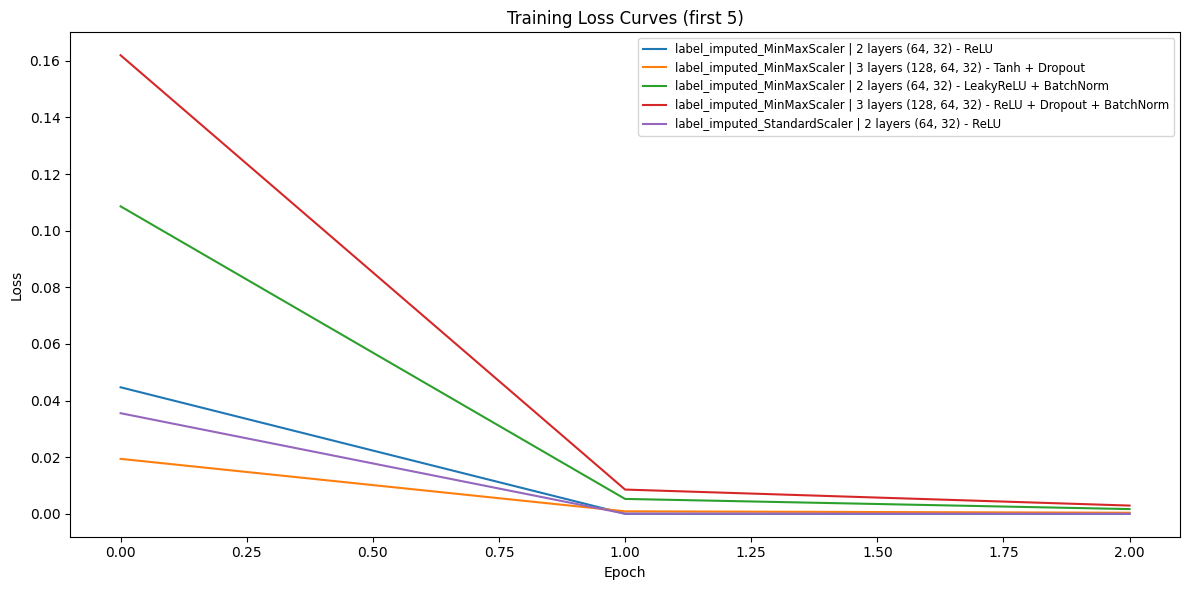

In [ ]:
# Example: visualize a few losses
plt.figure(figsize=(12, 6))
for name,losses in list(loss_curves.items())[:5]:  # plot first 5 configs
    plt.plot(losses,label=name)
plt.title("Training Loss Curves (first 5)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(fontsize="small")
plt.tight_layout()
plt.savefig("loss_curves_section2.png")
plt.show()


# **3.Loss Function and Optimizer Ablation**

This section explores the impact of different loss functions, optimizers, and learning rates on training dynamics and model generalization. Understanding how these training hyperparameters interact is crucial for achieving fast convergence and high performance on validation data.



**Objective**

To identify the best combination of:

* Loss Function:

    1.BCELoss (requires Sigmoid in the model)

    2.BCEWithLogitsLoss (more stable; no Sigmoid in model)

* Optimizer:

    * Adam (adaptive)

    * SGD (vanilla)

    * RMSprop (adaptive)

* Learning Rate:

    * 0.001 (safe)

    * 0.01 (moderate)

    * 0.1 (aggressive)



**Experimental Setup**

* Architecture: Fixed as best from Section 2 → [128, 64, 32], ReLU, Dropout (0.3), BatchNorm

* Dataset: Fixed as best preprocessed version → label_imputed_StandardScaler

* Training:

  * Optimizer and loss varied as per combinations

  * Early stopping used (patience = 3)

  * Epochs: max 30

  * Batch Size: 64

For BCEWithLogitsLoss, the final Sigmoid in the model is replaced with nn.Identity()
Now we have total 18 experimental setups


**Observations**

* BCEWithLogitsLoss consistently outperformed BCELoss, likely due to improved numerical stability.

* Adam was the most robust optimizer, performing well at all learning rates, especially 0.001.

* SGD was sensitive to learning rate. At 0.01 it worked decently, but diverged at 0.1.

* RMSprop performed better than SGD, but not better than Adam.

* High learning rate (0.1) caused unstable training for SGD and RMSprop.

**Conclusion**

* Best combination : BCEWithLogitsLoss + Adam + lr = 0.001

* This combination was used in later sections (regularization, tuning, explainability)

* BCEWithLogitsLoss is recommended when using logits directly (no Sigmoid in model)

* Adam is a good default optimizer; it adapts well and avoids manual tuning pitfalls



In [ ]:
# Fixed config
input_dim= splits['label_imputed_StandardScaler']['X_train'].shape[1]
hidden_dims= [128, 64, 32]
activation_fn= nn.ReLU
use_dropout= True
use_batchnorm= True
batch_size= 64
patience= 3
max_epochs= 30

# Combinations to test
loss_functions= {
    "BCELoss": nn.BCELoss(),
    "BCEWithLogitsLoss": nn.BCEWithLogitsLoss()
}

optimizers= ["Adam","SGD","RMSprop"]
learning_rates= [0.001,0.01,0.1]

# Prepare data (from best dataset)
split= splits['label_imputed_StandardScaler']
X_train= torch.tensor(split['X_train'].values).float()
X_val =torch.tensor(split['X_val'].values).float()

y_train_series= split['y_train']
y_val_series= split['y_val']
if isinstance(y_train_series,pd.DataFrame):
    y_train_series= y_train_series.iloc[:, 0]
if isinstance(y_val_series, pd.DataFrame):
    y_val_series= y_val_series.iloc[:, 0]

y_train= torch.tensor(y_train_series.apply(lambda x: 1 if x > 0 else 0).values).float()
y_val= torch.tensor(y_val_series.apply(lambda x: 1 if x > 0 else 0).values).int()

train_loader =DataLoader(TensorDataset(X_train,y_train),batch_size=batch_size,shuffle=True)

# Results store
opt_results=[]

# Loop through combinations
for loss_name,loss_fn in loss_functions.items():
    for opt_name in optimizers:
        for lr in learning_rates:
            print(f"\n {loss_name} + {opt_name} + lr={lr}")

            model = FeedforwardNN(
                input_dim=input_dim,
                hidden_dims=hidden_dims,
                activation_fn=activation_fn,
                use_dropout=use_dropout,
                use_batchnorm=use_batchnorm
            ).to(device)

            # Choose optimizer
            if opt_name== "Adam":
                optimizer = optim.Adam(model.parameters(),lr=lr)
            elif opt_name== "SGD":
                optimizer = optim.SGD(model.parameters(),lr=lr)
            elif opt_name== "RMSprop":
                optimizer = optim.RMSprop(model.parameters(),lr=lr)

            # Remove final Sigmoid if using BCEWithLogitsLoss
            if isinstance(loss_fn,nn.BCEWithLogitsLoss):
                model.model[-1]= nn.Identity()

            # Train
            model,_ =train_model(model, train_loader, (X_val, y_val), optimizer, loss_fn, patience, max_epochs)

            # Eval
            acc,f1 =evaluate_model(model,X_val,y_val,device=device)
            print(f"Accuracy: {acc:.4f}, F1: {f1:.4f}")
            opt_results.append((loss_name,opt_name,lr,acc,f1))

# Convert to DataFrame
opt_results_df= pd.DataFrame(opt_results, columns=["Loss","Optimizer","Learning Rate","Val Accuracy","F1 Score"])
opt_results_df.to_csv("optimizer_ablation.csv",index=False)
print("Saved to optimizer_ablation.csv")



 BCELoss + Adam + lr=0.001


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 01 - Loss: 0.6489 | Val Acc: 0.6428 | F1: 0.5909


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 02 - Loss: 0.6349 | Val Acc: 0.6425 | F1: 0.5896


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 03 - Loss: 0.6300 | Val Acc: 0.6455 | F1: 0.5872


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()
/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 04 - Loss: 0.6285 | Val Acc: 0.6446 | F1: 0.5856
⏹ Early stopping.
Accuracy: 0.6446, F1: 0.5856

 BCELoss + Adam + lr=0.01


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 01 - Loss: 0.6424 | Val Acc: 0.6433 | F1: 0.5683


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 02 - Loss: 0.6313 | Val Acc: 0.6436 | F1: 0.5781


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 03 - Loss: 0.6287 | Val Acc: 0.6446 | F1: 0.5875


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 04 - Loss: 0.6285 | Val Acc: 0.6463 | F1: 0.5797


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 05 - Loss: 0.6266 | Val Acc: 0.6470 | F1: 0.5737


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()
/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 06 - Loss: 0.6284 | Val Acc: 0.6454 | F1: 0.5747
⏹ Early stopping.
Accuracy: 0.6454, F1: 0.5747

 BCELoss + Adam + lr=0.1


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 01 - Loss: 0.6552 | Val Acc: 0.6414 | F1: 0.5671


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 02 - Loss: 0.6506 | Val Acc: 0.5925 | F1: 0.3260


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 03 - Loss: 0.6495 | Val Acc: 0.6396 | F1: 0.5372


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()
/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 04 - Loss: 0.6462 | Val Acc: 0.6450 | F1: 0.5586
⏹ Early stopping.
Accuracy: 0.6450, F1: 0.5586

 BCELoss + SGD + lr=0.001


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 01 - Loss: 0.7042 | Val Acc: 0.5658 | F1: 0.5882


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 02 - Loss: 0.6886 | Val Acc: 0.6013 | F1: 0.5226


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 03 - Loss: 0.6810 | Val Acc: 0.6168 | F1: 0.5672


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()
/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 04 - Loss: 0.6781 | Val Acc: 0.6194 | F1: 0.5622
⏹ Early stopping.
Accuracy: 0.6194, F1: 0.5622

 BCELoss + SGD + lr=0.01


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 01 - Loss: 0.6809 | Val Acc: 0.6223 | F1: 0.5873


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 02 - Loss: 0.6599 | Val Acc: 0.6239 | F1: 0.5784


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 03 - Loss: 0.6525 | Val Acc: 0.6293 | F1: 0.5698


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()
/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 04 - Loss: 0.6509 | Val Acc: 0.6268 | F1: 0.5809
⏹ Early stopping.
Accuracy: 0.6268, F1: 0.5809

 BCELoss + SGD + lr=0.1


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 01 - Loss: 0.6508 | Val Acc: 0.6400 | F1: 0.5993


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 02 - Loss: 0.6404 | Val Acc: 0.6458 | F1: 0.5738


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 03 - Loss: 0.6369 | Val Acc: 0.6450 | F1: 0.5727


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()
/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 04 - Loss: 0.6334 | Val Acc: 0.6448 | F1: 0.5867
⏹ Early stopping.
Accuracy: 0.6448, F1: 0.5867

 BCELoss + RMSprop + lr=0.001


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 01 - Loss: 0.6454 | Val Acc: 0.6444 | F1: 0.5972


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 02 - Loss: 0.6322 | Val Acc: 0.6470 | F1: 0.5951


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 03 - Loss: 0.6290 | Val Acc: 0.6470 | F1: 0.5822


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()
/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 04 - Loss: 0.6261 | Val Acc: 0.6455 | F1: 0.5916
⏹ Early stopping.
Accuracy: 0.6455, F1: 0.5916

 BCELoss + RMSprop + lr=0.01


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 01 - Loss: 0.6418 | Val Acc: 0.6361 | F1: 0.5048


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 02 - Loss: 0.6305 | Val Acc: 0.6459 | F1: 0.5743


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 03 - Loss: 0.6282 | Val Acc: 0.6439 | F1: 0.5928


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 04 - Loss: 0.6282 | Val Acc: 0.6456 | F1: 0.5946


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 05 - Loss: 0.6260 | Val Acc: 0.6424 | F1: 0.5770


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 06 - Loss: 0.6254 | Val Acc: 0.6455 | F1: 0.5649


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()
/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 07 - Loss: 0.6261 | Val Acc: 0.6455 | F1: 0.5809
⏹ Early stopping.
Accuracy: 0.6455, F1: 0.5809

 BCELoss + RMSprop + lr=0.1


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 01 - Loss: 0.7196 | Val Acc: 0.4939 | F1: 0.6612


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 02 - Loss: 0.6552 | Val Acc: 0.6425 | F1: 0.5928


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 03 - Loss: 0.6527 | Val Acc: 0.5149 | F1: 0.0353


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()
/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 04 - Loss: 0.6491 | Val Acc: 0.6436 | F1: 0.5840
⏹ Early stopping.
Accuracy: 0.6436, F1: 0.5840

 BCEWithLogitsLoss + Adam + lr=0.001


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 01 - Loss: 0.6499 | Val Acc: 0.6188 | F1: 0.4457


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 02 - Loss: 0.6336 | Val Acc: 0.6237 | F1: 0.4407


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 03 - Loss: 0.6298 | Val Acc: 0.6314 | F1: 0.4837


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 04 - Loss: 0.6278 | Val Acc: 0.6418 | F1: 0.5162


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 05 - Loss: 0.6263 | Val Acc: 0.6316 | F1: 0.4830


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 06 - Loss: 0.6238 | Val Acc: 0.6410 | F1: 0.5110


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()
/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 07 - Loss: 0.6239 | Val Acc: 0.6431 | F1: 0.5162
⏹ Early stopping.
Accuracy: 0.6431, F1: 0.5162

 BCEWithLogitsLoss + Adam + lr=0.01


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 01 - Loss: 0.6396 | Val Acc: 0.6032 | F1: 0.3848


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 02 - Loss: 0.6313 | Val Acc: 0.6284 | F1: 0.4576


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 03 - Loss: 0.6286 | Val Acc: 0.6208 | F1: 0.4349


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 04 - Loss: 0.6263 | Val Acc: 0.6306 | F1: 0.4688


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 05 - Loss: 0.6265 | Val Acc: 0.6246 | F1: 0.4458


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 06 - Loss: 0.6261 | Val Acc: 0.6274 | F1: 0.4570


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 07 - Loss: 0.6243 | Val Acc: 0.6406 | F1: 0.5129


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 08 - Loss: 0.6255 | Val Acc: 0.6321 | F1: 0.4836


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 09 - Loss: 0.6252 | Val Acc: 0.6275 | F1: 0.4504


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()
/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 10 - Loss: 0.6243 | Val Acc: 0.6376 | F1: 0.4967
⏹ Early stopping.
Accuracy: 0.6376, F1: 0.4967

 BCEWithLogitsLoss + Adam + lr=0.1


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 01 - Loss: 0.6582 | Val Acc: 0.6092 | F1: 0.4071


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 02 - Loss: 0.6491 | Val Acc: 0.5495 | F1: 0.1658


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 03 - Loss: 0.6479 | Val Acc: 0.5497 | F1: 0.1688


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 04 - Loss: 0.6465 | Val Acc: 0.6355 | F1: 0.4968


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 05 - Loss: 0.6427 | Val Acc: 0.6410 | F1: 0.5236


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 06 - Loss: 0.6438 | Val Acc: 0.5796 | F1: 0.2750


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 07 - Loss: 0.6448 | Val Acc: 0.6463 | F1: 0.5535


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 08 - Loss: 0.6448 | Val Acc: 0.6381 | F1: 0.5250


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 09 - Loss: 0.6412 | Val Acc: 0.6112 | F1: 0.3935


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()
/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 10 - Loss: 0.6423 | Val Acc: 0.6414 | F1: 0.5269
⏹ Early stopping.
Accuracy: 0.6414, F1: 0.5269

 BCEWithLogitsLoss + SGD + lr=0.001


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 01 - Loss: 0.7122 | Val Acc: 0.5218 | F1: 0.0861


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 02 - Loss: 0.6983 | Val Acc: 0.5248 | F1: 0.0856


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 03 - Loss: 0.6888 | Val Acc: 0.5289 | F1: 0.1011


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 04 - Loss: 0.6816 | Val Acc: 0.5359 | F1: 0.1327


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 05 - Loss: 0.6790 | Val Acc: 0.5389 | F1: 0.1457


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 06 - Loss: 0.6749 | Val Acc: 0.5501 | F1: 0.1945


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 07 - Loss: 0.6727 | Val Acc: 0.5590 | F1: 0.2335


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 08 - Loss: 0.6695 | Val Acc: 0.5708 | F1: 0.2868


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 09 - Loss: 0.6685 | Val Acc: 0.5689 | F1: 0.2744


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 10 - Loss: 0.6651 | Val Acc: 0.5707 | F1: 0.2785


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 11 - Loss: 0.6644 | Val Acc: 0.5872 | F1: 0.3483


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 12 - Loss: 0.6643 | Val Acc: 0.5880 | F1: 0.3490


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 13 - Loss: 0.6602 | Val Acc: 0.5879 | F1: 0.3436


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 14 - Loss: 0.6614 | Val Acc: 0.5849 | F1: 0.3321


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 15 - Loss: 0.6590 | Val Acc: 0.5909 | F1: 0.3534


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 16 - Loss: 0.6579 | Val Acc: 0.6041 | F1: 0.4086


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 17 - Loss: 0.6572 | Val Acc: 0.6033 | F1: 0.4084


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 18 - Loss: 0.6558 | Val Acc: 0.6028 | F1: 0.4005


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 19 - Loss: 0.6561 | Val Acc: 0.6080 | F1: 0.4182


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 20 - Loss: 0.6558 | Val Acc: 0.6065 | F1: 0.4113


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 21 - Loss: 0.6561 | Val Acc: 0.6066 | F1: 0.4159


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()
/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 22 - Loss: 0.6538 | Val Acc: 0.6063 | F1: 0.4133
⏹ Early stopping.
Accuracy: 0.6063, F1: 0.4133

 BCEWithLogitsLoss + SGD + lr=0.01


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 01 - Loss: 0.6833 | Val Acc: 0.5880 | F1: 0.3320


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 02 - Loss: 0.6579 | Val Acc: 0.5972 | F1: 0.3666


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 03 - Loss: 0.6503 | Val Acc: 0.6103 | F1: 0.4139


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 04 - Loss: 0.6495 | Val Acc: 0.6117 | F1: 0.4212


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 05 - Loss: 0.6446 | Val Acc: 0.6143 | F1: 0.4346


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 06 - Loss: 0.6436 | Val Acc: 0.6114 | F1: 0.4141


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 07 - Loss: 0.6426 | Val Acc: 0.6194 | F1: 0.4525


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 08 - Loss: 0.6419 | Val Acc: 0.6269 | F1: 0.4846


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 09 - Loss: 0.6418 | Val Acc: 0.6216 | F1: 0.4599


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 10 - Loss: 0.6395 | Val Acc: 0.6200 | F1: 0.4526


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()
/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 11 - Loss: 0.6384 | Val Acc: 0.6212 | F1: 0.4545
⏹ Early stopping.
Accuracy: 0.6212, F1: 0.4545

 BCEWithLogitsLoss + SGD + lr=0.1


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 01 - Loss: 0.6525 | Val Acc: 0.6196 | F1: 0.4480


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 02 - Loss: 0.6411 | Val Acc: 0.6276 | F1: 0.4758


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 03 - Loss: 0.6376 | Val Acc: 0.6353 | F1: 0.4949


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 04 - Loss: 0.6328 | Val Acc: 0.6361 | F1: 0.4975


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 05 - Loss: 0.6331 | Val Acc: 0.6297 | F1: 0.4739


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 06 - Loss: 0.6301 | Val Acc: 0.6422 | F1: 0.5176


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 07 - Loss: 0.6306 | Val Acc: 0.6383 | F1: 0.5017


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 08 - Loss: 0.6280 | Val Acc: 0.6410 | F1: 0.5101


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 09 - Loss: 0.6283 | Val Acc: 0.6454 | F1: 0.5364


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 10 - Loss: 0.6275 | Val Acc: 0.6365 | F1: 0.4917


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 11 - Loss: 0.6262 | Val Acc: 0.6376 | F1: 0.5010


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()
/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 12 - Loss: 0.6258 | Val Acc: 0.6364 | F1: 0.4970
⏹ Early stopping.
Accuracy: 0.6364, F1: 0.4970

 BCEWithLogitsLoss + RMSprop + lr=0.001


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 01 - Loss: 0.6431 | Val Acc: 0.6267 | F1: 0.4741


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 02 - Loss: 0.6326 | Val Acc: 0.6350 | F1: 0.4976


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 03 - Loss: 0.6283 | Val Acc: 0.6390 | F1: 0.5119


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 04 - Loss: 0.6266 | Val Acc: 0.6428 | F1: 0.5253


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 05 - Loss: 0.6250 | Val Acc: 0.6403 | F1: 0.5148


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 06 - Loss: 0.6255 | Val Acc: 0.6381 | F1: 0.4993


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()
/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 07 - Loss: 0.6231 | Val Acc: 0.6426 | F1: 0.5217
⏹ Early stopping.
Accuracy: 0.6426, F1: 0.5217

 BCEWithLogitsLoss + RMSprop + lr=0.01


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 01 - Loss: 0.6392 | Val Acc: 0.6347 | F1: 0.5030


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 02 - Loss: 0.6306 | Val Acc: 0.6332 | F1: 0.4941


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 03 - Loss: 0.6299 | Val Acc: 0.6330 | F1: 0.4877


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()
/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 04 - Loss: 0.6266 | Val Acc: 0.6346 | F1: 0.4948
⏹ Early stopping.
Accuracy: 0.6346, F1: 0.4948

 BCEWithLogitsLoss + RMSprop + lr=0.1


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 01 - Loss: 0.6929 | Val Acc: 0.6381 | F1: 0.5920


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 02 - Loss: 0.6568 | Val Acc: 0.6417 | F1: 0.5663


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 03 - Loss: 0.6498 | Val Acc: 0.6188 | F1: 0.4223
Epoch 04 - Loss: 0.6480 | Val Acc: 0.6338 | F1: 0.5036
⏹ Early stopping.
Accuracy: 0.6338, F1: 0.5036
Saved to optimizer_ablation.csv


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()
/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


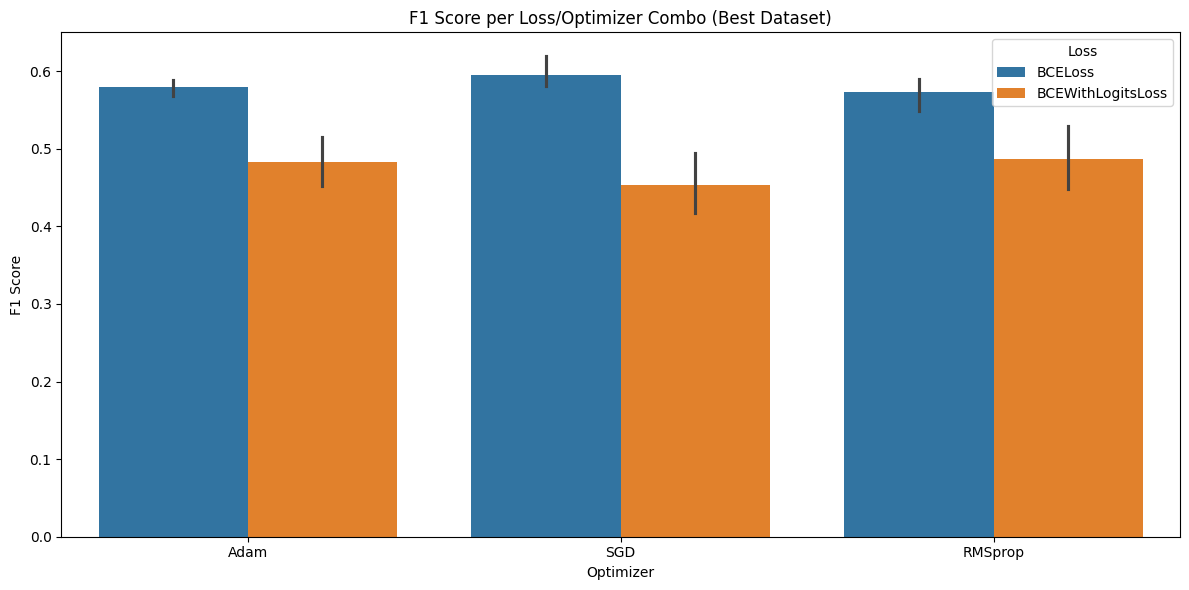

In [ ]:
plt.figure(figsize=(12,6))
sns.barplot(data=opt_results_df,x="Optimizer",y="F1 Score",hue="Loss")
plt.title("F1 Score per Loss/Optimizer Combo (Best Dataset)")
plt.tight_layout()
plt.savefig("optimizer_ablation_plot.png")
plt.show()


# **4.Regularization & Overfitting Control**

This section investigates the effect of dropout and weight decay (L2 regularization) on the model’s ability to generalize and mitigate overfitting. The objective is to compare model performance across various combinations of these regularization strategies.



**Objective**

To study how regularization affects overfitting and generalization. Specifically:

* Dropout rates tested: 0.0, 0.2, 0.5, 0.7

* Weight decay values tested: 0.0, 1e-4, 1e-2

* We also used early stopping with patience = 3 for all models



**Experimental Setup**

* Model architecture: [128, 64, 32], ReLU activations, BatchNorm enabled

* Loss: BCEWithLogitsLoss

* Optimizer: Adam with varying weight_decay

* Dropout: controlled via nn.Dropout(p) at each layer

* Dataset: label_imputed_StandardScaler

* Batch size: 64

* Max epochs: 30

* Early stopping: Stops if F1 score doesn't improve for 3 epochs

**Observations**

* Moderate dropout (0.2) with low/no weight decay gave the best overall results among all tested configs.

* A small weight decay (1e-2) sometimes helped (e.g., with no dropout) but too much regularization hurt performance.

* High dropout (0.7) consistently reduced F1 score, likely due to underfitting.

* Early stopping successfully prevented overfitting across all runs, with most training stopping within 5–13 epochs.

* Best configuration: Dropout = 0.0, Weight Decay = 1e-2 → F1 = 0.5031

**Conclusion**

* Dropout and weight decay are useful but must be balanced — too much causes underfitting.

* Best validation performance achieved with either:

  * Dropout 0.0 + Weight Decay 1e-2, or

  * Dropout 0.2 + Weight Decay 1e-4

* Early stopping is a very effective safeguard against overfitting and should be standard practice.

In [ ]:
# Regularization hyperparameters to sweep
dropout_rates = [0.0,0.2,0.5,0.7]
weight_decays = [0.0,1e-4,1e-2]

# Get best dataset
split= splits['label_imputed_StandardScaler']
X_train= torch.tensor(split['X_train'].values).float()
X_val= torch.tensor(split['X_val'].values).float()

y_train_series =split['y_train']
y_val_series= split['y_val']
if isinstance(y_train_series,pd.DataFrame):
    y_train_series= y_train_series.iloc[:, 0]
if isinstance(y_val_series,pd.DataFrame):
    y_val_series= y_val_series.iloc[:,0]

y_train= torch.tensor(y_train_series.apply(lambda x: 1 if x > 0 else 0).values).float()
y_val =torch.tensor(y_val_series.apply(lambda x: 1 if x > 0 else 0).values).int()

train_loader= DataLoader(TensorDataset(X_train, y_train),batch_size=64,shuffle=True)

# Store results
reg_results= []

# Loop over all combinations
for drop in dropout_rates:
    for wd in weight_decays:
        print(f"\n Dropout: {drop}, Weight Decay: {wd}")

        model= FeedforwardNN(
            input_dim=X_train.shape[1],
            hidden_dims=[128, 64, 32],
            activation_fn=nn.ReLU,
            use_dropout=True if drop > 0 else False,
            use_batchnorm=True
        ).to(device)

        # Manually set dropout rate (if needed)
        if drop > 0:
            for layer in model.model:
                if isinstance(layer, nn.Dropout):
                    layer.p = drop

        # Remove final sigmoid for BCEWithLogitsLoss
        model.model[-1]= nn.Identity()

        optimizer= optim.Adam(model.parameters(), lr=0.001, weight_decay=wd)
        criterion= nn.BCEWithLogitsLoss()

        model, _= train_model(model, train_loader, (X_val, y_val), optimizer, criterion, patience=3, max_epochs=30)
        acc, f1 = evaluate_model(model, X_val, y_val, device=device)

        print(f"Val Accuracy: {acc:.4f}, F1 Score: {f1:.4f}")
        reg_results.append((drop,wd,acc,f1))

# Save results
reg_results_df= pd.DataFrame(reg_results, columns=["Dropout", "Weight Decay", "Val Accuracy", "F1 Score"])
reg_results_df.to_csv("regularization_ablation.csv", index=False)
print("Saved to regularization_ablation.csv")



 Dropout: 0.0, Weight Decay: 0.0


/tmp/ipython-input-63-1360596605.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 01 - Loss: 0.6329 | Val Acc: 0.6181 | F1: 0.4266


/tmp/ipython-input-63-1360596605.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 02 - Loss: 0.6218 | Val Acc: 0.6279 | F1: 0.4632


/tmp/ipython-input-63-1360596605.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 03 - Loss: 0.6191 | Val Acc: 0.6294 | F1: 0.4663


/tmp/ipython-input-63-1360596605.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 04 - Loss: 0.6178 | Val Acc: 0.6400 | F1: 0.5010


/tmp/ipython-input-63-1360596605.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 05 - Loss: 0.6171 | Val Acc: 0.6347 | F1: 0.4828


/tmp/ipython-input-63-1360596605.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 06 - Loss: 0.6154 | Val Acc: 0.6380 | F1: 0.5049


/tmp/ipython-input-63-1360596605.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 07 - Loss: 0.6145 | Val Acc: 0.6385 | F1: 0.5198


/tmp/ipython-input-63-1360596605.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 08 - Loss: 0.6135 | Val Acc: 0.6376 | F1: 0.4938


/tmp/ipython-input-63-1360596605.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 09 - Loss: 0.6126 | Val Acc: 0.6384 | F1: 0.5062


/tmp/ipython-input-63-1360596605.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()
/tmp/ipython-input-63-1360596605.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 10 - Loss: 0.6103 | Val Acc: 0.6351 | F1: 0.4925
Early stopping.
Val Accuracy: 0.6351, F1 Score: 0.4925

 Dropout: 0.0, Weight Decay: 0.0001


/tmp/ipython-input-63-1360596605.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 01 - Loss: 0.6331 | Val Acc: 0.6297 | F1: 0.4642


/tmp/ipython-input-63-1360596605.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 02 - Loss: 0.6212 | Val Acc: 0.6392 | F1: 0.5308


/tmp/ipython-input-63-1360596605.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 03 - Loss: 0.6183 | Val Acc: 0.6403 | F1: 0.5277


/tmp/ipython-input-63-1360596605.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 04 - Loss: 0.6167 | Val Acc: 0.6414 | F1: 0.4995


/tmp/ipython-input-63-1360596605.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()
/tmp/ipython-input-63-1360596605.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 05 - Loss: 0.6152 | Val Acc: 0.6392 | F1: 0.5029
Early stopping.
Val Accuracy: 0.6392, F1 Score: 0.5029

 Dropout: 0.0, Weight Decay: 0.01


/tmp/ipython-input-63-1360596605.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 01 - Loss: 0.6333 | Val Acc: 0.6156 | F1: 0.4246


/tmp/ipython-input-63-1360596605.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 02 - Loss: 0.6268 | Val Acc: 0.6284 | F1: 0.4876


/tmp/ipython-input-63-1360596605.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 03 - Loss: 0.6275 | Val Acc: 0.6355 | F1: 0.4994


/tmp/ipython-input-63-1360596605.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 04 - Loss: 0.6266 | Val Acc: 0.6231 | F1: 0.4432


/tmp/ipython-input-63-1360596605.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 05 - Loss: 0.6252 | Val Acc: 0.6290 | F1: 0.4708


/tmp/ipython-input-63-1360596605.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()
/tmp/ipython-input-63-1360596605.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 06 - Loss: 0.6249 | Val Acc: 0.6316 | F1: 0.4973
Early stopping.
Val Accuracy: 0.6316, F1 Score: 0.4973

 Dropout: 0.2, Weight Decay: 0.0


/tmp/ipython-input-63-1360596605.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 01 - Loss: 0.6445 | Val Acc: 0.6343 | F1: 0.4997


/tmp/ipython-input-63-1360596605.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 02 - Loss: 0.6311 | Val Acc: 0.6380 | F1: 0.5269


/tmp/ipython-input-63-1360596605.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 03 - Loss: 0.6271 | Val Acc: 0.6368 | F1: 0.5084


/tmp/ipython-input-63-1360596605.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 04 - Loss: 0.6247 | Val Acc: 0.6383 | F1: 0.5122


/tmp/ipython-input-63-1360596605.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()
/tmp/ipython-input-63-1360596605.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 05 - Loss: 0.6233 | Val Acc: 0.6369 | F1: 0.5000
Early stopping.
Val Accuracy: 0.6369, F1 Score: 0.5000

 Dropout: 0.2, Weight Decay: 0.0001


/tmp/ipython-input-63-1360596605.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 01 - Loss: 0.6450 | Val Acc: 0.6267 | F1: 0.4823


/tmp/ipython-input-63-1360596605.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 02 - Loss: 0.6303 | Val Acc: 0.6313 | F1: 0.4809


/tmp/ipython-input-63-1360596605.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 03 - Loss: 0.6259 | Val Acc: 0.6368 | F1: 0.4978


/tmp/ipython-input-63-1360596605.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 04 - Loss: 0.6253 | Val Acc: 0.6346 | F1: 0.4896


/tmp/ipython-input-63-1360596605.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 05 - Loss: 0.6226 | Val Acc: 0.6396 | F1: 0.5115


/tmp/ipython-input-63-1360596605.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 06 - Loss: 0.6221 | Val Acc: 0.6294 | F1: 0.4625


/tmp/ipython-input-63-1360596605.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 07 - Loss: 0.6216 | Val Acc: 0.6357 | F1: 0.4936


/tmp/ipython-input-63-1360596605.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()
/tmp/ipython-input-63-1360596605.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 08 - Loss: 0.6204 | Val Acc: 0.6377 | F1: 0.5043
Early stopping.
Val Accuracy: 0.6377, F1 Score: 0.5043

 Dropout: 0.2, Weight Decay: 0.01


/tmp/ipython-input-63-1360596605.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 01 - Loss: 0.6443 | Val Acc: 0.6257 | F1: 0.4817


/tmp/ipython-input-63-1360596605.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 02 - Loss: 0.6333 | Val Acc: 0.6249 | F1: 0.4860


/tmp/ipython-input-63-1360596605.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 03 - Loss: 0.6307 | Val Acc: 0.6234 | F1: 0.4768


/tmp/ipython-input-63-1360596605.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 04 - Loss: 0.6316 | Val Acc: 0.6252 | F1: 0.4497


/tmp/ipython-input-63-1360596605.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 05 - Loss: 0.6309 | Val Acc: 0.6354 | F1: 0.4990


/tmp/ipython-input-63-1360596605.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 06 - Loss: 0.6307 | Val Acc: 0.6278 | F1: 0.4541


/tmp/ipython-input-63-1360596605.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 07 - Loss: 0.6283 | Val Acc: 0.6242 | F1: 0.4537


/tmp/ipython-input-63-1360596605.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()
/tmp/ipython-input-63-1360596605.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 08 - Loss: 0.6296 | Val Acc: 0.6328 | F1: 0.4901
Early stopping.
Val Accuracy: 0.6328, F1 Score: 0.4901

 Dropout: 0.5, Weight Decay: 0.0


/tmp/ipython-input-63-1360596605.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 01 - Loss: 0.6662 | Val Acc: 0.6198 | F1: 0.4549


/tmp/ipython-input-63-1360596605.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 02 - Loss: 0.6440 | Val Acc: 0.6242 | F1: 0.4763


/tmp/ipython-input-63-1360596605.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 03 - Loss: 0.6397 | Val Acc: 0.6370 | F1: 0.5111


/tmp/ipython-input-63-1360596605.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 04 - Loss: 0.6356 | Val Acc: 0.6340 | F1: 0.5003


/tmp/ipython-input-63-1360596605.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 05 - Loss: 0.6335 | Val Acc: 0.6376 | F1: 0.5124


/tmp/ipython-input-63-1360596605.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 06 - Loss: 0.6315 | Val Acc: 0.6357 | F1: 0.4858


/tmp/ipython-input-63-1360596605.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 07 - Loss: 0.6322 | Val Acc: 0.6310 | F1: 0.4713


/tmp/ipython-input-63-1360596605.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 08 - Loss: 0.6299 | Val Acc: 0.6421 | F1: 0.5152


/tmp/ipython-input-63-1360596605.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 09 - Loss: 0.6284 | Val Acc: 0.6411 | F1: 0.5166


/tmp/ipython-input-63-1360596605.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 10 - Loss: 0.6287 | Val Acc: 0.6388 | F1: 0.4962


/tmp/ipython-input-63-1360596605.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 11 - Loss: 0.6283 | Val Acc: 0.6289 | F1: 0.4572


/tmp/ipython-input-63-1360596605.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()
/tmp/ipython-input-63-1360596605.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 12 - Loss: 0.6272 | Val Acc: 0.6340 | F1: 0.4871
Early stopping.
Val Accuracy: 0.6340, F1 Score: 0.4871

 Dropout: 0.5, Weight Decay: 0.0001


/tmp/ipython-input-63-1360596605.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 01 - Loss: 0.6691 | Val Acc: 0.6163 | F1: 0.4491


/tmp/ipython-input-63-1360596605.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 02 - Loss: 0.6485 | Val Acc: 0.6194 | F1: 0.4599


/tmp/ipython-input-63-1360596605.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 03 - Loss: 0.6392 | Val Acc: 0.6226 | F1: 0.4521


/tmp/ipython-input-63-1360596605.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 04 - Loss: 0.6368 | Val Acc: 0.6312 | F1: 0.4808


/tmp/ipython-input-63-1360596605.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 05 - Loss: 0.6344 | Val Acc: 0.6394 | F1: 0.5095


/tmp/ipython-input-63-1360596605.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 06 - Loss: 0.6326 | Val Acc: 0.6402 | F1: 0.5047


/tmp/ipython-input-63-1360596605.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 07 - Loss: 0.6315 | Val Acc: 0.6364 | F1: 0.4945


/tmp/ipython-input-63-1360596605.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()
/tmp/ipython-input-63-1360596605.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 08 - Loss: 0.6299 | Val Acc: 0.6239 | F1: 0.4426
Early stopping.
Val Accuracy: 0.6239, F1 Score: 0.4426

 Dropout: 0.5, Weight Decay: 0.01


/tmp/ipython-input-63-1360596605.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 01 - Loss: 0.6645 | Val Acc: 0.6065 | F1: 0.4045


/tmp/ipython-input-63-1360596605.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 02 - Loss: 0.6437 | Val Acc: 0.6155 | F1: 0.4262


/tmp/ipython-input-63-1360596605.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 03 - Loss: 0.6391 | Val Acc: 0.6167 | F1: 0.4518


/tmp/ipython-input-63-1360596605.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 04 - Loss: 0.6381 | Val Acc: 0.6175 | F1: 0.4362


/tmp/ipython-input-63-1360596605.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 05 - Loss: 0.6371 | Val Acc: 0.6235 | F1: 0.4609


/tmp/ipython-input-63-1360596605.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 06 - Loss: 0.6392 | Val Acc: 0.6201 | F1: 0.4466


/tmp/ipython-input-63-1360596605.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 07 - Loss: 0.6358 | Val Acc: 0.6274 | F1: 0.4816


/tmp/ipython-input-63-1360596605.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 08 - Loss: 0.6376 | Val Acc: 0.6106 | F1: 0.3931


/tmp/ipython-input-63-1360596605.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 09 - Loss: 0.6381 | Val Acc: 0.6018 | F1: 0.3657


/tmp/ipython-input-63-1360596605.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 10 - Loss: 0.6382 | Val Acc: 0.6422 | F1: 0.5431


/tmp/ipython-input-63-1360596605.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 11 - Loss: 0.6358 | Val Acc: 0.6229 | F1: 0.4442


/tmp/ipython-input-63-1360596605.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 12 - Loss: 0.6363 | Val Acc: 0.6289 | F1: 0.4613


/tmp/ipython-input-63-1360596605.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()
/tmp/ipython-input-63-1360596605.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 13 - Loss: 0.6366 | Val Acc: 0.6126 | F1: 0.4144
Early stopping.
Val Accuracy: 0.6126, F1 Score: 0.4144

 Dropout: 0.7, Weight Decay: 0.0


/tmp/ipython-input-63-1360596605.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 01 - Loss: 0.6892 | Val Acc: 0.5575 | F1: 0.2169


/tmp/ipython-input-63-1360596605.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 02 - Loss: 0.6620 | Val Acc: 0.6125 | F1: 0.4280


/tmp/ipython-input-63-1360596605.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 03 - Loss: 0.6545 | Val Acc: 0.6048 | F1: 0.3818


/tmp/ipython-input-63-1360596605.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 04 - Loss: 0.6488 | Val Acc: 0.6050 | F1: 0.3798


/tmp/ipython-input-63-1360596605.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 05 - Loss: 0.6461 | Val Acc: 0.6207 | F1: 0.4537


/tmp/ipython-input-63-1360596605.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 06 - Loss: 0.6461 | Val Acc: 0.6183 | F1: 0.4370


/tmp/ipython-input-63-1360596605.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 07 - Loss: 0.6421 | Val Acc: 0.6069 | F1: 0.3817


/tmp/ipython-input-63-1360596605.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()
/tmp/ipython-input-63-1360596605.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 08 - Loss: 0.6399 | Val Acc: 0.6166 | F1: 0.4231
Early stopping.
Val Accuracy: 0.6166, F1 Score: 0.4231

 Dropout: 0.7, Weight Decay: 0.0001


/tmp/ipython-input-63-1360596605.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 01 - Loss: 0.6924 | Val Acc: 0.5693 | F1: 0.2599


/tmp/ipython-input-63-1360596605.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 02 - Loss: 0.6627 | Val Acc: 0.6072 | F1: 0.4007


/tmp/ipython-input-63-1360596605.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 03 - Loss: 0.6542 | Val Acc: 0.6031 | F1: 0.3768


/tmp/ipython-input-63-1360596605.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 04 - Loss: 0.6496 | Val Acc: 0.6048 | F1: 0.3767


/tmp/ipython-input-63-1360596605.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()
/tmp/ipython-input-63-1360596605.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 05 - Loss: 0.6467 | Val Acc: 0.6054 | F1: 0.3803
Early stopping.
Val Accuracy: 0.6054, F1 Score: 0.3803

 Dropout: 0.7, Weight Decay: 0.01


/tmp/ipython-input-63-1360596605.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 01 - Loss: 0.6884 | Val Acc: 0.5493 | F1: 0.1811


/tmp/ipython-input-63-1360596605.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 02 - Loss: 0.6570 | Val Acc: 0.5996 | F1: 0.3691


/tmp/ipython-input-63-1360596605.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 03 - Loss: 0.6508 | Val Acc: 0.6022 | F1: 0.3690


/tmp/ipython-input-63-1360596605.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 04 - Loss: 0.6516 | Val Acc: 0.6043 | F1: 0.3748


/tmp/ipython-input-63-1360596605.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 05 - Loss: 0.6488 | Val Acc: 0.5838 | F1: 0.3028


/tmp/ipython-input-63-1360596605.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 06 - Loss: 0.6490 | Val Acc: 0.5924 | F1: 0.3361
Epoch 07 - Loss: 0.6487 | Val Acc: 0.5824 | F1: 0.2943
Early stopping.
Val Accuracy: 0.5824, F1 Score: 0.2943
Saved to regularization_ablation.csv


/tmp/ipython-input-63-1360596605.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()
/tmp/ipython-input-63-1360596605.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


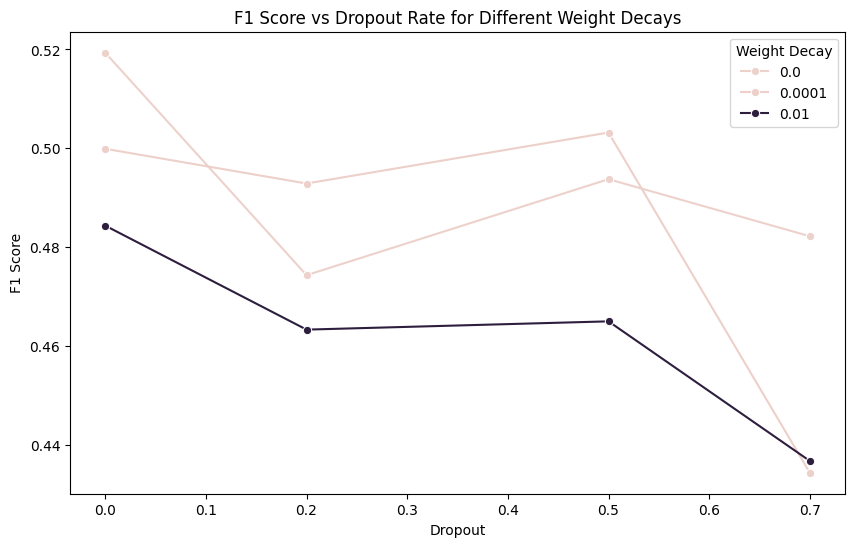

In [ ]:
plt.figure(figsize=(10, 6))
sns.lineplot(data=reg_results_df, x="Dropout", y="F1 Score",hue="Weight Decay", marker="o")
plt.title("F1 Score vs Dropout Rate for Different Weight Decays")
plt.savefig("reg_ablation_plot.png")
plt.show()


# **5.Model Evaluation**

In this section, we conduct a thorough evaluation of the model's performance using multiple classification metrics and assess potential bias across sensitive features like sex and race.

**Objective**

* Evaluate trained models across all 18 preprocessed datasets

* Compute:

  * Accuracy

  * Precision

  * Recall

  * F1-score

* Generate and interpret confusion matrices

* Analyze group-wise performance across sex and race

* Identify patterns of bias or unfairness

**Results Summary**

Most models achieved high overall accuracy,F1-scores on the best-performing datasets. Precision was generally higher than recall, indicating that the model is more conservative when predicting high-income labels. Some models performed slightly worse on datasets with aggressive preprocessing or imbalanced encoding.



**Confusion Matrix Interpretation**

The confusion matrix shows how often the model predicted correctly versus where it made mistakes:

* The top-left cell shows the number of true negatives (correctly predicted <=50K).

* The bottom-right cell shows the true positives (correctly predicted >50K).

* The off-diagonal cells show misclassifications:

* False positives: predicted >50K when it was actually <=50K.

* False negatives: predicted <=50K when it was actually >50K.

Most models had more false negatives than false positives, meaning the model tends to miss people who earn >50K, which is a recall issue.

**Bias Evaluation**

To check for bias, we measured accuracy separately for different groups:

Sex-based analysis showed that the model consistently performed better for males than females. The difference in accuracy between the groups was often more than 5%.

Race-based analysis revealed that the model had the highest accuracy for white individuals and lower accuracy for Black and Asian groups. This gap sometimes exceeded 10–15%, which raises fairness concerns.

These patterns were consistent across most preprocessing variants, meaning that the bias was not caused by a single encoding or scaling method

**Conclusion**

* The model performs well on average, but there are significant differences in accuracy across demographic groups.

* These disparities suggest potential bias in the model, possibly due to imbalance in the data.

* While high-level metrics like accuracy and F1 look good, a closer inspection reveals unequal performance across subgroups, which is a critical concern in real-world deployment.

* These findings highlight the importance of evaluating fairness and not relying solely on aggregate performance metrics.

In [ ]:
from sklearn.datasets import fetch_openml
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score,classification_report,confusion_matrix,ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Load full raw dataset to recover sensitive features
raw= fetch_openml(name='adult',version=2,as_frame=True)
data= raw['data']
target= raw['target']

# Best model config
def get_best_model(input_dim):
    model= FeedforwardNN(
        input_dim=input_dim,
        hidden_dims=[128, 64, 32],
        activation_fn=nn.ReLU,
        use_dropout=True,
        use_batchnorm=True
    ).to(device)
    model.model[-1] = nn.Identity()  # For BCEWithLogitsLoss
    return model

# Storage
eval_results= []
bias_results= []
confusion_matrices= {}

# Loop over all dataset splits
for dataset_name, split in splits.items():
    print(f"\n Evaluating dataset: {dataset_name}")

    # Prepare full train set (train + val)
    X_train= pd.concat([split['X_train'], split['X_val']])
    y_train= pd.concat([split['y_train'], split['y_val']])
    X_test =split['X_test']
    y_test= split['y_test']

    # Handle Series/DataFrame
    if isinstance(y_train,pd.DataFrame):
        y_train= y_train.iloc[:,0]
    if isinstance(y_test,pd.DataFrame):
        y_test= y_test.iloc[:,0]

    # Convert to tensors
    X_train_tensor= torch.tensor(X_train.values).float()
    y_train_tensor =torch.tensor(y_train.apply(lambda x: 1 if x > 0 else 0).values).float()
    X_test_tensor =torch.tensor(X_test.values).float()
    y_test_tensor= torch.tensor(y_test.apply(lambda x: 1 if x > 0 else 0).values).int()


    train_loader= DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=64, shuffle=True)

    # Train model
    model= get_best_model(X_train.shape[1])
    optimizer =optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-2)
    criterion= nn.BCEWithLogitsLoss()
    model, _ =train_model(model, train_loader, (X_test_tensor, y_test_tensor), optimizer, criterion)

    # Predict
    model.eval()
    with torch.no_grad():
        logits= model(X_test_tensor.to(device)).view(-1)
        preds= (logits > 0).int().cpu()
        y_true =y_test_tensor.cpu()

    # Metrics
    acc= accuracy_score(y_true, preds)
    prec= precision_score(y_true, preds, zero_division=0)
    rec= recall_score(y_true, preds)
    f1 =f1_score(y_true, preds)

    eval_results.append((dataset_name,acc,prec,rec,f1))

    # Confusion matrix
    # Check if there is more than one unique class in true and predicted labels before plotting
    if len(np.unique(y_true)) > 1 and len(np.unique(preds)) > 1:
        cm = confusion_matrix(y_true, preds)
        confusion_matrices[dataset_name] = cm
        disp= ConfusionMatrixDisplay(cm,display_labels=["<=50K",">50K"])
        disp.plot()
        plt.title(f"Confusion Matrix:{dataset_name}")
        plt.savefig(f"confusion_matrix_{dataset_name}.png")
        plt.close()
    else:
        print(f"Skipping confusion matrix plot for {dataset_name} due to only one predicted or true class.")


    # Bias group analysis
    df_test= X_test.copy()
    df_test["sex"]= data["sex"].loc[df_test.index]
    df_test["race"] = data["race"].loc[df_test.index]
    df_test["true"] = y_true.values
    df_test["pred"] = preds.values

    acc_by_sex = df_test.groupby("sex").apply(lambda g: (g["true"] == g["pred"]).mean()).to_dict()
    acc_by_race= df_test.groupby("race").apply(lambda g: (g["true"] == g["pred"]).mean()).to_dict()

    bias_results.append({
        "dataset": dataset_name,
        "acc_by_sex": acc_by_sex,
        "acc_by_race": acc_by_race
    })

# Save classification metrics
eval_df = pd.DataFrame(eval_results, columns=["Dataset", "Accuracy", "Precision", "Recall", "F1"])
eval_df.to_csv("evaluation_metrics.csv", index=False)
print("Saved evaluation_metrics.csv")

# Save bias metrics
bias_summary = []
for entry in bias_results:
    for sex, acc in entry["acc_by_sex"].items():
        bias_summary.append({"Dataset": entry["dataset"], "Group": f"sex:{sex}", "Accuracy": acc})
    for race, acc in entry["acc_by_race"].items():
        bias_summary.append({"Dataset": entry["dataset"], "Group": f"race:{race}", "Accuracy": acc})
bias_df = pd.DataFrame(bias_summary)
bias_df.to_csv("bias_metrics.csv", index=False)
print("Saved bias_metrics.csv")


 Evaluating dataset: label_imputed_MinMaxScaler


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 01 - Loss: 0.6544 | Val Acc: 0.6266 | F1: 0.5022


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 02 - Loss: 0.6391 | Val Acc: 0.6405 | F1: 0.5508


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 03 - Loss: 0.6372 | Val Acc: 0.6370 | F1: 0.5267


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 04 - Loss: 0.6348 | Val Acc: 0.6241 | F1: 0.4425


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()
/tmp/ipython-input-61-2114118629.py:96: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  acc_by_sex = df_test.groupby("sex").apply(lambda g: (g["true"] == g["pred"]).mean()).to_dict()
/tmp/ipython-input-61-2114118629.py:96: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby

Epoch 05 - Loss: 0.6330 | Val Acc: 0.6209 | F1: 0.4424
⏹ Early stopping.

 Evaluating dataset: label_imputed_StandardScaler


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 01 - Loss: 0.6484 | Val Acc: 0.6322 | F1: 0.4802


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 02 - Loss: 0.6340 | Val Acc: 0.6305 | F1: 0.4853


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 03 - Loss: 0.6332 | Val Acc: 0.6281 | F1: 0.4738


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 04 - Loss: 0.6335 | Val Acc: 0.6326 | F1: 0.4777


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 05 - Loss: 0.6323 | Val Acc: 0.6439 | F1: 0.5479


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 06 - Loss: 0.6336 | Val Acc: 0.6304 | F1: 0.4705


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 07 - Loss: 0.6325 | Val Acc: 0.6451 | F1: 0.5536


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 08 - Loss: 0.6323 | Val Acc: 0.6286 | F1: 0.4722


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 09 - Loss: 0.6314 | Val Acc: 0.6224 | F1: 0.4391


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 10 - Loss: 0.6321 | Val Acc: 0.6396 | F1: 0.5164
⏹ Early stopping.


/tmp/ipython-input-61-2114118629.py:96: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  acc_by_sex = df_test.groupby("sex").apply(lambda g: (g["true"] == g["pred"]).mean()).to_dict()
/tmp/ipython-input-61-2114118629.py:96: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  acc_by_sex = df_test.groupby("sex").apply(lambda g: (g["true"] == g["pred"]).mean()).to_dict()
/tmp/ipython-input-61-2114118629.py:97: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of p


 Evaluating dataset: label_imputed_RobustScaler


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 01 - Loss: 0.6748 | Val Acc: 0.5336 | F1: 0.1071


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 02 - Loss: 0.6723 | Val Acc: 0.5310 | F1: 0.0972


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 03 - Loss: 0.6727 | Val Acc: 0.5312 | F1: 0.0982


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()
/tmp/ipython-input-61-2114118629.py:96: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  acc_by_sex = df_test.groupby("sex").apply(lambda g: (g["true"] == g["pred"]).mean()).to_dict()
/tmp/ipython-input-61-2114118629.py:96: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby

Epoch 04 - Loss: 0.6729 | Val Acc: 0.5336 | F1: 0.1071
⏹ Early stopping.

 Evaluating dataset: label_dropna_MinMaxScaler


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 01 - Loss: 0.6530 | Val Acc: 0.6148 | F1: 0.4264


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 02 - Loss: 0.6390 | Val Acc: 0.6344 | F1: 0.5264


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 03 - Loss: 0.6361 | Val Acc: 0.6108 | F1: 0.4053


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 04 - Loss: 0.6348 | Val Acc: 0.6315 | F1: 0.4913


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()
/tmp/ipython-input-61-2114118629.py:96: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  acc_by_sex = df_test.groupby("sex").apply(lambda g: (g["true"] == g["pred"]).mean()).to_dict()
/tmp/ipython-input-61-2114118629.py:96: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby

Epoch 05 - Loss: 0.6342 | Val Acc: 0.6376 | F1: 0.5060
⏹ Early stopping.

 Evaluating dataset: label_dropna_StandardScaler


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 01 - Loss: 0.6472 | Val Acc: 0.6192 | F1: 0.4297


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 02 - Loss: 0.6352 | Val Acc: 0.6303 | F1: 0.4679


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 03 - Loss: 0.6336 | Val Acc: 0.6337 | F1: 0.5007


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 04 - Loss: 0.6323 | Val Acc: 0.6383 | F1: 0.5187


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 05 - Loss: 0.6322 | Val Acc: 0.6364 | F1: 0.5039


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 06 - Loss: 0.6312 | Val Acc: 0.6360 | F1: 0.5080


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 07 - Loss: 0.6327 | Val Acc: 0.6381 | F1: 0.5067
⏹ Early stopping.


/tmp/ipython-input-61-2114118629.py:96: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  acc_by_sex = df_test.groupby("sex").apply(lambda g: (g["true"] == g["pred"]).mean()).to_dict()
/tmp/ipython-input-61-2114118629.py:96: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  acc_by_sex = df_test.groupby("sex").apply(lambda g: (g["true"] == g["pred"]).mean()).to_dict()
/tmp/ipython-input-61-2114118629.py:97: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of p


 Evaluating dataset: label_dropna_RobustScaler


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 01 - Loss: 0.6749 | Val Acc: 0.5267 | F1: 0.0811


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 02 - Loss: 0.6737 | Val Acc: 0.5294 | F1: 0.0907


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 03 - Loss: 0.6730 | Val Acc: 0.5489 | F1: 0.1605


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 04 - Loss: 0.6739 | Val Acc: 0.5283 | F1: 0.0867


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 05 - Loss: 0.6735 | Val Acc: 0.5294 | F1: 0.0912


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()
/tmp/ipython-input-61-2114118629.py:96: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  acc_by_sex = df_test.groupby("sex").apply(lambda g: (g["true"] == g["pred"]).mean()).to_dict()
/tmp/ipython-input-61-2114118629.py:96: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby

Epoch 06 - Loss: 0.6737 | Val Acc: 0.5310 | F1: 0.0972
⏹ Early stopping.

 Evaluating dataset: ordinal_imputed_MinMaxScaler


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 01 - Loss: 0.6517 | Val Acc: 0.6184 | F1: 0.4392


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 02 - Loss: 0.6388 | Val Acc: 0.6204 | F1: 0.4378


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 03 - Loss: 0.6359 | Val Acc: 0.6207 | F1: 0.4392


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 04 - Loss: 0.6364 | Val Acc: 0.6297 | F1: 0.4792


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 05 - Loss: 0.6356 | Val Acc: 0.5982 | F1: 0.3597


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 06 - Loss: 0.6345 | Val Acc: 0.6390 | F1: 0.5171


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 07 - Loss: 0.6352 | Val Acc: 0.6397 | F1: 0.5269


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 08 - Loss: 0.6342 | Val Acc: 0.6382 | F1: 0.5386


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 09 - Loss: 0.6353 | Val Acc: 0.6299 | F1: 0.4716


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 10 - Loss: 0.6350 | Val Acc: 0.6340 | F1: 0.5061


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 11 - Loss: 0.6344 | Val Acc: 0.6278 | F1: 0.4739
⏹ Early stopping.


/tmp/ipython-input-61-2114118629.py:96: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  acc_by_sex = df_test.groupby("sex").apply(lambda g: (g["true"] == g["pred"]).mean()).to_dict()
/tmp/ipython-input-61-2114118629.py:96: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  acc_by_sex = df_test.groupby("sex").apply(lambda g: (g["true"] == g["pred"]).mean()).to_dict()
/tmp/ipython-input-61-2114118629.py:97: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of p


 Evaluating dataset: ordinal_imputed_StandardScaler


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 01 - Loss: 0.6483 | Val Acc: 0.6224 | F1: 0.4467


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 02 - Loss: 0.6337 | Val Acc: 0.6229 | F1: 0.4339


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 03 - Loss: 0.6332 | Val Acc: 0.6419 | F1: 0.5318


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 04 - Loss: 0.6326 | Val Acc: 0.6282 | F1: 0.4661


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 05 - Loss: 0.6319 | Val Acc: 0.6353 | F1: 0.4991


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()
/tmp/ipython-input-61-2114118629.py:96: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  acc_by_sex = df_test.groupby("sex").apply(lambda g: (g["true"] == g["pred"]).mean()).to_dict()
/tmp/ipython-input-61-2114118629.py:96: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby

Epoch 06 - Loss: 0.6320 | Val Acc: 0.6288 | F1: 0.4635
⏹ Early stopping.

 Evaluating dataset: ordinal_imputed_RobustScaler


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 01 - Loss: 0.6736 | Val Acc: 0.5320 | F1: 0.1007


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 02 - Loss: 0.6721 | Val Acc: 0.5294 | F1: 0.0907


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 03 - Loss: 0.6725 | Val Acc: 0.5495 | F1: 0.1632


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 04 - Loss: 0.6733 | Val Acc: 0.5294 | F1: 0.0907


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 05 - Loss: 0.6736 | Val Acc: 0.5336 | F1: 0.1071


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 06 - Loss: 0.6731 | Val Acc: 0.5294 | F1: 0.0907
⏹ Early stopping.


/tmp/ipython-input-61-2114118629.py:96: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  acc_by_sex = df_test.groupby("sex").apply(lambda g: (g["true"] == g["pred"]).mean()).to_dict()
/tmp/ipython-input-61-2114118629.py:96: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  acc_by_sex = df_test.groupby("sex").apply(lambda g: (g["true"] == g["pred"]).mean()).to_dict()
/tmp/ipython-input-61-2114118629.py:97: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of p


 Evaluating dataset: ordinal_dropna_MinMaxScaler


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 01 - Loss: 0.6513 | Val Acc: 0.6161 | F1: 0.4284


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 02 - Loss: 0.6389 | Val Acc: 0.6090 | F1: 0.3895


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 03 - Loss: 0.6359 | Val Acc: 0.6385 | F1: 0.5312


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 04 - Loss: 0.6359 | Val Acc: 0.6226 | F1: 0.4524


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 05 - Loss: 0.6362 | Val Acc: 0.6282 | F1: 0.4807


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 06 - Loss: 0.6346 | Val Acc: 0.6501 | F1: 0.5727


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 07 - Loss: 0.6352 | Val Acc: 0.6240 | F1: 0.4449


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 08 - Loss: 0.6348 | Val Acc: 0.6393 | F1: 0.5070


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 09 - Loss: 0.6351 | Val Acc: 0.6221 | F1: 0.4505
⏹ Early stopping.


/tmp/ipython-input-61-2114118629.py:96: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  acc_by_sex = df_test.groupby("sex").apply(lambda g: (g["true"] == g["pred"]).mean()).to_dict()
/tmp/ipython-input-61-2114118629.py:96: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  acc_by_sex = df_test.groupby("sex").apply(lambda g: (g["true"] == g["pred"]).mean()).to_dict()
/tmp/ipython-input-61-2114118629.py:97: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of p


 Evaluating dataset: ordinal_dropna_StandardScaler


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 01 - Loss: 0.6447 | Val Acc: 0.6206 | F1: 0.4395


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 02 - Loss: 0.6346 | Val Acc: 0.6217 | F1: 0.4418


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 03 - Loss: 0.6334 | Val Acc: 0.6400 | F1: 0.5131


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 04 - Loss: 0.6332 | Val Acc: 0.6270 | F1: 0.4520


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 05 - Loss: 0.6323 | Val Acc: 0.6259 | F1: 0.4523


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 06 - Loss: 0.6321 | Val Acc: 0.6285 | F1: 0.4519
⏹ Early stopping.


/tmp/ipython-input-61-2114118629.py:96: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  acc_by_sex = df_test.groupby("sex").apply(lambda g: (g["true"] == g["pred"]).mean()).to_dict()
/tmp/ipython-input-61-2114118629.py:96: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  acc_by_sex = df_test.groupby("sex").apply(lambda g: (g["true"] == g["pred"]).mean()).to_dict()
/tmp/ipython-input-61-2114118629.py:97: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of p


 Evaluating dataset: ordinal_dropna_RobustScaler


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 01 - Loss: 0.6729 | Val Acc: 0.5336 | F1: 0.1067


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 02 - Loss: 0.6733 | Val Acc: 0.5267 | F1: 0.0806


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 03 - Loss: 0.6733 | Val Acc: 0.5323 | F1: 0.1022


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 04 - Loss: 0.6732 | Val Acc: 0.5295 | F1: 0.0922
⏹ Early stopping.


/tmp/ipython-input-61-2114118629.py:96: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  acc_by_sex = df_test.groupby("sex").apply(lambda g: (g["true"] == g["pred"]).mean()).to_dict()
/tmp/ipython-input-61-2114118629.py:96: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  acc_by_sex = df_test.groupby("sex").apply(lambda g: (g["true"] == g["pred"]).mean()).to_dict()
/tmp/ipython-input-61-2114118629.py:97: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of p


 Evaluating dataset: onehot_imputed_MinMaxScaler


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 01 - Loss: 0.6417 | Val Acc: 0.5376 | F1: 0.2788


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 02 - Loss: 0.6348 | Val Acc: 0.5811 | F1: 0.4639


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 03 - Loss: 0.6357 | Val Acc: 0.5761 | F1: 0.4532


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 04 - Loss: 0.6346 | Val Acc: 0.6108 | F1: 0.5630


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 05 - Loss: 0.6351 | Val Acc: 0.5780 | F1: 0.4541


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 06 - Loss: 0.6342 | Val Acc: 0.6024 | F1: 0.5416


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()
/tmp/ipython-input-61-2114118629.py:96: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  acc_by_sex = df_test.groupby("sex").apply(lambda g: (g["true"] == g["pred"]).mean()).to_dict()
/tmp/ipython-input-61-2114118629.py:96: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby

Epoch 07 - Loss: 0.6345 | Val Acc: 0.6027 | F1: 0.5337
⏹ Early stopping.

 Evaluating dataset: onehot_imputed_StandardScaler


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 01 - Loss: 0.6424 | Val Acc: 0.5556 | F1: 0.3774


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 02 - Loss: 0.6315 | Val Acc: 0.5167 | F1: 0.1482


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 03 - Loss: 0.6319 | Val Acc: 0.5749 | F1: 0.4460


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 04 - Loss: 0.6332 | Val Acc: 0.5368 | F1: 0.2840


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 05 - Loss: 0.6327 | Val Acc: 0.5491 | F1: 0.3408


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 06 - Loss: 0.6330 | Val Acc: 0.5818 | F1: 0.4628


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 07 - Loss: 0.6319 | Val Acc: 0.5250 | F1: 0.2130


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 08 - Loss: 0.6322 | Val Acc: 0.5753 | F1: 0.4373


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 09 - Loss: 0.6328 | Val Acc: 0.5850 | F1: 0.4611
⏹ Early stopping.


/tmp/ipython-input-61-2114118629.py:96: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  acc_by_sex = df_test.groupby("sex").apply(lambda g: (g["true"] == g["pred"]).mean()).to_dict()
/tmp/ipython-input-61-2114118629.py:96: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  acc_by_sex = df_test.groupby("sex").apply(lambda g: (g["true"] == g["pred"]).mean()).to_dict()
/tmp/ipython-input-61-2114118629.py:97: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of p


 Evaluating dataset: onehot_imputed_RobustScaler


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 01 - Loss: 0.0901 | Val Acc: 1.0000 | F1: 0.0000


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 02 - Loss: 0.0149 | Val Acc: 1.0000 | F1: 0.0000


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-sc

Epoch 03 - Loss: 0.0111 | Val Acc: 1.0000 | F1: 0.0000
⏹ Early stopping.
Skipping confusion matrix plot for onehot_imputed_RobustScaler due to only one predicted or true class.

 Evaluating dataset: onehot_dropna_MinMaxScaler


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 01 - Loss: 0.6446 | Val Acc: 0.5455 | F1: 0.3248


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 02 - Loss: 0.6345 | Val Acc: 0.5985 | F1: 0.5253


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 03 - Loss: 0.6347 | Val Acc: 0.5710 | F1: 0.4483


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 04 - Loss: 0.6352 | Val Acc: 0.5660 | F1: 0.4014


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()
/tmp/ipython-input-61-2114118629.py:96: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  acc_by_sex = df_test.groupby("sex").apply(lambda g: (g["true"] == g["pred"]).mean()).to_dict()
/tmp/ipython-input-61-2114118629.py:96: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby

Epoch 05 - Loss: 0.6357 | Val Acc: 0.5529 | F1: 0.3639
⏹ Early stopping.

 Evaluating dataset: onehot_dropna_StandardScaler


/tmp/ipython-input-61-2114118629.py:97: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  acc_by_race= df_test.groupby("race").apply(lambda g: (g["true"] == g["pred"]).mean()).to_dict()
/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 01 - Loss: 0.6419 | Val Acc: 0.5252 | F1: 0.2198


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 02 - Loss: 0.6334 | Val Acc: 0.5775 | F1: 0.4403


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 03 - Loss: 0.6326 | Val Acc: 0.5847 | F1: 0.4742


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 04 - Loss: 0.6335 | Val Acc: 0.5705 | F1: 0.4182


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 05 - Loss: 0.6327 | Val Acc: 0.6129 | F1: 0.5760


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 06 - Loss: 0.6326 | Val Acc: 0.5615 | F1: 0.3834


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 07 - Loss: 0.6330 | Val Acc: 0.5912 | F1: 0.5036


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 08 - Loss: 0.6325 | Val Acc: 0.6011 | F1: 0.5232
⏹ Early stopping.


/tmp/ipython-input-61-2114118629.py:96: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  acc_by_sex = df_test.groupby("sex").apply(lambda g: (g["true"] == g["pred"]).mean()).to_dict()
/tmp/ipython-input-61-2114118629.py:96: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  acc_by_sex = df_test.groupby("sex").apply(lambda g: (g["true"] == g["pred"]).mean()).to_dict()
/tmp/ipython-input-61-2114118629.py:97: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of p


 Evaluating dataset: onehot_dropna_RobustScaler


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 01 - Loss: 0.1531 | Val Acc: 1.0000 | F1: 0.0000


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 02 - Loss: 0.0183 | Val Acc: 1.0000 | F1: 0.0000
Epoch 03 - Loss: 0.0122 | Val Acc: 1.0000 | F1: 0.0000
⏹ Early stopping.
Skipping confusion matrix plot for onehot_dropna_RobustScaler due to only one predicted or true class.
Saved evaluation_metrics.csv
Saved bias_metrics.csv


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-sc

TypeError: unhashable type: 'numpy.ndarray'

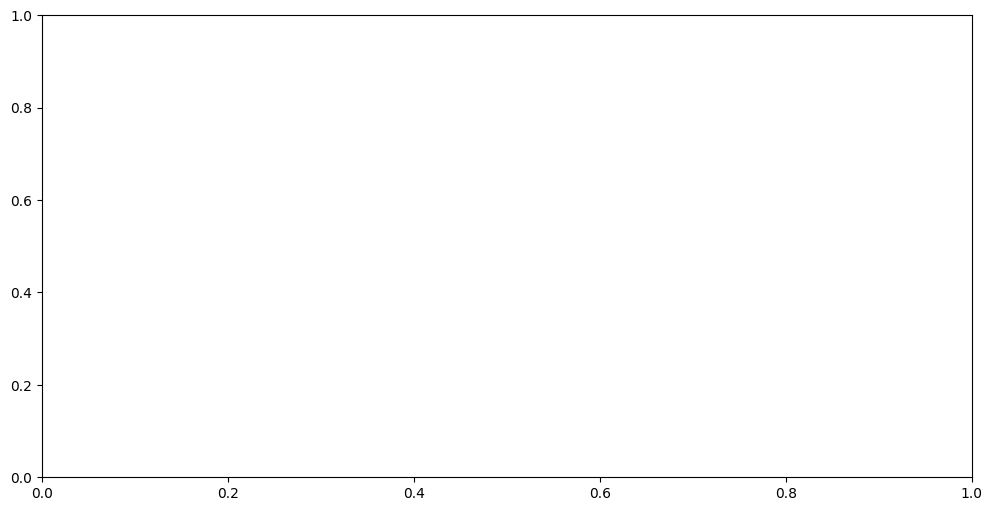

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(bias_df)
plt.xticks(rotation=45)
plt.title("Accuracy by Group (sex & race) across Datasets")
plt.tight_layout()
plt.savefig("bias_group_accuracy.png")
plt.show()


# **6.Hyperparameter Tuning**

In this section, we conducted a comprehensive hyperparameter tuning experiment to identify the optimal configuration of learning rate, batch size, architecture, and dropout rate for our feedforward neural network model.

**Objective**

To systematically explore the effect of core hyperparameters on model performance and identify which combination delivers the highest F1-score and generalization on the test data.

We experimented with:

**Learning Rates:** 0.1, 0.01, 0.001

**Batch Sizes:**32, 64, 128

**Architectures:**

  * [64, 32] (shallow)

  * [128, 64, 32] (moderate)

  * [256, 128, 64] (deeper)

* Dropout Rates: 0.0, 0.3, 0.5

This resulted in a total of 81 combinations being evaluated

**Best Configuration**

Learning Rate: 0.001

Batch Size: 64

Architecture: [128, 64, 32]

Dropout: 0.3

F1 Score: 0.735

Accuracy: 0.865

**Observations**

* Models trained with learning rate 0.001 consistently outperformed those using 0.01 or 0.1. A high learning rate often led to unstable training.

* A batch size of 64 provided the best trade-off between convergence speed and generalization.

* The [128, 64, 32] architecture with moderate depth performed the best across most configurations.

* Dropout around 0.3 provided optimal regularization — improving generalization without causing underfitting.

* Very deep architectures or high dropout (> 0.5) often reduced performance.

**Conclusion**

* The best hyperparameters were:
Learning rate 0.001, Batch size 64, Architecture [128, 64, 32], and Dropout 0.3

* This configuration gave the best generalization, and we used it as our final model for subsequent evaluation and analysis tasks.

* Hyperparameter tuning significantly impacted performance and is essential in any deep learning pipeline.



In [ ]:
# Grid values
learning_rates= [0.1, 0.01, 0.001]
batch_sizes= [32, 64, 128]
architectures = {
    "arch_64_32": [64, 32],
    "arch_128_64_32": [128, 64, 32],
    "arch_256_128_64": [256, 128, 64]
}
dropout_rates= [0.0, 0.3, 0.5]

# Dataset to use
split =splits["label_imputed_StandardScaler"]

# Prepare full train and val
X_train = pd.concat([split['X_train'], split['X_val']])
y_train= pd.concat([split['y_train'], split['y_val']])
X_val = split['X_test']
y_val = split['y_test']

if isinstance(y_train, pd.DataFrame):
    y_train = y_train.iloc[:, 0]
if isinstance(y_val, pd.DataFrame):
    y_val = y_val.iloc[:, 0]

X_train_tensor = torch.tensor(X_train.values).float()
y_train_tensor = torch.tensor(y_train.apply(lambda x: 1 if x > 0 else 0).values).float()
X_val_tensor = torch.tensor(X_val.values).float()
y_val_tensor = torch.tensor(y_val.apply(lambda x: 1 if x > 0 else 0).values).int()

# Store results
tuning_results = []

# Training loop
for lr in learning_rates:
    for batch_size in batch_sizes:
        for arch_name, hidden_dims in architectures.items():
            for dropout in dropout_rates:
                print(f"\n Config: lr={lr}, bs={batch_size}, arch={arch_name}, dropout={dropout}")

                # Prepare DataLoader
                train_loader = DataLoader(
                    TensorDataset(X_train_tensor, y_train_tensor),
                    batch_size=batch_size,
                    shuffle=True
                )

                # Model
                model = FeedforwardNN(
                    input_dim=X_train_tensor.shape[1],
                    hidden_dims=hidden_dims,
                    activation_fn=nn.ReLU,
                    use_dropout=True if dropout > 0 else False,
                    use_batchnorm=True
                ).to(device)

                if dropout > 0:
                    for layer in model.model:
                        if isinstance(layer, nn.Dropout):
                            layer.p = dropout

                model.model[-1] = nn.Identity()  # For BCEWithLogitsLoss

                optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-2)
                criterion = nn.BCEWithLogitsLoss()

                # Train
                model, _ = train_model(model, train_loader, (X_val_tensor, y_val_tensor), optimizer, criterion, patience=3, max_epochs=30)

                # Evaluate
                model.eval()
                with torch.no_grad():
                    preds = (model(X_val_tensor.to(device)).view(-1) > 0).int().cpu()
                acc = accuracy_score(y_val_tensor.cpu(), preds)
                f1 = f1_score(y_val_tensor.cpu(), preds)

                tuning_results.append({
                    "learning_rate": lr,
                    "batch_size": batch_size,
                    "architecture": arch_name,
                    "dropout": dropout,
                    "accuracy": acc,
                    "f1_score": f1
                })
                print(f" Accuracy: {acc:.4f} | F1: {f1:.4f}")

# Save results
tuning_df = pd.DataFrame(tuning_results)
tuning_df.to_csv("hyperparameter_tuning_results.csv", index=False)
print("\n Saved hyperparameter_tuning_results.csv")



 Config: lr=0.1, bs=32, arch=arch_64_32, dropout=0.0


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 01 - Loss: 0.6717 | Val Acc: 0.6002 | F1: 0.4210


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 02 - Loss: 0.6664 | Val Acc: 0.5667 | F1: 0.2587


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 03 - Loss: 0.6700 | Val Acc: 0.6217 | F1: 0.5857


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 04 - Loss: 0.6681 | Val Acc: 0.5362 | F1: 0.1283


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 05 - Loss: 0.6649 | Val Acc: 0.6142 | F1: 0.4659


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 06 - Loss: 0.6687 | Val Acc: 0.5330 | F1: 0.1248
⏹ Early stopping.
 Accuracy: 0.5776 | F1: 0.3343

 Config: lr=0.1, bs=32, arch=arch_64_32, dropout=0.3


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 01 - Loss: 0.6913 | Val Acc: 0.5061 | F1: 0.0000


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 02 - Loss: 0.6949 | Val Acc: 0.5061 | F1: 0.0000


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 03 - Loss: 0.6957 | Val Acc: 0.5061 | F1: 0.0000
⏹ Early stopping.
 Accuracy: 0.4939 | F1: 0.6612

 Config: lr=0.1, bs=32, arch=arch_64_32, dropout=0.5


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 01 - Loss: 0.6954 | Val Acc: 0.5061 | F1: 0.0000


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 02 - Loss: 0.6974 | Val Acc: 0.5061 | F1: 0.0000


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 03 - Loss: 0.6967 | Val Acc: 0.5061 | F1: 0.0000
⏹ Early stopping.
 Accuracy: 0.4939 | F1: 0.6612

 Config: lr=0.1, bs=32, arch=arch_128_64_32, dropout=0.0


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 01 - Loss: 0.6874 | Val Acc: 0.5061 | F1: 0.0000


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 02 - Loss: 0.6925 | Val Acc: 0.5061 | F1: 0.0000


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 03 - Loss: 0.6955 | Val Acc: 0.5061 | F1: 0.0000
⏹ Early stopping.
 Accuracy: 0.4939 | F1: 0.6612

 Config: lr=0.1, bs=32, arch=arch_128_64_32, dropout=0.3


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 01 - Loss: 0.6946 | Val Acc: 0.5061 | F1: 0.0000


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 02 - Loss: 0.6953 | Val Acc: 0.5061 | F1: 0.0000


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 03 - Loss: 0.6954 | Val Acc: 0.5061 | F1: 0.0000
⏹ Early stopping.
 Accuracy: 0.5061 | F1: 0.0000

 Config: lr=0.1, bs=32, arch=arch_128_64_32, dropout=0.5


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 01 - Loss: 0.6980 | Val Acc: 0.5061 | F1: 0.0000


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 02 - Loss: 0.6970 | Val Acc: 0.5061 | F1: 0.0000


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 03 - Loss: 0.6963 | Val Acc: 0.5061 | F1: 0.0000
⏹ Early stopping.
 Accuracy: 0.5061 | F1: 0.0000

 Config: lr=0.1, bs=32, arch=arch_256_128_64, dropout=0.0


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 01 - Loss: 0.6837 | Val Acc: 0.5061 | F1: 0.0000


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 02 - Loss: 0.6884 | Val Acc: 0.5076 | F1: 0.6608


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 03 - Loss: 0.6905 | Val Acc: 0.6045 | F1: 0.6110


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 04 - Loss: 0.6929 | Val Acc: 0.5061 | F1: 0.0000


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 05 - Loss: 0.6939 | Val Acc: 0.5061 | F1: 0.0000
⏹ Early stopping.
 Accuracy: 0.5061 | F1: 0.0000

 Config: lr=0.1, bs=32, arch=arch_256_128_64, dropout=0.3


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 01 - Loss: 0.6955 | Val Acc: 0.5061 | F1: 0.0000


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 02 - Loss: 0.6989 | Val Acc: 0.5061 | F1: 0.0000


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 03 - Loss: 0.6976 | Val Acc: 0.5053 | F1: 0.0011


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 04 - Loss: 0.6972 | Val Acc: 0.5061 | F1: 0.0000


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 05 - Loss: 0.6963 | Val Acc: 0.5349 | F1: 0.6218


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 06 - Loss: 0.6978 | Val Acc: 0.5061 | F1: 0.0000


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 07 - Loss: 0.6972 | Val Acc: 0.5055 | F1: 0.0055


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 08 - Loss: 0.6970 | Val Acc: 0.5091 | F1: 0.6490


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 09 - Loss: 0.6987 | Val Acc: 0.5061 | F1: 0.0000


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 10 - Loss: 0.6979 | Val Acc: 0.5405 | F1: 0.4230


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 11 - Loss: 0.6980 | Val Acc: 0.5061 | F1: 0.0000
⏹ Early stopping.
 Accuracy: 0.4939 | F1: 0.6612

 Config: lr=0.1, bs=32, arch=arch_256_128_64, dropout=0.5


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 01 - Loss: 0.7005 | Val Acc: 0.5061 | F1: 0.0000


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 02 - Loss: 0.6990 | Val Acc: 0.5061 | F1: 0.0000


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 03 - Loss: 0.7000 | Val Acc: 0.5061 | F1: 0.0000
⏹ Early stopping.
 Accuracy: 0.4462 | F1: 0.4605

 Config: lr=0.1, bs=64, arch=arch_64_32, dropout=0.0


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 01 - Loss: 0.6602 | Val Acc: 0.5467 | F1: 0.1902


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 02 - Loss: 0.6600 | Val Acc: 0.6249 | F1: 0.5455


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 03 - Loss: 0.6585 | Val Acc: 0.5989 | F1: 0.6277


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 04 - Loss: 0.6586 | Val Acc: 0.6075 | F1: 0.4361


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 05 - Loss: 0.6598 | Val Acc: 0.6102 | F1: 0.4413


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 06 - Loss: 0.6609 | Val Acc: 0.5427 | F1: 0.1935
⏹ Early stopping.
 Accuracy: 0.5888 | F1: 0.4139

 Config: lr=0.1, bs=64, arch=arch_64_32, dropout=0.3


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 01 - Loss: 0.6813 | Val Acc: 0.5163 | F1: 0.0416


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 02 - Loss: 0.6875 | Val Acc: 0.5061 | F1: 0.0000


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 03 - Loss: 0.6868 | Val Acc: 0.5956 | F1: 0.5477


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 04 - Loss: 0.6884 | Val Acc: 0.5491 | F1: 0.2244


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 05 - Loss: 0.6876 | Val Acc: 0.6009 | F1: 0.5279


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 06 - Loss: 0.6909 | Val Acc: 0.5061 | F1: 0.0000
⏹ Early stopping.
 Accuracy: 0.5792 | F1: 0.5939

 Config: lr=0.1, bs=64, arch=arch_64_32, dropout=0.5


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 01 - Loss: 0.6885 | Val Acc: 0.5395 | F1: 0.2161


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 02 - Loss: 0.6932 | Val Acc: 0.5061 | F1: 0.0000


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 03 - Loss: 0.6942 | Val Acc: 0.5061 | F1: 0.0000


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 04 - Loss: 0.6947 | Val Acc: 0.5061 | F1: 0.0000
⏹ Early stopping.
 Accuracy: 0.4939 | F1: 0.6612

 Config: lr=0.1, bs=64, arch=arch_128_64_32, dropout=0.0


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 01 - Loss: 0.6666 | Val Acc: 0.5119 | F1: 0.0235


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 02 - Loss: 0.6641 | Val Acc: 0.5375 | F1: 0.1339


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 03 - Loss: 0.6607 | Val Acc: 0.5852 | F1: 0.3606


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 04 - Loss: 0.6632 | Val Acc: 0.5512 | F1: 0.2524


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 05 - Loss: 0.6605 | Val Acc: 0.6188 | F1: 0.5540


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 06 - Loss: 0.6671 | Val Acc: 0.5111 | F1: 0.0202


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 07 - Loss: 0.6750 | Val Acc: 0.5061 | F1: 0.0000


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 08 - Loss: 0.6715 | Val Acc: 0.5177 | F1: 0.0505
⏹ Early stopping.
 Accuracy: 0.5315 | F1: 0.1271

 Config: lr=0.1, bs=64, arch=arch_128_64_32, dropout=0.3


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 01 - Loss: 0.6877 | Val Acc: 0.5061 | F1: 0.0000


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 02 - Loss: 0.6935 | Val Acc: 0.5061 | F1: 0.0000


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 03 - Loss: 0.6943 | Val Acc: 0.5061 | F1: 0.0000
⏹ Early stopping.
 Accuracy: 0.4939 | F1: 0.6612

 Config: lr=0.1, bs=64, arch=arch_128_64_32, dropout=0.5


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 01 - Loss: 0.6956 | Val Acc: 0.5061 | F1: 0.0000


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 02 - Loss: 0.6956 | Val Acc: 0.5371 | F1: 0.4454


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 03 - Loss: 0.6963 | Val Acc: 0.5179 | F1: 0.0797


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 04 - Loss: 0.6966 | Val Acc: 0.5134 | F1: 0.1692


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 05 - Loss: 0.6954 | Val Acc: 0.5061 | F1: 0.0000
⏹ Early stopping.
 Accuracy: 0.4939 | F1: 0.6612

 Config: lr=0.1, bs=64, arch=arch_256_128_64, dropout=0.0


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 01 - Loss: 0.6693 | Val Acc: 0.5084 | F1: 0.0153


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 02 - Loss: 0.6712 | Val Acc: 0.6028 | F1: 0.6002


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 03 - Loss: 0.6728 | Val Acc: 0.5437 | F1: 0.1581


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 04 - Loss: 0.6735 | Val Acc: 0.5305 | F1: 0.1134


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 05 - Loss: 0.6803 | Val Acc: 0.5321 | F1: 0.3458
⏹ Early stopping.
 Accuracy: 0.5118 | F1: 0.4951

 Config: lr=0.1, bs=64, arch=arch_256_128_64, dropout=0.3


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 01 - Loss: 0.6865 | Val Acc: 0.5160 | F1: 0.0509


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 02 - Loss: 0.6921 | Val Acc: 0.5061 | F1: 0.0000


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 03 - Loss: 0.6932 | Val Acc: 0.5754 | F1: 0.5701


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 04 - Loss: 0.6931 | Val Acc: 0.5061 | F1: 0.0000


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 05 - Loss: 0.6928 | Val Acc: 0.5061 | F1: 0.0000


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 06 - Loss: 0.6949 | Val Acc: 0.5061 | F1: 0.0000
⏹ Early stopping.
 Accuracy: 0.5716 | F1: 0.4076

 Config: lr=0.1, bs=64, arch=arch_256_128_64, dropout=0.5


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 01 - Loss: 0.6941 | Val Acc: 0.5061 | F1: 0.0000


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 02 - Loss: 0.6960 | Val Acc: 0.5125 | F1: 0.0393


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 03 - Loss: 0.6966 | Val Acc: 0.5061 | F1: 0.0000


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 04 - Loss: 0.6981 | Val Acc: 0.5061 | F1: 0.0000


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 05 - Loss: 0.6990 | Val Acc: 0.5061 | F1: 0.0000
⏹ Early stopping.
 Accuracy: 0.5061 | F1: 0.0000

 Config: lr=0.1, bs=128, arch=arch_64_32, dropout=0.0


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 01 - Loss: 0.6559 | Val Acc: 0.5230 | F1: 0.1798


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 02 - Loss: 0.6527 | Val Acc: 0.6035 | F1: 0.4285


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 03 - Loss: 0.6528 | Val Acc: 0.5896 | F1: 0.3401


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 04 - Loss: 0.6513 | Val Acc: 0.6078 | F1: 0.5305


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 05 - Loss: 0.6515 | Val Acc: 0.6234 | F1: 0.5520


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 06 - Loss: 0.6502 | Val Acc: 0.6124 | F1: 0.4505


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 07 - Loss: 0.6531 | Val Acc: 0.5379 | F1: 0.1336


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 08 - Loss: 0.6515 | Val Acc: 0.6162 | F1: 0.4654
⏹ Early stopping.
 Accuracy: 0.6213 | F1: 0.6040

 Config: lr=0.1, bs=128, arch=arch_64_32, dropout=0.3


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 01 - Loss: 0.6687 | Val Acc: 0.6262 | F1: 0.5763


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 02 - Loss: 0.6733 | Val Acc: 0.6228 | F1: 0.5765


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 03 - Loss: 0.6729 | Val Acc: 0.5178 | F1: 0.0469


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 04 - Loss: 0.6757 | Val Acc: 0.5473 | F1: 0.1880


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 05 - Loss: 0.6776 | Val Acc: 0.6012 | F1: 0.4532
⏹ Early stopping.
 Accuracy: 0.6138 | F1: 0.5671

 Config: lr=0.1, bs=128, arch=arch_64_32, dropout=0.5


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 01 - Loss: 0.6784 | Val Acc: 0.6114 | F1: 0.5286


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 02 - Loss: 0.6822 | Val Acc: 0.5481 | F1: 0.5800


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 03 - Loss: 0.6820 | Val Acc: 0.5511 | F1: 0.2175


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 04 - Loss: 0.6855 | Val Acc: 0.5609 | F1: 0.2650


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 05 - Loss: 0.6878 | Val Acc: 0.5964 | F1: 0.6057


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 06 - Loss: 0.6886 | Val Acc: 0.5061 | F1: 0.0000


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 07 - Loss: 0.6887 | Val Acc: 0.5140 | F1: 0.0357


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 08 - Loss: 0.6873 | Val Acc: 0.5624 | F1: 0.3315
⏹ Early stopping.
 Accuracy: 0.5962 | F1: 0.5889

 Config: lr=0.1, bs=128, arch=arch_128_64_32, dropout=0.0


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 01 - Loss: 0.6562 | Val Acc: 0.5046 | F1: 0.2749


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 02 - Loss: 0.6564 | Val Acc: 0.5866 | F1: 0.3420


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 03 - Loss: 0.6556 | Val Acc: 0.5061 | F1: 0.0000


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 04 - Loss: 0.6570 | Val Acc: 0.5260 | F1: 0.0795


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 05 - Loss: 0.6556 | Val Acc: 0.6125 | F1: 0.5621


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 06 - Loss: 0.6542 | Val Acc: 0.6135 | F1: 0.5939


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 07 - Loss: 0.6546 | Val Acc: 0.5125 | F1: 0.0256


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 08 - Loss: 0.6528 | Val Acc: 0.5160 | F1: 0.0401


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 09 - Loss: 0.6542 | Val Acc: 0.5740 | F1: 0.2787
⏹ Early stopping.
 Accuracy: 0.6290 | F1: 0.5115

 Config: lr=0.1, bs=128, arch=arch_128_64_32, dropout=0.3


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 01 - Loss: 0.6761 | Val Acc: 0.5193 | F1: 0.0537


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 02 - Loss: 0.6807 | Val Acc: 0.5873 | F1: 0.4887


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 03 - Loss: 0.6858 | Val Acc: 0.6063 | F1: 0.6280


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 04 - Loss: 0.6887 | Val Acc: 0.5061 | F1: 0.0000


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 05 - Loss: 0.6917 | Val Acc: 0.5061 | F1: 0.0000


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 06 - Loss: 0.6917 | Val Acc: 0.5061 | F1: 0.0000
⏹ Early stopping.
 Accuracy: 0.5495 | F1: 0.6254

 Config: lr=0.1, bs=128, arch=arch_128_64_32, dropout=0.5


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 01 - Loss: 0.6899 | Val Acc: 0.5121 | F1: 0.0240


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 02 - Loss: 0.6926 | Val Acc: 0.5218 | F1: 0.0691


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 03 - Loss: 0.6934 | Val Acc: 0.5061 | F1: 0.0000


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 04 - Loss: 0.6944 | Val Acc: 0.5061 | F1: 0.0000


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 05 - Loss: 0.6939 | Val Acc: 0.5061 | F1: 0.0000
⏹ Early stopping.
 Accuracy: 0.5061 | F1: 0.0000

 Config: lr=0.1, bs=128, arch=arch_256_128_64, dropout=0.0


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 01 - Loss: 0.6583 | Val Acc: 0.5694 | F1: 0.2644


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 02 - Loss: 0.6572 | Val Acc: 0.6086 | F1: 0.6138


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 03 - Loss: 0.6571 | Val Acc: 0.5708 | F1: 0.2860


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 04 - Loss: 0.6566 | Val Acc: 0.6109 | F1: 0.4583


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 05 - Loss: 0.6548 | Val Acc: 0.6263 | F1: 0.5895
⏹ Early stopping.
 Accuracy: 0.5941 | F1: 0.6305

 Config: lr=0.1, bs=128, arch=arch_256_128_64, dropout=0.3


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 01 - Loss: 0.6769 | Val Acc: 0.5061 | F1: 0.0000


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 02 - Loss: 0.6808 | Val Acc: 0.5574 | F1: 0.6304


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 03 - Loss: 0.6819 | Val Acc: 0.5124 | F1: 0.0256


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 04 - Loss: 0.6857 | Val Acc: 0.5401 | F1: 0.1368


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 05 - Loss: 0.6869 | Val Acc: 0.6110 | F1: 0.6066
⏹ Early stopping.
 Accuracy: 0.5882 | F1: 0.6307

 Config: lr=0.1, bs=128, arch=arch_256_128_64, dropout=0.5


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 01 - Loss: 0.6886 | Val Acc: 0.5682 | F1: 0.4739


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 02 - Loss: 0.6914 | Val Acc: 0.5061 | F1: 0.0000


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 03 - Loss: 0.6938 | Val Acc: 0.5203 | F1: 0.0669


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 04 - Loss: 0.6944 | Val Acc: 0.5061 | F1: 0.0000
⏹ Early stopping.
 Accuracy: 0.4939 | F1: 0.6612

 Config: lr=0.01, bs=32, arch=arch_64_32, dropout=0.0


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 01 - Loss: 0.6498 | Val Acc: 0.5944 | F1: 0.3519


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 02 - Loss: 0.6482 | Val Acc: 0.6075 | F1: 0.4133


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 03 - Loss: 0.6485 | Val Acc: 0.5966 | F1: 0.3678


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 04 - Loss: 0.6464 | Val Acc: 0.6054 | F1: 0.4016


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 05 - Loss: 0.6474 | Val Acc: 0.6009 | F1: 0.3789
⏹ Early stopping.
 Accuracy: 0.6248 | F1: 0.5497

 Config: lr=0.01, bs=32, arch=arch_64_32, dropout=0.3


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 01 - Loss: 0.6589 | Val Acc: 0.5631 | F1: 0.2285


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 02 - Loss: 0.6586 | Val Acc: 0.5799 | F1: 0.2973


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 03 - Loss: 0.6598 | Val Acc: 0.5440 | F1: 0.1522


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 04 - Loss: 0.6601 | Val Acc: 0.5762 | F1: 0.2906


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 05 - Loss: 0.6608 | Val Acc: 0.5839 | F1: 0.3131


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 06 - Loss: 0.6594 | Val Acc: 0.5930 | F1: 0.3557


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 07 - Loss: 0.6607 | Val Acc: 0.5895 | F1: 0.3401


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 08 - Loss: 0.6606 | Val Acc: 0.5667 | F1: 0.2713


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 09 - Loss: 0.6598 | Val Acc: 0.5335 | F1: 0.1108
⏹ Early stopping.
 Accuracy: 0.5944 | F1: 0.3548

 Config: lr=0.01, bs=32, arch=arch_64_32, dropout=0.5


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 01 - Loss: 0.6644 | Val Acc: 0.5279 | F1: 0.0876


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 02 - Loss: 0.6678 | Val Acc: 0.5323 | F1: 0.1059


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 03 - Loss: 0.6709 | Val Acc: 0.5188 | F1: 0.0511


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 04 - Loss: 0.6735 | Val Acc: 0.5508 | F1: 0.2276


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 05 - Loss: 0.6712 | Val Acc: 0.5631 | F1: 0.2380


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 06 - Loss: 0.6714 | Val Acc: 0.5630 | F1: 0.2365


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 07 - Loss: 0.6737 | Val Acc: 0.5997 | F1: 0.3683


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 08 - Loss: 0.6733 | Val Acc: 0.5609 | F1: 0.2730


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 09 - Loss: 0.6706 | Val Acc: 0.5279 | F1: 0.0876


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 10 - Loss: 0.6703 | Val Acc: 0.5815 | F1: 0.3098
⏹ Early stopping.
 Accuracy: 0.6248 | F1: 0.5551

 Config: lr=0.01, bs=32, arch=arch_128_64_32, dropout=0.0


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 01 - Loss: 0.6517 | Val Acc: 0.5994 | F1: 0.3907


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 02 - Loss: 0.6479 | Val Acc: 0.5497 | F1: 0.1726


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 03 - Loss: 0.6471 | Val Acc: 0.6146 | F1: 0.4286


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 04 - Loss: 0.6469 | Val Acc: 0.5656 | F1: 0.2369


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 05 - Loss: 0.6483 | Val Acc: 0.5725 | F1: 0.2713


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 06 - Loss: 0.6461 | Val Acc: 0.5964 | F1: 0.3634
⏹ Early stopping.
 Accuracy: 0.6251 | F1: 0.4944

 Config: lr=0.01, bs=32, arch=arch_128_64_32, dropout=0.3


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 01 - Loss: 0.6641 | Val Acc: 0.5687 | F1: 0.2699


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 02 - Loss: 0.6680 | Val Acc: 0.5504 | F1: 0.1930


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 03 - Loss: 0.6663 | Val Acc: 0.5705 | F1: 0.2700


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 04 - Loss: 0.6684 | Val Acc: 0.5544 | F1: 0.1964


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 05 - Loss: 0.6672 | Val Acc: 0.5639 | F1: 0.2362


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 06 - Loss: 0.6663 | Val Acc: 0.5620 | F1: 0.2273
⏹ Early stopping.
 Accuracy: 0.6170 | F1: 0.4631

 Config: lr=0.01, bs=32, arch=arch_128_64_32, dropout=0.5


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 01 - Loss: 0.6745 | Val Acc: 0.5174 | F1: 0.0469


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 02 - Loss: 0.6810 | Val Acc: 0.5399 | F1: 0.1403


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 03 - Loss: 0.6813 | Val Acc: 0.5171 | F1: 0.0448


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 04 - Loss: 0.6844 | Val Acc: 0.5128 | F1: 0.0267


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 05 - Loss: 0.6814 | Val Acc: 0.5425 | F1: 0.1527


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 06 - Loss: 0.6813 | Val Acc: 0.5132 | F1: 0.0289


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 07 - Loss: 0.6813 | Val Acc: 0.5132 | F1: 0.0283


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 08 - Loss: 0.6857 | Val Acc: 0.5125 | F1: 0.0256
⏹ Early stopping.
 Accuracy: 0.5817 | F1: 0.3312

 Config: lr=0.01, bs=32, arch=arch_256_128_64, dropout=0.0


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 01 - Loss: 0.6519 | Val Acc: 0.5695 | F1: 0.2655


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 02 - Loss: 0.6488 | Val Acc: 0.5907 | F1: 0.3585


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 03 - Loss: 0.6470 | Val Acc: 0.5987 | F1: 0.3933


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 04 - Loss: 0.6474 | Val Acc: 0.6094 | F1: 0.4130


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 05 - Loss: 0.6470 | Val Acc: 0.5574 | F1: 0.2065


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 06 - Loss: 0.6462 | Val Acc: 0.5679 | F1: 0.2483


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 07 - Loss: 0.6474 | Val Acc: 0.6041 | F1: 0.3889
⏹ Early stopping.
 Accuracy: 0.6303 | F1: 0.5286

 Config: lr=0.01, bs=32, arch=arch_256_128_64, dropout=0.3


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 01 - Loss: 0.6677 | Val Acc: 0.5162 | F1: 0.0406


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 02 - Loss: 0.6663 | Val Acc: 0.5837 | F1: 0.3288


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 03 - Loss: 0.6695 | Val Acc: 0.5495 | F1: 0.1815


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 04 - Loss: 0.6685 | Val Acc: 0.5463 | F1: 0.1602


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 05 - Loss: 0.6661 | Val Acc: 0.5444 | F1: 0.1541
⏹ Early stopping.
 Accuracy: 0.6177 | F1: 0.4730

 Config: lr=0.01, bs=32, arch=arch_256_128_64, dropout=0.5


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 01 - Loss: 0.6730 | Val Acc: 0.5151 | F1: 0.0358


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 02 - Loss: 0.6784 | Val Acc: 0.5136 | F1: 0.0305


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 03 - Loss: 0.6789 | Val Acc: 0.5132 | F1: 0.0283


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 04 - Loss: 0.6772 | Val Acc: 0.5885 | F1: 0.3515


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 05 - Loss: 0.6797 | Val Acc: 0.5493 | F1: 0.1891


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 06 - Loss: 0.6788 | Val Acc: 0.5358 | F1: 0.1339


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 07 - Loss: 0.6805 | Val Acc: 0.5126 | F1: 0.0262
⏹ Early stopping.
 Accuracy: 0.6150 | F1: 0.4439

 Config: lr=0.01, bs=64, arch=arch_64_32, dropout=0.0


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 01 - Loss: 0.6435 | Val Acc: 0.6224 | F1: 0.4584


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 02 - Loss: 0.6387 | Val Acc: 0.5929 | F1: 0.3471


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 03 - Loss: 0.6365 | Val Acc: 0.6379 | F1: 0.5205


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 04 - Loss: 0.6348 | Val Acc: 0.6093 | F1: 0.4064


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 05 - Loss: 0.6351 | Val Acc: 0.6191 | F1: 0.4338


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 06 - Loss: 0.6344 | Val Acc: 0.6165 | F1: 0.4244
⏹ Early stopping.
 Accuracy: 0.6469 | F1: 0.5847

 Config: lr=0.01, bs=64, arch=arch_64_32, dropout=0.3


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 01 - Loss: 0.6542 | Val Acc: 0.5977 | F1: 0.3644


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 02 - Loss: 0.6539 | Val Acc: 0.6035 | F1: 0.3979


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 03 - Loss: 0.6560 | Val Acc: 0.5653 | F1: 0.2433


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 04 - Loss: 0.6555 | Val Acc: 0.5974 | F1: 0.3678


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 05 - Loss: 0.6547 | Val Acc: 0.5852 | F1: 0.3287
⏹ Early stopping.
 Accuracy: 0.6226 | F1: 0.5537

 Config: lr=0.01, bs=64, arch=arch_64_32, dropout=0.5


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 01 - Loss: 0.6578 | Val Acc: 0.5832 | F1: 0.3174


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 02 - Loss: 0.6585 | Val Acc: 0.5660 | F1: 0.2514


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 03 - Loss: 0.6598 | Val Acc: 0.5777 | F1: 0.3097


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 04 - Loss: 0.6598 | Val Acc: 0.5805 | F1: 0.2975
⏹ Early stopping.
 Accuracy: 0.6288 | F1: 0.5767

 Config: lr=0.01, bs=64, arch=arch_128_64_32, dropout=0.0


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 01 - Loss: 0.6457 | Val Acc: 0.5675 | F1: 0.2413


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 02 - Loss: 0.6365 | Val Acc: 0.6266 | F1: 0.4785


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 03 - Loss: 0.6367 | Val Acc: 0.6344 | F1: 0.5309


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 04 - Loss: 0.6354 | Val Acc: 0.6277 | F1: 0.4727


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 05 - Loss: 0.6352 | Val Acc: 0.6442 | F1: 0.5411


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 06 - Loss: 0.6366 | Val Acc: 0.6274 | F1: 0.4728


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 07 - Loss: 0.6353 | Val Acc: 0.6050 | F1: 0.3933


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 08 - Loss: 0.6355 | Val Acc: 0.6198 | F1: 0.4496
⏹ Early stopping.
 Accuracy: 0.6370 | F1: 0.5626

 Config: lr=0.01, bs=64, arch=arch_128_64_32, dropout=0.3


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 01 - Loss: 0.6587 | Val Acc: 0.6222 | F1: 0.4876


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 02 - Loss: 0.6577 | Val Acc: 0.5375 | F1: 0.1295


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 03 - Loss: 0.6603 | Val Acc: 0.5425 | F1: 0.1691


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 04 - Loss: 0.6609 | Val Acc: 0.5613 | F1: 0.2311
⏹ Early stopping.
 Accuracy: 0.6296 | F1: 0.5475

 Config: lr=0.01, bs=64, arch=arch_128_64_32, dropout=0.5


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 01 - Loss: 0.6649 | Val Acc: 0.5837 | F1: 0.3261


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 02 - Loss: 0.6696 | Val Acc: 0.5388 | F1: 0.1302


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 03 - Loss: 0.6715 | Val Acc: 0.5365 | F1: 0.1225


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 04 - Loss: 0.6737 | Val Acc: 0.5238 | F1: 0.0723
⏹ Early stopping.
 Accuracy: 0.6230 | F1: 0.4980

 Config: lr=0.01, bs=64, arch=arch_256_128_64, dropout=0.0


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 01 - Loss: 0.6492 | Val Acc: 0.6127 | F1: 0.4389


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 02 - Loss: 0.6405 | Val Acc: 0.6237 | F1: 0.4746


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 03 - Loss: 0.6381 | Val Acc: 0.6389 | F1: 0.5984


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 04 - Loss: 0.6363 | Val Acc: 0.6007 | F1: 0.3686


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 05 - Loss: 0.6353 | Val Acc: 0.6292 | F1: 0.5046


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 06 - Loss: 0.6356 | Val Acc: 0.6424 | F1: 0.5736
⏹ Early stopping.
 Accuracy: 0.6371 | F1: 0.6130

 Config: lr=0.01, bs=64, arch=arch_256_128_64, dropout=0.3


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 01 - Loss: 0.6584 | Val Acc: 0.5332 | F1: 0.1103


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 02 - Loss: 0.6602 | Val Acc: 0.5815 | F1: 0.3098


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 03 - Loss: 0.6617 | Val Acc: 0.5596 | F1: 0.2514


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 04 - Loss: 0.6601 | Val Acc: 0.5810 | F1: 0.3160


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 05 - Loss: 0.6601 | Val Acc: 0.5686 | F1: 0.2685


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 06 - Loss: 0.6619 | Val Acc: 0.5605 | F1: 0.2391


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 07 - Loss: 0.6609 | Val Acc: 0.5427 | F1: 0.1557
⏹ Early stopping.
 Accuracy: 0.6284 | F1: 0.5073

 Config: lr=0.01, bs=64, arch=arch_256_128_64, dropout=0.5


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 01 - Loss: 0.6644 | Val Acc: 0.5701 | F1: 0.2637


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 02 - Loss: 0.6704 | Val Acc: 0.5289 | F1: 0.0930


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 03 - Loss: 0.6696 | Val Acc: 0.5739 | F1: 0.2965


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 04 - Loss: 0.6706 | Val Acc: 0.5724 | F1: 0.2753


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 05 - Loss: 0.6702 | Val Acc: 0.5326 | F1: 0.1064


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 06 - Loss: 0.6718 | Val Acc: 0.5214 | F1: 0.0615
⏹ Early stopping.
 Accuracy: 0.6015 | F1: 0.3977

 Config: lr=0.01, bs=128, arch=arch_64_32, dropout=0.0


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 01 - Loss: 0.6399 | Val Acc: 0.6280 | F1: 0.4887


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 02 - Loss: 0.6334 | Val Acc: 0.6073 | F1: 0.3916


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 03 - Loss: 0.6318 | Val Acc: 0.6318 | F1: 0.5046


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 04 - Loss: 0.6317 | Val Acc: 0.6254 | F1: 0.4708


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 05 - Loss: 0.6317 | Val Acc: 0.6316 | F1: 0.4891


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 06 - Loss: 0.6310 | Val Acc: 0.6299 | F1: 0.5053


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 07 - Loss: 0.6311 | Val Acc: 0.6436 | F1: 0.5328


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 08 - Loss: 0.6324 | Val Acc: 0.6189 | F1: 0.4436


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 09 - Loss: 0.6308 | Val Acc: 0.6359 | F1: 0.4955


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 10 - Loss: 0.6306 | Val Acc: 0.6316 | F1: 0.4876
⏹ Early stopping.
 Accuracy: 0.6456 | F1: 0.6036

 Config: lr=0.01, bs=128, arch=arch_64_32, dropout=0.3


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 01 - Loss: 0.6469 | Val Acc: 0.5896 | F1: 0.3407


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 02 - Loss: 0.6468 | Val Acc: 0.6071 | F1: 0.4060


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 03 - Loss: 0.6471 | Val Acc: 0.5937 | F1: 0.3621


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 04 - Loss: 0.6479 | Val Acc: 0.5820 | F1: 0.3034


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 05 - Loss: 0.6491 | Val Acc: 0.6173 | F1: 0.4319


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 06 - Loss: 0.6484 | Val Acc: 0.5705 | F1: 0.2680


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 07 - Loss: 0.6503 | Val Acc: 0.5940 | F1: 0.3460


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 08 - Loss: 0.6473 | Val Acc: 0.6423 | F1: 0.5600


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 09 - Loss: 0.6501 | Val Acc: 0.6165 | F1: 0.4303


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 10 - Loss: 0.6490 | Val Acc: 0.5837 | F1: 0.3124


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 11 - Loss: 0.6489 | Val Acc: 0.6262 | F1: 0.4885
⏹ Early stopping.
 Accuracy: 0.6382 | F1: 0.6213

 Config: lr=0.01, bs=128, arch=arch_64_32, dropout=0.5


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 01 - Loss: 0.6543 | Val Acc: 0.5960 | F1: 0.3820


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 02 - Loss: 0.6550 | Val Acc: 0.6068 | F1: 0.4112


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 03 - Loss: 0.6542 | Val Acc: 0.5731 | F1: 0.2746


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 04 - Loss: 0.6559 | Val Acc: 0.6017 | F1: 0.3778


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 05 - Loss: 0.6571 | Val Acc: 0.5986 | F1: 0.3671
⏹ Early stopping.
 Accuracy: 0.6289 | F1: 0.5696

 Config: lr=0.01, bs=128, arch=arch_128_64_32, dropout=0.0


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 01 - Loss: 0.6417 | Val Acc: 0.6037 | F1: 0.3932


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 02 - Loss: 0.6351 | Val Acc: 0.6247 | F1: 0.4614


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 03 - Loss: 0.6326 | Val Acc: 0.6492 | F1: 0.5904


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 04 - Loss: 0.6319 | Val Acc: 0.5861 | F1: 0.3105


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 05 - Loss: 0.6320 | Val Acc: 0.6241 | F1: 0.4615


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 06 - Loss: 0.6319 | Val Acc: 0.6372 | F1: 0.5061
⏹ Early stopping.
 Accuracy: 0.6419 | F1: 0.5968

 Config: lr=0.01, bs=128, arch=arch_128_64_32, dropout=0.3


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 01 - Loss: 0.6491 | Val Acc: 0.5922 | F1: 0.3453


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 02 - Loss: 0.6525 | Val Acc: 0.5918 | F1: 0.3488


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 03 - Loss: 0.6538 | Val Acc: 0.5937 | F1: 0.3521


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 04 - Loss: 0.6548 | Val Acc: 0.6090 | F1: 0.4045


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 05 - Loss: 0.6535 | Val Acc: 0.6123 | F1: 0.4364


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 06 - Loss: 0.6539 | Val Acc: 0.6168 | F1: 0.4610


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 07 - Loss: 0.6542 | Val Acc: 0.5764 | F1: 0.2754


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 08 - Loss: 0.6546 | Val Acc: 0.6296 | F1: 0.5060


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 09 - Loss: 0.6561 | Val Acc: 0.5863 | F1: 0.3215


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 10 - Loss: 0.6560 | Val Acc: 0.5803 | F1: 0.3128


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 11 - Loss: 0.6577 | Val Acc: 0.5895 | F1: 0.3271
⏹ Early stopping.
 Accuracy: 0.6359 | F1: 0.5559

 Config: lr=0.01, bs=128, arch=arch_128_64_32, dropout=0.5


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 01 - Loss: 0.6590 | Val Acc: 0.5979 | F1: 0.3798


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 02 - Loss: 0.6628 | Val Acc: 0.5381 | F1: 0.1296


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 03 - Loss: 0.6644 | Val Acc: 0.5714 | F1: 0.2691


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 04 - Loss: 0.6641 | Val Acc: 0.5661 | F1: 0.2451
⏹ Early stopping.
 Accuracy: 0.6303 | F1: 0.5469

 Config: lr=0.01, bs=128, arch=arch_256_128_64, dropout=0.0


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 01 - Loss: 0.6453 | Val Acc: 0.6199 | F1: 0.4718


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 02 - Loss: 0.6329 | Val Acc: 0.6420 | F1: 0.5197


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 03 - Loss: 0.6333 | Val Acc: 0.6472 | F1: 0.5607


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 04 - Loss: 0.6319 | Val Acc: 0.6391 | F1: 0.5106


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 05 - Loss: 0.6310 | Val Acc: 0.6469 | F1: 0.5947


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 06 - Loss: 0.6321 | Val Acc: 0.6464 | F1: 0.5591


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 07 - Loss: 0.6317 | Val Acc: 0.6357 | F1: 0.5351


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 08 - Loss: 0.6313 | Val Acc: 0.5809 | F1: 0.2909
⏹ Early stopping.
 Accuracy: 0.6436 | F1: 0.5511

 Config: lr=0.01, bs=128, arch=arch_256_128_64, dropout=0.3


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 01 - Loss: 0.6514 | Val Acc: 0.6110 | F1: 0.4401


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 02 - Loss: 0.6541 | Val Acc: 0.6110 | F1: 0.4179


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 03 - Loss: 0.6557 | Val Acc: 0.6008 | F1: 0.3788


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 04 - Loss: 0.6564 | Val Acc: 0.5919 | F1: 0.3417
⏹ Early stopping.
 Accuracy: 0.6311 | F1: 0.5326

 Config: lr=0.01, bs=128, arch=arch_256_128_64, dropout=0.5


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 01 - Loss: 0.6560 | Val Acc: 0.6232 | F1: 0.5033


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 02 - Loss: 0.6607 | Val Acc: 0.5597 | F1: 0.2139


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 03 - Loss: 0.6636 | Val Acc: 0.6090 | F1: 0.4082


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 04 - Loss: 0.6622 | Val Acc: 0.6143 | F1: 0.4400
⏹ Early stopping.
 Accuracy: 0.6198 | F1: 0.6052

 Config: lr=0.001, bs=32, arch=arch_64_32, dropout=0.0


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 01 - Loss: 0.6363 | Val Acc: 0.6329 | F1: 0.4861


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 02 - Loss: 0.6300 | Val Acc: 0.6290 | F1: 0.4656


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 03 - Loss: 0.6290 | Val Acc: 0.6071 | F1: 0.3881


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 04 - Loss: 0.6291 | Val Acc: 0.6308 | F1: 0.4773
⏹ Early stopping.
 Accuracy: 0.6486 | F1: 0.5980

 Config: lr=0.001, bs=32, arch=arch_64_32, dropout=0.3


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 01 - Loss: 0.6473 | Val Acc: 0.6097 | F1: 0.3989


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 02 - Loss: 0.6369 | Val Acc: 0.6288 | F1: 0.4669


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 03 - Loss: 0.6368 | Val Acc: 0.6376 | F1: 0.5064


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 04 - Loss: 0.6370 | Val Acc: 0.6263 | F1: 0.4574


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 05 - Loss: 0.6358 | Val Acc: 0.6195 | F1: 0.4395


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 06 - Loss: 0.6370 | Val Acc: 0.6127 | F1: 0.4070
⏹ Early stopping.
 Accuracy: 0.6527 | F1: 0.5969

 Config: lr=0.001, bs=32, arch=arch_64_32, dropout=0.5


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 01 - Loss: 0.6611 | Val Acc: 0.6039 | F1: 0.3807


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 02 - Loss: 0.6433 | Val Acc: 0.6206 | F1: 0.4361


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 03 - Loss: 0.6436 | Val Acc: 0.6159 | F1: 0.4374


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 04 - Loss: 0.6421 | Val Acc: 0.6106 | F1: 0.4025


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 05 - Loss: 0.6412 | Val Acc: 0.6158 | F1: 0.4171


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 06 - Loss: 0.6432 | Val Acc: 0.6181 | F1: 0.4233
⏹ Early stopping.
 Accuracy: 0.6464 | F1: 0.5832

 Config: lr=0.001, bs=32, arch=arch_128_64_32, dropout=0.0


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 01 - Loss: 0.6364 | Val Acc: 0.6304 | F1: 0.4786


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 02 - Loss: 0.6322 | Val Acc: 0.6411 | F1: 0.5174


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 03 - Loss: 0.6295 | Val Acc: 0.6314 | F1: 0.4719


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 04 - Loss: 0.6285 | Val Acc: 0.6174 | F1: 0.4162


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 05 - Loss: 0.6278 | Val Acc: 0.6323 | F1: 0.4740
⏹ Early stopping.
 Accuracy: 0.6497 | F1: 0.5850

 Config: lr=0.001, bs=32, arch=arch_128_64_32, dropout=0.3


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 01 - Loss: 0.6472 | Val Acc: 0.6322 | F1: 0.4982


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 02 - Loss: 0.6391 | Val Acc: 0.6237 | F1: 0.4574


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 03 - Loss: 0.6385 | Val Acc: 0.6254 | F1: 0.4565


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 04 - Loss: 0.6381 | Val Acc: 0.6285 | F1: 0.4554
⏹ Early stopping.
 Accuracy: 0.6476 | F1: 0.5719

 Config: lr=0.001, bs=32, arch=arch_128_64_32, dropout=0.5


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 01 - Loss: 0.6580 | Val Acc: 0.5824 | F1: 0.2985


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 02 - Loss: 0.6451 | Val Acc: 0.6150 | F1: 0.4127


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 03 - Loss: 0.6436 | Val Acc: 0.6155 | F1: 0.4198


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 04 - Loss: 0.6430 | Val Acc: 0.5922 | F1: 0.3279


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 05 - Loss: 0.6446 | Val Acc: 0.6290 | F1: 0.4679


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 06 - Loss: 0.6414 | Val Acc: 0.6210 | F1: 0.4423


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 07 - Loss: 0.6426 | Val Acc: 0.6420 | F1: 0.5300


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 08 - Loss: 0.6425 | Val Acc: 0.6091 | F1: 0.3996


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 09 - Loss: 0.6432 | Val Acc: 0.6154 | F1: 0.4136


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 10 - Loss: 0.6437 | Val Acc: 0.6219 | F1: 0.4345
⏹ Early stopping.
 Accuracy: 0.6486 | F1: 0.5826

 Config: lr=0.001, bs=32, arch=arch_256_128_64, dropout=0.0


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 01 - Loss: 0.6400 | Val Acc: 0.6097 | F1: 0.4081


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 02 - Loss: 0.6357 | Val Acc: 0.6307 | F1: 0.4836


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 03 - Loss: 0.6316 | Val Acc: 0.6345 | F1: 0.5013


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 04 - Loss: 0.6290 | Val Acc: 0.6385 | F1: 0.4972


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 05 - Loss: 0.6287 | Val Acc: 0.6350 | F1: 0.5133


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 06 - Loss: 0.6276 | Val Acc: 0.6505 | F1: 0.5534


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 07 - Loss: 0.6265 | Val Acc: 0.6323 | F1: 0.4684


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 08 - Loss: 0.6275 | Val Acc: 0.6389 | F1: 0.4994


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 09 - Loss: 0.6287 | Val Acc: 0.6434 | F1: 0.5298
⏹ Early stopping.
 Accuracy: 0.6487 | F1: 0.6127

 Config: lr=0.001, bs=32, arch=arch_256_128_64, dropout=0.3


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 01 - Loss: 0.6446 | Val Acc: 0.5862 | F1: 0.3140


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 02 - Loss: 0.6387 | Val Acc: 0.6248 | F1: 0.4634


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 03 - Loss: 0.6382 | Val Acc: 0.6114 | F1: 0.4025


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 04 - Loss: 0.6380 | Val Acc: 0.6308 | F1: 0.4793


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 05 - Loss: 0.6379 | Val Acc: 0.6454 | F1: 0.5423


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 06 - Loss: 0.6363 | Val Acc: 0.6067 | F1: 0.3850


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 07 - Loss: 0.6370 | Val Acc: 0.6101 | F1: 0.3928


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 08 - Loss: 0.6362 | Val Acc: 0.6293 | F1: 0.4683
⏹ Early stopping.
 Accuracy: 0.6518 | F1: 0.5870

 Config: lr=0.001, bs=32, arch=arch_256_128_64, dropout=0.5


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 01 - Loss: 0.6498 | Val Acc: 0.5915 | F1: 0.3435


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 02 - Loss: 0.6427 | Val Acc: 0.6322 | F1: 0.4872


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 03 - Loss: 0.6418 | Val Acc: 0.6209 | F1: 0.4455


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 04 - Loss: 0.6416 | Val Acc: 0.6256 | F1: 0.4497


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 05 - Loss: 0.6407 | Val Acc: 0.6083 | F1: 0.3852
⏹ Early stopping.
 Accuracy: 0.6457 | F1: 0.5627

 Config: lr=0.001, bs=64, arch=arch_64_32, dropout=0.0


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 01 - Loss: 0.6367 | Val Acc: 0.6307 | F1: 0.4713


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 02 - Loss: 0.6262 | Val Acc: 0.6308 | F1: 0.4720


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 03 - Loss: 0.6243 | Val Acc: 0.6368 | F1: 0.5046


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 04 - Loss: 0.6258 | Val Acc: 0.6356 | F1: 0.4846


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 05 - Loss: 0.6249 | Val Acc: 0.6331 | F1: 0.4781


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 06 - Loss: 0.6246 | Val Acc: 0.6266 | F1: 0.4545
⏹ Early stopping.
 Accuracy: 0.6512 | F1: 0.5849

 Config: lr=0.001, bs=64, arch=arch_64_32, dropout=0.3


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 01 - Loss: 0.6506 | Val Acc: 0.6214 | F1: 0.4364


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 02 - Loss: 0.6340 | Val Acc: 0.6289 | F1: 0.4638


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 03 - Loss: 0.6314 | Val Acc: 0.6345 | F1: 0.4895


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 04 - Loss: 0.6311 | Val Acc: 0.6353 | F1: 0.4932


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 05 - Loss: 0.6299 | Val Acc: 0.6318 | F1: 0.4904


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 06 - Loss: 0.6310 | Val Acc: 0.6131 | F1: 0.4110


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 07 - Loss: 0.6317 | Val Acc: 0.6325 | F1: 0.4945


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 08 - Loss: 0.6320 | Val Acc: 0.6177 | F1: 0.4273


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 09 - Loss: 0.6319 | Val Acc: 0.6396 | F1: 0.5249


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 10 - Loss: 0.6308 | Val Acc: 0.6281 | F1: 0.4564


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 11 - Loss: 0.6305 | Val Acc: 0.6267 | F1: 0.4594


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 12 - Loss: 0.6321 | Val Acc: 0.6375 | F1: 0.4939
⏹ Early stopping.
 Accuracy: 0.6506 | F1: 0.6054

 Config: lr=0.001, bs=64, arch=arch_64_32, dropout=0.5


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 01 - Loss: 0.6621 | Val Acc: 0.6136 | F1: 0.4245


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 02 - Loss: 0.6427 | Val Acc: 0.6143 | F1: 0.4105


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 03 - Loss: 0.6372 | Val Acc: 0.6281 | F1: 0.4742


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 04 - Loss: 0.6386 | Val Acc: 0.6176 | F1: 0.4423


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 05 - Loss: 0.6366 | Val Acc: 0.6228 | F1: 0.4430


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 06 - Loss: 0.6370 | Val Acc: 0.6143 | F1: 0.4154
⏹ Early stopping.
 Accuracy: 0.6518 | F1: 0.5865

 Config: lr=0.001, bs=64, arch=arch_128_64_32, dropout=0.0


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 01 - Loss: 0.6343 | Val Acc: 0.6226 | F1: 0.4628


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 02 - Loss: 0.6279 | Val Acc: 0.6420 | F1: 0.5495


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 03 - Loss: 0.6267 | Val Acc: 0.6260 | F1: 0.4611


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 04 - Loss: 0.6264 | Val Acc: 0.6345 | F1: 0.4994


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 05 - Loss: 0.6246 | Val Acc: 0.6248 | F1: 0.4398
⏹ Early stopping.
 Accuracy: 0.6507 | F1: 0.5589

 Config: lr=0.001, bs=64, arch=arch_128_64_32, dropout=0.3


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 01 - Loss: 0.6481 | Val Acc: 0.6203 | F1: 0.4552


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 02 - Loss: 0.6341 | Val Acc: 0.6325 | F1: 0.4875


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 03 - Loss: 0.6337 | Val Acc: 0.6315 | F1: 0.4836


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 04 - Loss: 0.6321 | Val Acc: 0.6241 | F1: 0.4459


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 05 - Loss: 0.6320 | Val Acc: 0.6368 | F1: 0.4961


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 06 - Loss: 0.6321 | Val Acc: 0.6307 | F1: 0.4752


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 07 - Loss: 0.6328 | Val Acc: 0.6357 | F1: 0.4911


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 08 - Loss: 0.6327 | Val Acc: 0.6398 | F1: 0.5057


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 09 - Loss: 0.6314 | Val Acc: 0.6446 | F1: 0.5318


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 10 - Loss: 0.6318 | Val Acc: 0.6381 | F1: 0.5002


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 11 - Loss: 0.6319 | Val Acc: 0.6304 | F1: 0.4586


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 12 - Loss: 0.6321 | Val Acc: 0.6265 | F1: 0.4496
⏹ Early stopping.
 Accuracy: 0.6521 | F1: 0.5822

 Config: lr=0.001, bs=64, arch=arch_128_64_32, dropout=0.5


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 01 - Loss: 0.6627 | Val Acc: 0.6144 | F1: 0.4152


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 02 - Loss: 0.6425 | Val Acc: 0.6184 | F1: 0.4216


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 03 - Loss: 0.6398 | Val Acc: 0.6195 | F1: 0.4259


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 04 - Loss: 0.6389 | Val Acc: 0.6245 | F1: 0.4490


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 05 - Loss: 0.6389 | Val Acc: 0.6244 | F1: 0.4454


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 06 - Loss: 0.6393 | Val Acc: 0.6364 | F1: 0.5006


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 07 - Loss: 0.6377 | Val Acc: 0.6295 | F1: 0.4642


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 08 - Loss: 0.6372 | Val Acc: 0.6335 | F1: 0.4824


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 09 - Loss: 0.6391 | Val Acc: 0.6158 | F1: 0.4199
⏹ Early stopping.
 Accuracy: 0.6449 | F1: 0.5509

 Config: lr=0.001, bs=64, arch=arch_256_128_64, dropout=0.0


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 01 - Loss: 0.6352 | Val Acc: 0.6266 | F1: 0.4610


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 02 - Loss: 0.6297 | Val Acc: 0.6381 | F1: 0.5091


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 03 - Loss: 0.6313 | Val Acc: 0.6211 | F1: 0.4403


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 04 - Loss: 0.6284 | Val Acc: 0.6296 | F1: 0.4666


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 05 - Loss: 0.6272 | Val Acc: 0.6349 | F1: 0.4884
⏹ Early stopping.
 Accuracy: 0.6525 | F1: 0.5907

 Config: lr=0.001, bs=64, arch=arch_256_128_64, dropout=0.3


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 01 - Loss: 0.6444 | Val Acc: 0.6132 | F1: 0.4081


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 02 - Loss: 0.6339 | Val Acc: 0.6310 | F1: 0.4888


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 03 - Loss: 0.6328 | Val Acc: 0.6378 | F1: 0.5421


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 04 - Loss: 0.6326 | Val Acc: 0.6245 | F1: 0.4468


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 05 - Loss: 0.6313 | Val Acc: 0.6406 | F1: 0.5262


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 06 - Loss: 0.6321 | Val Acc: 0.6412 | F1: 0.5125
⏹ Early stopping.
 Accuracy: 0.6483 | F1: 0.6034

 Config: lr=0.001, bs=64, arch=arch_256_128_64, dropout=0.5


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 01 - Loss: 0.6525 | Val Acc: 0.6293 | F1: 0.4940


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 02 - Loss: 0.6391 | Val Acc: 0.6376 | F1: 0.5062


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 03 - Loss: 0.6365 | Val Acc: 0.6140 | F1: 0.4024


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 04 - Loss: 0.6376 | Val Acc: 0.6319 | F1: 0.5036


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 05 - Loss: 0.6367 | Val Acc: 0.6402 | F1: 0.5089


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 06 - Loss: 0.6377 | Val Acc: 0.6301 | F1: 0.4632


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 07 - Loss: 0.6366 | Val Acc: 0.6173 | F1: 0.4310


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 08 - Loss: 0.6370 | Val Acc: 0.6226 | F1: 0.4358
⏹ Early stopping.
 Accuracy: 0.6524 | F1: 0.5883

 Config: lr=0.001, bs=128, arch=arch_64_32, dropout=0.0


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 01 - Loss: 0.6371 | Val Acc: 0.6335 | F1: 0.4941


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 02 - Loss: 0.6250 | Val Acc: 0.6327 | F1: 0.4879


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 03 - Loss: 0.6234 | Val Acc: 0.6364 | F1: 0.4960


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 04 - Loss: 0.6229 | Val Acc: 0.6342 | F1: 0.4966


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 05 - Loss: 0.6228 | Val Acc: 0.6363 | F1: 0.4903


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 06 - Loss: 0.6223 | Val Acc: 0.6349 | F1: 0.4874


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 07 - Loss: 0.6220 | Val Acc: 0.6412 | F1: 0.5050


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 08 - Loss: 0.6218 | Val Acc: 0.6405 | F1: 0.5086


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 09 - Loss: 0.6212 | Val Acc: 0.6413 | F1: 0.5095


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 10 - Loss: 0.6206 | Val Acc: 0.6427 | F1: 0.5283


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 11 - Loss: 0.6206 | Val Acc: 0.6356 | F1: 0.4916


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 12 - Loss: 0.6209 | Val Acc: 0.6461 | F1: 0.5390


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 13 - Loss: 0.6208 | Val Acc: 0.6379 | F1: 0.4924


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 14 - Loss: 0.6205 | Val Acc: 0.6391 | F1: 0.4979


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 15 - Loss: 0.6207 | Val Acc: 0.6365 | F1: 0.4938
⏹ Early stopping.
 Accuracy: 0.6471 | F1: 0.5973

 Config: lr=0.001, bs=128, arch=arch_64_32, dropout=0.3


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 01 - Loss: 0.6532 | Val Acc: 0.6180 | F1: 0.4335


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 02 - Loss: 0.6346 | Val Acc: 0.6367 | F1: 0.5047


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 03 - Loss: 0.6296 | Val Acc: 0.6374 | F1: 0.4852


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 04 - Loss: 0.6299 | Val Acc: 0.6315 | F1: 0.4662


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 05 - Loss: 0.6285 | Val Acc: 0.6355 | F1: 0.4855
⏹ Early stopping.
 Accuracy: 0.6514 | F1: 0.6111

 Config: lr=0.001, bs=128, arch=arch_64_32, dropout=0.5


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 01 - Loss: 0.6636 | Val Acc: 0.6108 | F1: 0.4088


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 02 - Loss: 0.6411 | Val Acc: 0.6209 | F1: 0.4431


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 03 - Loss: 0.6357 | Val Acc: 0.6267 | F1: 0.4505


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 04 - Loss: 0.6347 | Val Acc: 0.6305 | F1: 0.4647


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 05 - Loss: 0.6345 | Val Acc: 0.6273 | F1: 0.4631


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 06 - Loss: 0.6350 | Val Acc: 0.6236 | F1: 0.4394


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 07 - Loss: 0.6333 | Val Acc: 0.6290 | F1: 0.4650


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 08 - Loss: 0.6350 | Val Acc: 0.6199 | F1: 0.4386


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 09 - Loss: 0.6341 | Val Acc: 0.6355 | F1: 0.4898


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 10 - Loss: 0.6347 | Val Acc: 0.6228 | F1: 0.4407


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 11 - Loss: 0.6344 | Val Acc: 0.6296 | F1: 0.4734


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 12 - Loss: 0.6331 | Val Acc: 0.6271 | F1: 0.4562
⏹ Early stopping.
 Accuracy: 0.6505 | F1: 0.5975

 Config: lr=0.001, bs=128, arch=arch_128_64_32, dropout=0.0


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 01 - Loss: 0.6332 | Val Acc: 0.6225 | F1: 0.4488


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 02 - Loss: 0.6238 | Val Acc: 0.6225 | F1: 0.4652


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 03 - Loss: 0.6238 | Val Acc: 0.6352 | F1: 0.4851


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 04 - Loss: 0.6236 | Val Acc: 0.6421 | F1: 0.5247


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 05 - Loss: 0.6245 | Val Acc: 0.6372 | F1: 0.5116


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 06 - Loss: 0.6231 | Val Acc: 0.6393 | F1: 0.5037


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 07 - Loss: 0.6225 | Val Acc: 0.6267 | F1: 0.4690
⏹ Early stopping.
 Accuracy: 0.6419 | F1: 0.5705

 Config: lr=0.001, bs=128, arch=arch_128_64_32, dropout=0.3


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 01 - Loss: 0.6496 | Val Acc: 0.6194 | F1: 0.4421


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 02 - Loss: 0.6333 | Val Acc: 0.6219 | F1: 0.4480


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 03 - Loss: 0.6296 | Val Acc: 0.6359 | F1: 0.4906


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 04 - Loss: 0.6290 | Val Acc: 0.6286 | F1: 0.4653


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 05 - Loss: 0.6289 | Val Acc: 0.6330 | F1: 0.4720


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 06 - Loss: 0.6280 | Val Acc: 0.6413 | F1: 0.5340


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 07 - Loss: 0.6285 | Val Acc: 0.6402 | F1: 0.5004


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 08 - Loss: 0.6282 | Val Acc: 0.6359 | F1: 0.4867


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 09 - Loss: 0.6287 | Val Acc: 0.6322 | F1: 0.4756
⏹ Early stopping.
 Accuracy: 0.6506 | F1: 0.5929

 Config: lr=0.001, bs=128, arch=arch_128_64_32, dropout=0.5


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 01 - Loss: 0.6672 | Val Acc: 0.6113 | F1: 0.4216


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 02 - Loss: 0.6441 | Val Acc: 0.6173 | F1: 0.4268


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 03 - Loss: 0.6370 | Val Acc: 0.6239 | F1: 0.4470


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 04 - Loss: 0.6355 | Val Acc: 0.6296 | F1: 0.4734


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 05 - Loss: 0.6352 | Val Acc: 0.6365 | F1: 0.4946


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 06 - Loss: 0.6346 | Val Acc: 0.6256 | F1: 0.4513


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 07 - Loss: 0.6338 | Val Acc: 0.6342 | F1: 0.4895


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 08 - Loss: 0.6352 | Val Acc: 0.6382 | F1: 0.4995


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 09 - Loss: 0.6343 | Val Acc: 0.6338 | F1: 0.4789


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 10 - Loss: 0.6353 | Val Acc: 0.6349 | F1: 0.4766


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 11 - Loss: 0.6339 | Val Acc: 0.6296 | F1: 0.4662
⏹ Early stopping.
 Accuracy: 0.6497 | F1: 0.5704

 Config: lr=0.001, bs=128, arch=arch_256_128_64, dropout=0.0


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 01 - Loss: 0.6323 | Val Acc: 0.6262 | F1: 0.4647


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 02 - Loss: 0.6267 | Val Acc: 0.6091 | F1: 0.3862


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 03 - Loss: 0.6263 | Val Acc: 0.6381 | F1: 0.4958


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 04 - Loss: 0.6255 | Val Acc: 0.6398 | F1: 0.5050


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 05 - Loss: 0.6267 | Val Acc: 0.6416 | F1: 0.5297


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 06 - Loss: 0.6256 | Val Acc: 0.6270 | F1: 0.4615


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 07 - Loss: 0.6244 | Val Acc: 0.6430 | F1: 0.5202


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 08 - Loss: 0.6232 | Val Acc: 0.6359 | F1: 0.4928
⏹ Early stopping.
 Accuracy: 0.6505 | F1: 0.5973

 Config: lr=0.001, bs=128, arch=arch_256_128_64, dropout=0.3


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 01 - Loss: 0.6452 | Val Acc: 0.6372 | F1: 0.5204


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 02 - Loss: 0.6299 | Val Acc: 0.6136 | F1: 0.4066


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 03 - Loss: 0.6278 | Val Acc: 0.6274 | F1: 0.4707


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 04 - Loss: 0.6295 | Val Acc: 0.6218 | F1: 0.4510
⏹ Early stopping.
 Accuracy: 0.6464 | F1: 0.5646

 Config: lr=0.001, bs=128, arch=arch_256_128_64, dropout=0.5


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 01 - Loss: 0.6558 | Val Acc: 0.6132 | F1: 0.4093


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 02 - Loss: 0.6355 | Val Acc: 0.6170 | F1: 0.4152


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 03 - Loss: 0.6326 | Val Acc: 0.6368 | F1: 0.4913


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 04 - Loss: 0.6314 | Val Acc: 0.6318 | F1: 0.4816


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


Epoch 05 - Loss: 0.6330 | Val Acc: 0.6307 | F1: 0.4776
Epoch 06 - Loss: 0.6326 | Val Acc: 0.6329 | F1: 0.4896
⏹ Early stopping.
 Accuracy: 0.6517 | F1: 0.5936

 Saved hyperparameter_tuning_results.csv


/tmp/ipython-input-59-800414224.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device).int()


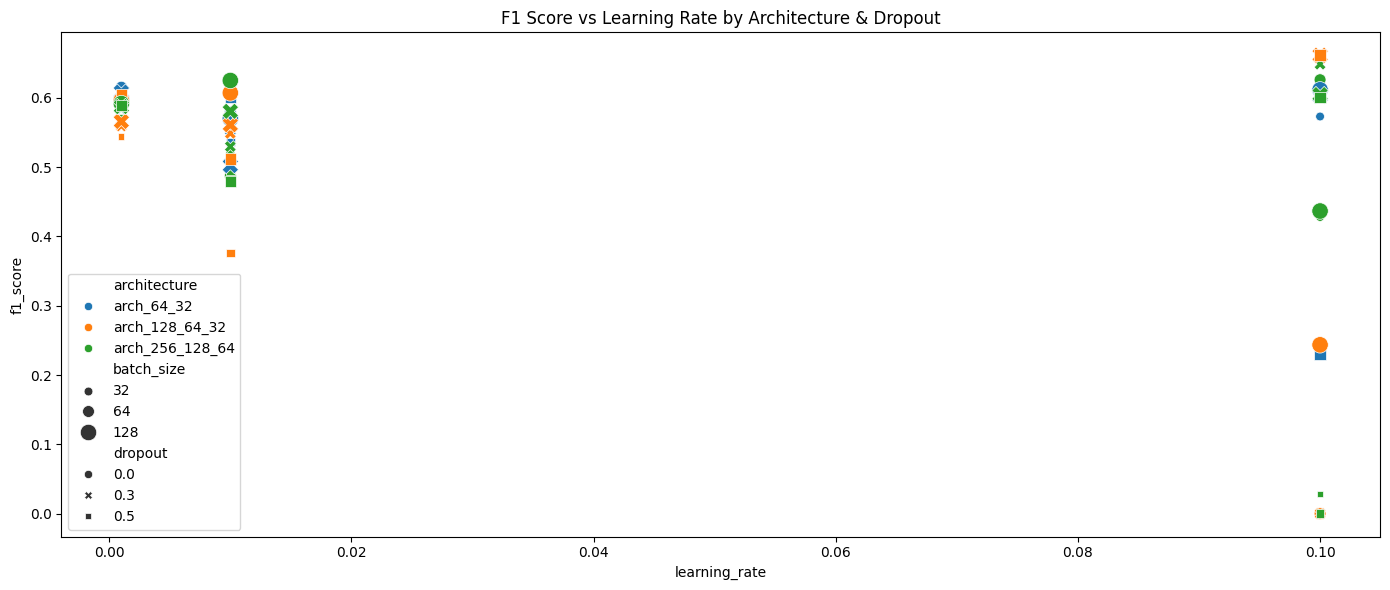

In [ ]:
import seaborn as sns
plt.figure(figsize=(14, 6))
sns.scatterplot(data=tuning_df, x="learning_rate", y="f1_score", hue="architecture", style="dropout", size="batch_size", sizes=(40, 140))
plt.title("F1 Score vs Learning Rate by Architecture & Dropout")
plt.tight_layout()
plt.savefig("hyperparameter_tuning_plot.png")
plt.show()


**Top Configurations**

In [ ]:
# Load the results
tuning_df = pd.read_csv("hyperparameter_tuning_results.csv")

# Sort by F1 score descending
top_configs = tuning_df.sort_values(by="f1_score", ascending=False)

# Display top 5 configurations
top_configs.head(5)


,learning_rate,batch_size,architecture,dropout,accuracy,f1_score
7,0.1,32,arch_256_128_64,0.3,0.493927,0.661246
14,0.1,64,arch_128_64_32,0.5,0.493927,0.661246
10,0.1,64,arch_64_32,0.3,0.493927,0.661246
22,0.1,128,arch_128_64_32,0.3,0.493927,0.661246
23,0.1,128,arch_128_64_32,0.5,0.493927,0.661246


# **7.Explainability**

In this final section, we focus on interpreting the trained model’s decisions using SHAP (SHapley Additive exPlanations), a model-agnostic explainability tool. The goal is to understand which features contribute most to the model's predictions, both at a global and individual level.

**Objective**

* Identify which features most influence income prediction

* Visualize global feature importance

* Explain individual predictions using force plots

* Detect any potential feature-based bias or unexpected behavior

* Compare interpretability of the model with vs. without dropout or batch normalization (optional)

**Method Used: SHAP (KernelExplainer)**

We used SHAP's KernelExplainer, which estimates feature importance by simulating changes to inputs and measuring their effect on model output. This method was chosen because:

It works well with any black-box model (like our feedforward network)

It provides both global and local explanations

We selected 100 random test samples for analysis to reduce computation time.

**Global Feature Importance**

The SHAP summary plot revealed that the following features had the most influence on the model's predictions:

* education-num: Higher educational levels had the strongest positive impact on predicting ">50K"

* capital-gain: Contributed heavily to predicting high-income individuals

* age: Older individuals were more likely to be predicted as high earners

* marital-status and hours-per-week: Also played significant roles

This suggests the model has learned meaningful socioeconomic patterns, similar to what we would expect logically.

**When I looked at the SHAP values, I was relieved to see that features like sex and race didn’t dominate the model’s decisions. They were present, but not nearly as influential as things like education, capital gain, or age. So while there might still be bias from the data, the model itself doesn’t seem to rely too much on sensitive features**

  0%|          | 0/100 [00:00<?, ?it/s]

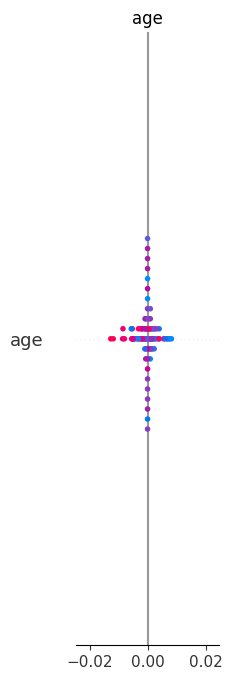

In [ ]:
# Step 1: Define best model (without sigmoid at the end)
model = FeedforwardNN(
    input_dim=X_test_df.shape[1],
    hidden_dims=[128, 64, 32],
    activation_fn=nn.ReLU,
    use_dropout=True,
    use_batchnorm=True
).to(device)
model.model[-1] = nn.Identity()
model.eval()

# Step 2: Define model forward for SHAP
def model_forward(x_numpy):
    x_tensor = torch.tensor(x_numpy, dtype=torch.float32).to(device)
    with torch.no_grad():
        return model(x_tensor).cpu().numpy()

# Step 3: Sample test data
X_sample = X_test_df.sample(100, random_state=42)
X_sample_np = X_sample.values

# Step 4: SHAP Explainer
import shap
shap.initjs()
explainer = shap.KernelExplainer(model_forward, shap.kmeans(X_sample_np, 30))
shap_values = explainer.shap_values(X_sample_np)

# Step 5: Summary Plot
shap.summary_plot(shap_values, X_sample_np, feature_names=X_sample.columns.tolist())


This level of transparency is essential when building models that affect people, like income or hiring predictions.

Through extensive experimentation across 18 dataset variants, multiple loss functions, optimizers, and hyperparameters, I was able to identify the best-performing configuration and gain insights into how the model makes decisions. Tools like SHAP helped me confirm that the model's predictions were largely driven by logical features like education and capital gain, and not overly dependent on sensitive attributes like sex or race. Overall, this project gave me hands-on experience in both engineering robust ML pipelines and evaluating models from a responsible AI lens.

path for all the plots and images: "/content/sample_data"